# INSTALL

In [1]:
# !pip install -q faiss-cpu sentence-transformers transformers torch torchvision accelerate safetensors networkx

# IMPORTS

In [2]:
import os
import json
import torch
import faiss
import pickle
import warnings
import numpy as np
import igraph as ig
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from dataclasses import dataclass
from collections import defaultdict, deque
from sentence_transformers import SentenceTransformer
from transformers import (
    CLIPProcessor, CLIPModel,
    AutoTokenizer, AutoModelForCausalLM
)
warnings.filterwarnings('ignore')


/home/jay/miniconda3/envs/adl_project/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CONSTANTS & CONFIG


In [3]:
@dataclass
class Config:
    DATASET_PATH: str = './Dataset'
    DATABASE_JSON: str = f'{DATASET_PATH}/database.json'
    TRAIN_CSV: str = f'{DATASET_PATH}/train_set.csv'
    TEST_CSV: str = f'{DATASET_PATH}/test_public.csv'
    IMAGE_DIR: str = f'{DATASET_PATH}/database_images_compressed90'

    PRECOMPUTED_PATH: str = './eventa_embeddings_Qwen3'
    EMBEDDINGS_FILE: str = f'{PRECOMPUTED_PATH}/database_embeddings_Qwen3.npy'
    ARTICLE_IDS_FILE: str = f'{PRECOMPUTED_PATH}/database_article_ids_Qwen3.npy'
    FAISS_INDEX_FILE: str = f'{PRECOMPUTED_PATH}/database_faiss_index_Qwen3.bin'

    GRAPH_PATH: str = './temporal_graphs_output/graph_temporal.pkl'
    NODE_MAPPING_PATH: str = './temporal_graphs_output/node_mapping_temporal.json'

    EMBEDDING_MODEL: str = 'Qwen/Qwen3-Embedding-0.6B'
    ARTICLE_RERANKER_MODEL: str = 'Qwen/Qwen3-Reranker-0.6B'
    CLIP_MODEL: str = "openai/clip-vit-large-patch14"

    DEVICE: str = 'cuda' if torch.cuda.is_available() else 'cpu'

    EMBEDDING_BATCH_SIZE: int = 64
    RERANK_BATCH_SIZE: int = 64
    IMG_BATCH: int = 32

    TOP_K_ARTICLES: int = 100
    TOP_K_ARTICLES_RERANK: int = 20
    TOP_K_IMAGES: int = 10

    TOP_K_IMAGES_FAISS: int = 20

    MAX_RERANKER_LENGTH: int = 4096
    MAX_DOC_CHARS: int = 2000
    MAX_CLIP_TOKENS: int = 75

    GRAPH_HOPS: int = 5
    MAX_GRAPH_CANDIDATES: int = 200

    GRAPH_EXPANSION_MODE: str = "weighted_hops"
    PER_NODE_TOPK: int = 20

    TRAIN_VAL_SPLIT: float = 0.999
    RANDOM_SEED: int = 42

config = Config()
print("Device:", config.DEVICE)

Device: cuda


# UTILITY FUNCTIONS

In [4]:
def load_json(filepath):
    with open(filepath, 'r', encoding='utf-8') as f:
        return json.load(f)

def train_val_split(df, split_ratio=0.9, seed=42):
    train = df.sample(frac=split_ratio, random_state=seed)
    val = df.drop(train.index)
    return train.reset_index(drop=True), val.reset_index(drop=True)

def normalize_embeddings(E):
    E = E.astype(np.float32)
    faiss.normalize_L2(E)
    return E

def load_graph(graph_path, node_map_path):
    with open(graph_path, 'rb') as f:
        g = pickle.load(f)

    with open(node_map_path, 'r', encoding='utf-8') as f:
        node_map = json.load(f)

    edge_list = g.get('edge_list', [])

    adj = defaultdict(set)

    adj_w = defaultdict(dict)

    for a, b, w in edge_list:
        a_i = int(a)
        b_i = int(b)
        w_f = float(w)
        adj[a_i].add(b_i)
        adj[b_i].add(a_i)

        prev = adj_w[a_i].get(b_i, None)
        if prev is None or w_f > prev:
            adj_w[a_i][b_i] = w_f
        prev = adj_w[b_i].get(a_i, None)
        if prev is None or w_f > prev:
            adj_w[b_i][a_i] = w_f

    if "sorted_index_to_article_id" in node_map:
        node_map = node_map["sorted_index_to_article_id"]

    idx_to_aid = {int(k): v for k, v in node_map.items()}
    aid_to_idx = {v: int(k) for k, v in node_map.items()}

    return adj, adj_w, idx_to_aid, aid_to_idx

def expand_candidates_via_graph(
    seed_article_ids,
    graph_adj,
    aid_to_idx,
    idx_to_aid,
    graph_weights=None,
    mode="bfs",
    hops=1,
    max_candidates=200,
    topk_per_node=None
):
    if topk_per_node is None:
        topk_per_node = config.PER_NODE_TOPK

    seed_idxs = []
    for aid in seed_article_ids:
        if aid in aid_to_idx:
            seed_idxs.append(aid_to_idx[aid])

    if not seed_idxs:
        return []

    if mode == "bfs" or graph_weights is None:
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue
            for nbr in graph_adj.get(node, []):
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_topk":
        score = defaultdict(float)
        for s in seed_idxs:
            nbrs = graph_weights.get(s, {})
            for nbr, w in nbrs.items():
                if nbr in seed_idxs:
                    continue
                score[nbr] += float(w)

        ranked = sorted(score.items(), key=lambda x: x[1], reverse=True)
        selected = [idx for idx, _ in ranked][:max_candidates]

        result = []
        for idx in seed_idxs:
            if idx not in result:
                result.append(idx_to_aid[idx])
        for idx in selected:
            aid = idx_to_aid.get(idx)
            if aid is None:
                continue
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    if mode == "weighted_hops":
        visited = set(seed_idxs)
        q = deque([(s, 0) for s in seed_idxs])
        while q:
            node, d = q.popleft()
            if d >= hops:
                continue

            nbr_w = graph_weights.get(node, None)
            if nbr_w:
                nbr_candidates = sorted(nbr_w.items(), key=lambda x: x[1], reverse=True)
                nbr_candidates = [n for n, _ in nbr_candidates[:topk_per_node]]
            else:
                nbr_candidates = list(graph_adj.get(node, []))

            for nbr in nbr_candidates:
                if nbr not in visited:
                    visited.add(nbr)
                    q.append((nbr, d+1))
                if len(visited) >= max_candidates:
                    break
            if len(visited) >= max_candidates:
                break

        result = []
        for idx in seed_idxs:
            if idx in visited:
                result.append(idx_to_aid[idx])
        for idx in visited:
            aid = idx_to_aid[idx]
            if aid not in result:
                result.append(aid)
            if len(result) >= max_candidates:
                break
        return result[:max_candidates]

    return expand_candidates_via_graph(seed_article_ids, graph_adj, aid_to_idx, idx_to_aid,
                                       graph_weights=None, mode="bfs", hops=hops, max_candidates=max_candidates)



# METRIC FUNCTIONS

In [5]:
def compute_recall_at_k(pred, gt, k):
    hit = sum(1 for p, g in zip(pred, gt) if g in p[:k])
    return hit / len(gt)

def compute_mrr(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def compute_map(pred, gt):
    s = []
    for p, g in zip(pred, gt):
        s.append(1/(p.index(g)+1) if g in p else 0)
    return sum(s)/len(gt)

def evaluate_retrieval(pred, gt, name):
    print(f"\n{name} Metrics:")
    metrics = {
        "mAP": compute_map(pred, gt),
        "MRR": compute_mrr(pred, gt),
        "Recall@1": compute_recall_at_k(pred, gt, 1),
        "Recall@5": compute_recall_at_k(pred, gt, 5),
        "Recall@10": compute_recall_at_k(pred, gt, 10),
        "Recall@20": compute_recall_at_k(pred, gt, 20),
        "Recall@50": compute_recall_at_k(pred, gt, 50),
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    return metrics


# DATALOADER/DATASET

In [6]:
database = load_json(config.DATABASE_JSON)
train_df = pd.read_csv(config.TRAIN_CSV)
train_df, val_df = train_val_split(train_df, config.TRAIN_VAL_SPLIT, config.RANDOM_SEED)

article_image_map = defaultdict(list)
for aid, data in database.items():
    imgs = data.get("images", []) or []
    for img in imgs:
        if isinstance(img, str):
            iid = os.path.splitext(os.path.basename(img))[0]
            article_image_map[aid].append(iid)
            continue
        if isinstance(img, dict):
            for key in ["image_id","id","file_name","filename","path","file"]:
                if key in img:
                    iid = os.path.splitext(os.path.basename(img[key]))[0]
                    article_image_map[aid].append(iid)
                    break

print("Train:", len(train_df), "Val:", len(val_df))

Train: 22018 Val: 22


# ARCHITECTURE

## EMBEDDING & FAISS

In [7]:
def load_embedding_model():
    m = SentenceTransformer(config.EMBEDDING_MODEL, device=config.DEVICE, trust_remote_code=True)
    if config.DEVICE == 'cuda':
        m.half()
    return m

def generate_embeddings(model, texts, batch=64):
    out = []
    for i in tqdm(range(0, len(texts), batch)):
        b = model.encode(texts[i:i+batch], convert_to_numpy=True)
        out.append(b)
    return np.vstack(out)

def search_index(index, Q, k):
    Q = normalize_embeddings(Q)
    dist, idx = index.search(Q, k)
    return dist, idx

## QWEN3 RERANKER

In [8]:
def load_qwen3_reranker():
    tok = AutoTokenizer.from_pretrained(config.ARTICLE_RERANKER_MODEL, trust_remote_code=True, padding_side='left')
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    model = AutoModelForCausalLM.from_pretrained(
        config.ARTICLE_RERANKER_MODEL,
        torch_dtype=torch.float16 if config.DEVICE=='cuda' else torch.float32,
        trust_remote_code=True
    ).to(config.DEVICE)
    model.eval()
    prefix = "<|im_start|>system\nJudge whether the Document meets the requirements based on the Query and the Instruct provided. Note that the answer can only be \"yes\" or \"no\".\n<|im_end|>\n<|im_start|>user\n"
    suffix = "<|im_end|>\n<|im_start|>assistant\n<think>\n\n</think>\n\n"
    pre = tok.encode(prefix, add_special_tokens=False)
    suf = tok.encode(suffix, add_special_tokens=False)
    yes_id = tok.convert_tokens_to_ids("yes") or tok.convert_tokens_to_ids("Yes")
    no_id  = tok.convert_tokens_to_ids("no")  or tok.convert_tokens_to_ids("No")
    return tok, model, pre, suf, yes_id, no_id

reranker_tokenizer, reranker_model, prefix_tokens, suffix_tokens, yes_id, no_id = load_qwen3_reranker()

def format_instruction(query, doc):
    return f"<Instruct>: Determine relevance\n<Query>: {query}\n<Document>: {doc}"

def process_inputs(pairs):
    toks = reranker_tokenizer(pairs, add_special_tokens=False, padding=False, truncation='longest_first')
    for i, ids in enumerate(toks['input_ids']):
        toks['input_ids'][i] = prefix_tokens + ids + suffix_tokens
    toks = reranker_tokenizer.pad(
        {"input_ids": toks['input_ids']},
        padding=True, return_tensors="pt",
        max_length=config.MAX_RERANKER_LENGTH
    )
    return {k: v.to(config.DEVICE) for k, v in toks.items()}

@torch.no_grad()
def compute_yes_scores(inputs):
    logits = reranker_model(**inputs).logits[:, -1, :]
    pair = torch.stack([logits[:, no_id], logits[:, yes_id]], dim=1)
    probs = torch.nn.functional.log_softmax(pair, dim=1)
    return probs[:,1].exp().cpu().tolist()

def rerank_articles(query, article_ids, batch_size=4):
    pairs = []
    for aid in article_ids:
        art = database[aid]
        title = art.get("title", "")[:200]
        content = art.get("content", "")[:config.MAX_DOC_CHARS]
        doc = f"Title: {title}\nContent: {content}"
        pairs.append(format_instruction(query, doc))
    scores = []
    for i in range(0, len(pairs), batch_size):
        batch_pairs = pairs[i:i+batch_size]
        inp = process_inputs(batch_pairs)
        s = compute_yes_scores(inp)
        scores.extend(s)
        torch.cuda.empty_cache()
    ranked = sorted(zip(article_ids, scores), key=lambda x: x[1], reverse=True)
    return [a for a,_ in ranked[:config.TOP_K_ARTICLES_RERANK]]

## IMAGE RERANKER

In [9]:
clip_model = CLIPModel.from_pretrained(config.CLIP_MODEL).to(config.DEVICE).eval()
clip_processor = CLIPProcessor.from_pretrained(config.CLIP_MODEL)

def path_for(img_id):
    if "." not in img_id:
        return os.path.join(config.IMAGE_DIR, f"{img_id}.jpg")
    return os.path.join(config.IMAGE_DIR, img_id)

@torch.no_grad()
def rerank_images_clip(query, image_ids, top_k):
    text_inputs = clip_processor.tokenizer(
        query,
        truncation=True,
        max_length=config.MAX_CLIP_TOKENS,
        return_tensors="pt",
    )
    query = clip_processor.tokenizer.decode(text_inputs["input_ids"][0], skip_special_tokens=True)
    images = []
    valid = []
    for iid in image_ids:
        p = path_for(iid)
        try:
            images.append(Image.open(p).convert("RGB"))
            valid.append(iid)
        except:
            pass
    if not images:
        return ["#"] * top_k
    text_inputs = clip_processor(text=[query], return_tensors="pt").to(config.DEVICE)
    text_emb = clip_model.get_text_features(**text_inputs)
    all_embs = []
    for i in range(0, len(images), config.IMG_BATCH):
        batch_imgs = images[i:i+config.IMG_BATCH]
        inputs = clip_processor(images=batch_imgs, return_tensors="pt", padding=True).to(config.DEVICE)
        img_feats = clip_model.get_image_features(**inputs)
        all_embs.append(img_feats)
    img_emb = torch.cat(all_embs, dim=0)
    text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)
    img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
    sims = (img_emb @ text_emb.T).squeeze(-1).cpu().numpy()
    ranked = sorted(zip(valid, sims), key=lambda x: x[1], reverse=True)
    return [iid for iid, _ in ranked[:top_k]]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


# LOAD PRECOMPUTED

In [10]:
database_embeddings = np.load(config.EMBEDDINGS_FILE, mmap_mode='r')
database_article_ids = np.load(config.ARTICLE_IDS_FILE, allow_pickle=True).tolist()
faiss_index = faiss.read_index(config.FAISS_INDEX_FILE, faiss.IO_FLAG_MMAP)
embedding_model = load_embedding_model()

graph_adj, graph_adj_weighted, idx_to_aid, aid_to_idx = load_graph(
    config.GRAPH_PATH,
    config.NODE_MAPPING_PATH
)


edges = []
weights = []
with open(config.GRAPH_PATH, 'rb') as f:
    graw = pickle.load(f)

for u, v, w in graw["edge_list"]:
    edges.append((int(u), int(v)))
    weights.append(float(w))

g_ig = ig.Graph(n=len(idx_to_aid), edges=edges)

plt.hist(weights, bins=50)
plt.title("Temporal Graph Edge Weight Distribution")
plt.savefig("graph_edge_weight_distribution.png", dpi=150)
plt.close()

num_components = len(g_ig.components())
largest_comp = g_ig.components().giant()
avg_path = largest_comp.average_path_length()

print("Graph Connectivity (igraph):")
print("Components:", num_components)
print("Avg shortest path (largest component):", avg_path)


Graph Connectivity (igraph):
Components: 154
Avg shortest path (largest component): 1313.5178542635094


# INFERENCE - VALIDATION

In [11]:
val_queries = val_df['caption'].tolist()
val_gt_articles = val_df['retrieved_article_id'].astype(str).tolist()
val_gt_images = val_df['retrieved_image_id'].astype(str).tolist()

Q = generate_embeddings(embedding_model, val_queries, config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)

_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
candidates = [[database_article_ids[i] for i in row] for row in idx]

reranked_articles = []
for i in tqdm(range(0, len(val_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = val_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    reranked_articles.extend(batch_results)

final_images = []
for q, arts in tqdm(zip(val_queries, reranked_articles), total=len(val_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    final_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

article_metrics = evaluate_retrieval(reranked_articles, val_gt_articles, "Article Retrieval")
image_metrics = evaluate_retrieval(final_images, val_gt_images, "Image Retrieval")

baseline_top1 = [c[0] for c in candidates]
graph_top1 = [r[0] for r in reranked_articles]
agree = [1 if a==b else 0 for a,b in zip(baseline_top1, graph_top1)]

plt.scatter(range(len(agree)), agree, alpha=0.5)
plt.title("Top-1 Agreement: Baseline vs Graph")
plt.savefig("scatter_top1_baseline_vs_graph.png", dpi=150)
plt.close()

neighbor_counts = []
for c in candidates:
    exp = expand_candidates_via_graph(
        c,
        graph_adj,
        aid_to_idx,
        idx_to_aid,
        graph_weights=graph_adj_weighted,
        mode=config.GRAPH_EXPANSION_MODE,
        hops=config.GRAPH_HOPS,
        max_candidates=config.MAX_GRAPH_CANDIDATES,
        topk_per_node=config.PER_NODE_TOPK
    )
    neighbor_counts.append(len(set(exp) - set(c)))

plt.hist(neighbor_counts, bins=40)
plt.title("Graph Neighbor Expansion Counts")
plt.savefig("graph_neighbor_overlap.png", dpi=150)
plt.close()

qual = []
for idx in np.random.choice(len(val_queries), 5, replace=False):
    qual.append({
        "query": val_queries[idx],
        "baseline_top5": candidates[idx][:5],
        "graph_top5": reranked_articles[idx][:5]
    })

pd.DataFrame(qual).to_csv("qualitative_graph_comparison.csv", index=False)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:04<00:00,  4.21s/it]

100%|██████████| 1/1 [00:04<00:00,  4.21s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

You're using a Qwen2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


100%|██████████| 1/1 [01:53<00:00, 113.60s/it]

100%|██████████| 1/1 [01:53<00:00, 113.60s/it]

  0%|          | 0/22 [00:00<?, ?it/s]

  5%|▍         | 1/22 [00:12<04:19, 12.35s/it]

  9%|▉         | 2/22 [00:19<03:04,  9.20s/it]

 14%|█▎        | 3/22 [00:35<03:55, 12.38s/it]

 18%|█▊        | 4/22 [00:36<02:23,  7.95s/it]

 23%|██▎       | 5/22 [00:38<01:35,  5.59s/it]

 27%|██▋       | 6/22 [00:50<02:04,  7.76s/it]

 32%|███▏      | 7/22 [01:00<02:11,  8.78s/it]

 36%|███▋      | 8/22 [01:10<02:05,  8.98s/it]

 41%|████      | 9/22 [01:11<01:26,  6.64s/it]

 45%|████▌     | 10/22 [01:12<00:58,  4.88s/it]

 50%|█████     | 11/22 [01:18<00:55,  5.09s/it]

 55%|█████▍    | 12/22 [01:20<00:43,  4.30s/it]

 59%|█████▉    | 13/22 [01:25<00:39,  4.40s/it]

 64%|██████▎   | 14/22 [01:28<00:32,  4.00s/it]

 68%|██████▊   | 15/22 [01:46<00:56,  8.11s/it]

 73%|███████▎  | 16/22 [01:48<00:38,  6.49s/it]

 77%|███████▋  | 17/22 [01:52<00:27,  5.51s/it]

 82%|████████▏ | 18/22 [01:53<00:17,  4.30s/it]

 86%|████████▋ | 19/22 [01:54<00:10,  3.43s/it]

 91%|█████████ | 20/22 [01:56<00:05,  2.73s/it]

 95%|█████████▌| 21/22 [02:00<00:03,  3.33s/it]

100%|██████████| 22/22 [02:03<00:00,  3.00s/it]

100%|██████████| 22/22 [02:03<00:00,  5.59s/it]


Article Retrieval Metrics:
mAP: 0.5701
MRR: 0.5701
Recall@1: 0.4545
Recall@5: 0.7273
Recall@10: 0.7727
Recall@20: 0.7727
Recall@50: 0.7727

Image Retrieval Metrics:
mAP: 0.4068
MRR: 0.4068
Recall@1: 0.2727
Recall@5: 0.6364
Recall@10: 0.6818
Recall@20: 0.6818
Recall@50: 0.6818


# VISUALIZATION

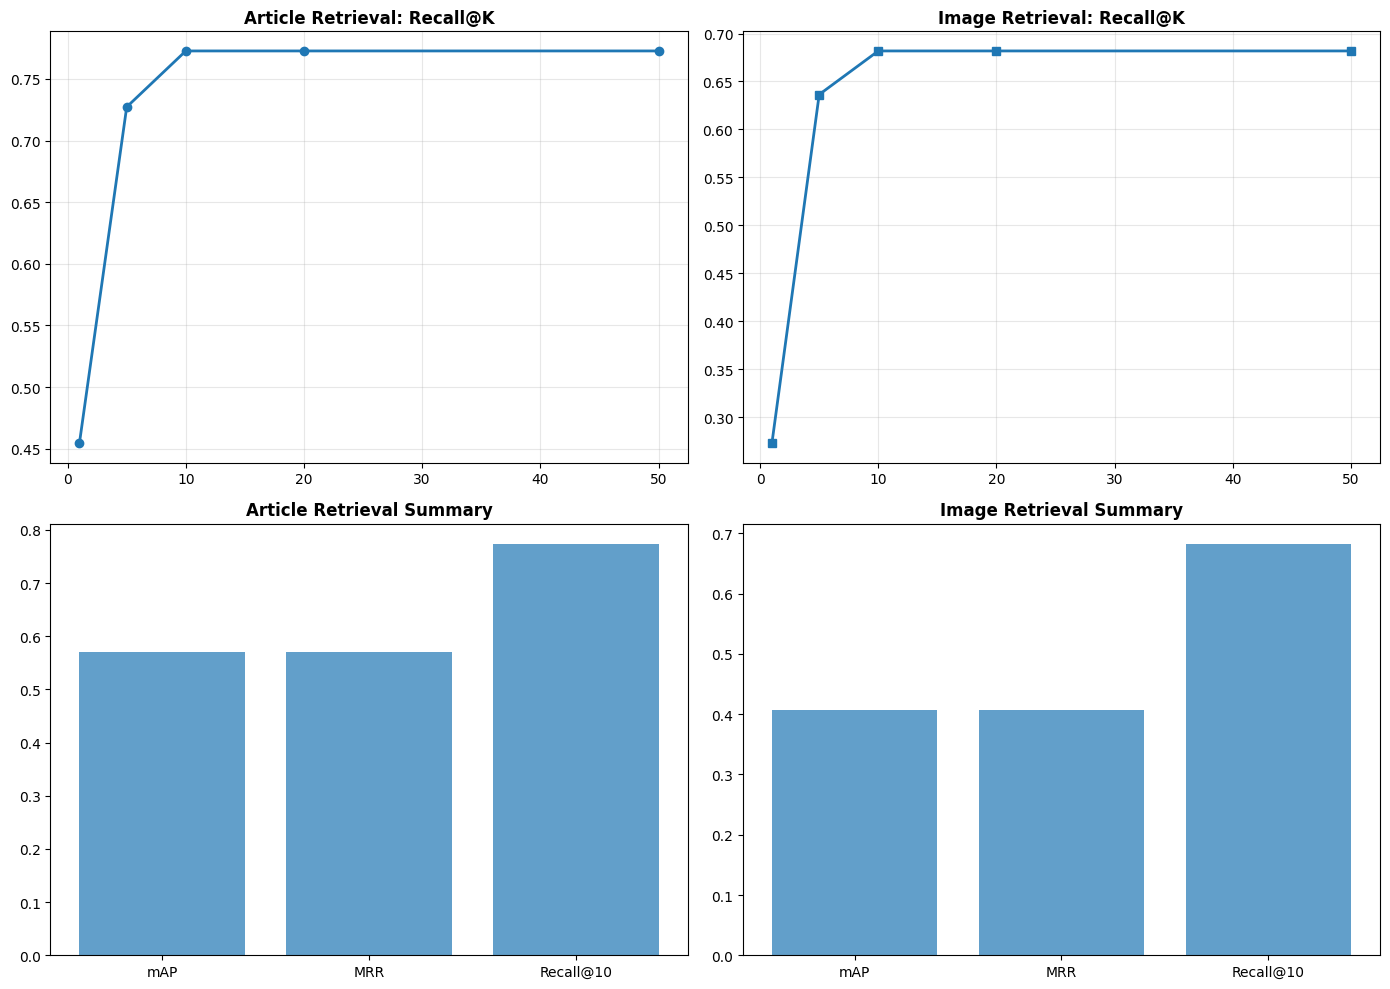

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
k_vals = [1, 5, 10, 20, 50]
article_recalls = [article_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 0].plot(k_vals, article_recalls, marker='o', linewidth=2)
axes[0, 0].set_title("Article Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

image_recalls = [image_metrics[f"Recall@{k}"] for k in k_vals]
axes[0, 1].plot(k_vals, image_recalls, marker='s', linewidth=2)
axes[0, 1].set_title("Image Retrieval: Recall@K", fontsize=12, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

article_summary_keys = ["mAP", "MRR", "Recall@10"]
article_summary_vals = [article_metrics[k] for k in article_summary_keys]
axes[1, 0].bar(article_summary_keys, article_summary_vals, alpha=0.7)
axes[1, 0].set_title("Article Retrieval Summary", fontsize=12, fontweight='bold')

image_summary_keys = ["mAP", "MRR", "Recall@10"]
image_summary_vals = [image_metrics[k] for k in image_summary_keys]
axes[1, 1].bar(image_summary_keys, image_summary_vals, alpha=0.7)
axes[1, 1].set_title("Image Retrieval Summary", fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("qwen3_results.png", dpi=150)
plt.show()


# TEST INFERENCE & SUBMISSION

In [13]:
test_df = pd.read_csv(config.TEST_CSV)
test_queries = test_df['query_text'].tolist()
test_ids = test_df['query_index'].tolist()

Q = generate_embeddings(embedding_model, test_queries, batch=config.EMBEDDING_BATCH_SIZE)
Q = normalize_embeddings(Q)
_, idx = search_index(faiss_index, Q, config.TOP_K_ARTICLES)
test_candidates = [[database_article_ids[i] for i in row] for row in idx]

test_articles = []
for i in tqdm(range(0, len(test_queries), config.RERANK_BATCH_SIZE)):
    batch_queries = test_queries[i:i+config.RERANK_BATCH_SIZE]
    batch_candidates = test_candidates[i:i+config.RERANK_BATCH_SIZE]
    batch_results = []
    for q, c in zip(batch_queries, batch_candidates):
        expanded = expand_candidates_via_graph(
            c,
            graph_adj,
            aid_to_idx,
            idx_to_aid,
            graph_weights=graph_adj_weighted,
            mode=config.GRAPH_EXPANSION_MODE,
            hops=config.GRAPH_HOPS,
            max_candidates=config.MAX_GRAPH_CANDIDATES,
            topk_per_node=config.PER_NODE_TOPK
        )
        batch_results.append(rerank_articles(q, expanded, batch_size=4))
    test_articles.extend(batch_results)

test_images = []
for q, arts in tqdm(zip(test_queries, test_articles), total=len(test_queries)):
    imgs = []
    for a in arts:
        imgs.extend(article_image_map.get(a, []))
    test_images.append(rerank_images_clip(q, imgs, config.TOP_K_IMAGES))

rows = []
for qid, imgs in zip(test_ids, test_images):
    rows.append([qid] + imgs + ["#"]*(config.TOP_K_IMAGES-len(imgs)))

sub = pd.DataFrame(rows, columns=["query_id"]+[f"image_id_{i+1}" for i in range(config.TOP_K_IMAGES)])
sub.to_csv("submission.csv", index=False)
print("Saved submission.csv")


  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [00:00<00:17,  2.60it/s]

  4%|▍         | 2/47 [00:00<00:17,  2.61it/s]

  6%|▋         | 3/47 [00:01<00:17,  2.51it/s]

  9%|▊         | 4/47 [00:01<00:17,  2.42it/s]

 11%|█         | 5/47 [00:01<00:16,  2.50it/s]

 13%|█▎        | 6/47 [00:02<00:16,  2.42it/s]

 15%|█▍        | 7/47 [00:02<00:15,  2.50it/s]

 17%|█▋        | 8/47 [00:03<00:15,  2.60it/s]

 19%|█▉        | 9/47 [00:03<00:14,  2.61it/s]

 21%|██▏       | 10/47 [00:03<00:14,  2.48it/s]

 23%|██▎       | 11/47 [00:04<00:14,  2.53it/s]

 26%|██▌       | 12/47 [00:04<00:13,  2.52it/s]

 28%|██▊       | 13/47 [00:05<00:13,  2.48it/s]

 30%|██▉       | 14/47 [00:05<00:12,  2.56it/s]

 32%|███▏      | 15/47 [00:05<00:12,  2.61it/s]

 34%|███▍      | 16/47 [00:06<00:11,  2.71it/s]

 36%|███▌      | 17/47 [00:06<00:11,  2.70it/s]

 38%|███▊      | 18/47 [00:06<00:10,  2.71it/s]

 40%|████      | 19/47 [00:07<00:10,  2.65it/s]

 43%|████▎     | 20/47 [00:07<00:10,  2.65it/s]

 45%|████▍     | 21/47 [00:08<00:10,  2.56it/s]

 47%|████▋     | 22/47 [00:08<00:09,  2.56it/s]

 49%|████▉     | 23/47 [00:08<00:09,  2.53it/s]

 51%|█████     | 24/47 [00:09<00:09,  2.38it/s]

 53%|█████▎    | 25/47 [00:09<00:08,  2.46it/s]

 55%|█████▌    | 26/47 [00:10<00:08,  2.51it/s]

 57%|█████▋    | 27/47 [00:10<00:07,  2.59it/s]

 60%|█████▉    | 28/47 [00:10<00:07,  2.62it/s]

 62%|██████▏   | 29/47 [00:11<00:06,  2.60it/s]

 64%|██████▍   | 30/47 [00:11<00:06,  2.56it/s]

 66%|██████▌   | 31/47 [00:12<00:06,  2.66it/s]

 68%|██████▊   | 32/47 [00:12<00:05,  2.88it/s]

 70%|███████   | 33/47 [00:12<00:04,  2.87it/s]

 72%|███████▏  | 34/47 [00:13<00:04,  2.92it/s]

 74%|███████▍  | 35/47 [00:13<00:03,  3.03it/s]

 77%|███████▋  | 36/47 [00:13<00:03,  2.91it/s]

 79%|███████▊  | 37/47 [00:14<00:03,  2.79it/s]

 81%|████████  | 38/47 [00:14<00:03,  2.67it/s]

 83%|████████▎ | 39/47 [00:14<00:03,  2.57it/s]

 85%|████████▌ | 40/47 [00:15<00:02,  2.46it/s]

 87%|████████▋ | 41/47 [00:15<00:02,  2.42it/s]

 89%|████████▉ | 42/47 [00:16<00:02,  2.31it/s]

 91%|█████████▏| 43/47 [00:16<00:01,  2.29it/s]

 94%|█████████▎| 44/47 [00:17<00:01,  2.09it/s]

 96%|█████████▌| 45/47 [00:17<00:00,  2.14it/s]

 98%|█████████▊| 46/47 [00:18<00:00,  2.28it/s]

100%|██████████| 47/47 [00:18<00:00,  2.36it/s]

100%|██████████| 47/47 [00:18<00:00,  2.54it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  2%|▏         | 1/47 [05:29<4:12:58, 329.97s/it]

  4%|▍         | 2/47 [11:07<4:10:38, 334.20s/it]

  6%|▋         | 3/47 [16:42<4:05:26, 334.69s/it]

  9%|▊         | 4/47 [22:28<4:03:01, 339.11s/it]

 11%|█         | 5/47 [28:06<3:57:14, 338.93s/it]

 13%|█▎        | 6/47 [33:38<3:49:49, 336.34s/it]

 15%|█▍        | 7/47 [39:16<3:44:40, 337.02s/it]

 17%|█▋        | 8/47 [44:51<3:38:42, 336.48s/it]

 19%|█▉        | 9/47 [50:35<3:34:25, 338.57s/it]

 21%|██▏       | 10/47 [56:16<3:29:20, 339.47s/it]

 23%|██▎       | 11/47 [1:02:03<3:25:00, 341.67s/it]

 26%|██▌       | 12/47 [1:07:46<3:19:38, 342.24s/it]

 28%|██▊       | 13/47 [1:13:32<3:14:30, 343.25s/it]

 30%|██▉       | 14/47 [1:19:09<3:07:45, 341.37s/it]

 32%|███▏      | 15/47 [1:24:49<3:01:50, 340.94s/it]

 34%|███▍      | 16/47 [1:30:17<2:54:06, 336.97s/it]

 36%|███▌      | 17/47 [1:35:52<2:48:11, 336.40s/it]

 38%|███▊      | 18/47 [1:41:29<2:42:40, 336.59s/it]

 40%|████      | 19/47 [1:47:10<2:37:40, 337.86s/it]

 43%|████▎     | 20/47 [1:52:56<2:33:10, 340.39s/it]

 45%|████▍     | 21/47 [1:58:39<2:27:49, 341.14s/it]

 47%|████▋     | 22/47 [2:04:19<2:22:00, 340.84s/it]

 49%|████▉     | 23/47 [2:09:54<2:15:41, 339.22s/it]

 51%|█████     | 24/47 [2:15:37<2:10:24, 340.18s/it]

 53%|█████▎    | 25/47 [2:21:05<2:03:25, 336.62s/it]

 55%|█████▌    | 26/47 [2:26:32<1:56:47, 333.68s/it]

 57%|█████▋    | 27/47 [2:32:06<1:51:16, 333.81s/it]

 60%|█████▉    | 28/47 [2:37:42<1:45:53, 334.42s/it]

 62%|██████▏   | 29/47 [2:43:14<1:40:08, 333.79s/it]

 64%|██████▍   | 30/47 [2:48:44<1:34:13, 332.55s/it]

 66%|██████▌   | 31/47 [2:54:13<1:28:25, 331.59s/it]

 68%|██████▊   | 32/47 [2:59:43<1:22:47, 331.19s/it]

 70%|███████   | 33/47 [3:05:13<1:17:11, 330.83s/it]

 72%|███████▏  | 34/47 [3:10:44<1:11:38, 330.66s/it]

 74%|███████▍  | 35/47 [3:16:20<1:06:29, 332.48s/it]

 77%|███████▋  | 36/47 [3:21:57<1:01:11, 333.75s/it]

 79%|███████▊  | 37/47 [3:27:37<55:54, 335.48s/it]  

 81%|████████  | 38/47 [3:33:11<50:16, 335.19s/it]

 83%|████████▎ | 39/47 [3:38:51<44:51, 336.46s/it]

 85%|████████▌ | 40/47 [3:44:33<39:27, 338.21s/it]

 87%|████████▋ | 41/47 [3:50:03<33:35, 335.88s/it]

 89%|████████▉ | 42/47 [3:55:47<28:11, 338.26s/it]

 91%|█████████▏| 43/47 [4:01:29<22:37, 339.37s/it]

 94%|█████████▎| 44/47 [4:07:13<17:02, 340.88s/it]

 96%|█████████▌| 45/47 [4:12:58<11:23, 341.84s/it]

 98%|█████████▊| 46/47 [4:18:39<05:41, 341.66s/it]

100%|██████████| 47/47 [4:23:34<00:00, 327.84s/it]

100%|██████████| 47/47 [4:23:34<00:00, 336.49s/it]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 1/3000 [00:07<6:35:44,  7.92s/it]

  0%|          | 2/3000 [00:14<5:54:56,  7.10s/it]

  0%|          | 3/3000 [00:17<4:19:44,  5.20s/it]

  0%|          | 4/3000 [00:21<3:53:14,  4.67s/it]

  0%|          | 5/3000 [00:24<3:33:56,  4.29s/it]

  0%|          | 6/3000 [00:27<3:14:16,  3.89s/it]

  0%|          | 7/3000 [00:35<4:15:21,  5.12s/it]

  0%|          | 8/3000 [00:41<4:31:57,  5.45s/it]

  0%|          | 9/3000 [00:44<3:56:20,  4.74s/it]

  0%|          | 10/3000 [00:48<3:42:51,  4.47s/it]

  0%|          | 11/3000 [00:50<3:01:58,  3.65s/it]

  0%|          | 12/3000 [00:51<2:26:03,  2.93s/it]

  0%|          | 13/3000 [00:57<3:11:58,  3.86s/it]

  0%|          | 14/3000 [01:01<3:03:14,  3.68s/it]

  0%|          | 15/3000 [01:06<3:24:12,  4.10s/it]

  1%|          | 16/3000 [01:11<3:40:06,  4.43s/it]

  1%|          | 17/3000 [01:13<3:08:34,  3.79s/it]

  1%|          | 18/3000 [01:18<3:29:27,  4.21s/it]

  1%|          | 19/3000 [01:23<3:28:21,  4.19s/it]

  1%|          | 20/3000 [01:27<3:29:21,  4.22s/it]

  1%|          | 21/3000 [01:33<3:51:13,  4.66s/it]

  1%|          | 22/3000 [01:38<4:05:58,  4.96s/it]

  1%|          | 23/3000 [01:49<5:33:31,  6.72s/it]

  1%|          | 24/3000 [01:52<4:34:21,  5.53s/it]

  1%|          | 25/3000 [01:58<4:41:47,  5.68s/it]

  1%|          | 26/3000 [02:03<4:33:32,  5.52s/it]

  1%|          | 27/3000 [02:08<4:20:10,  5.25s/it]

  1%|          | 28/3000 [02:10<3:43:30,  4.51s/it]

  1%|          | 29/3000 [02:12<3:00:12,  3.64s/it]

  1%|          | 30/3000 [02:16<3:02:53,  3.69s/it]

  1%|          | 31/3000 [02:18<2:44:03,  3.32s/it]

  1%|          | 32/3000 [02:27<4:09:04,  5.04s/it]

  1%|          | 33/3000 [02:33<4:19:06,  5.24s/it]

  1%|          | 34/3000 [02:41<4:56:16,  5.99s/it]

  1%|          | 35/3000 [02:45<4:33:23,  5.53s/it]

  1%|          | 36/3000 [02:49<4:13:27,  5.13s/it]

  1%|          | 37/3000 [02:51<3:17:17,  3.99s/it]

  1%|▏         | 38/3000 [02:53<2:45:17,  3.35s/it]

  1%|▏         | 39/3000 [02:56<2:49:47,  3.44s/it]

  1%|▏         | 40/3000 [02:59<2:36:20,  3.17s/it]

  1%|▏         | 41/3000 [03:02<2:36:18,  3.17s/it]

  1%|▏         | 42/3000 [03:03<2:07:18,  2.58s/it]

  1%|▏         | 43/3000 [03:06<2:07:39,  2.59s/it]

  1%|▏         | 44/3000 [03:09<2:11:44,  2.67s/it]

  2%|▏         | 45/3000 [03:13<2:35:45,  3.16s/it]

  2%|▏         | 46/3000 [03:18<2:57:59,  3.62s/it]

  2%|▏         | 47/3000 [03:19<2:32:09,  3.09s/it]

  2%|▏         | 48/3000 [03:24<2:48:47,  3.43s/it]

  2%|▏         | 49/3000 [03:25<2:16:28,  2.77s/it]

  2%|▏         | 50/3000 [03:28<2:14:34,  2.74s/it]

  2%|▏         | 51/3000 [03:36<3:34:26,  4.36s/it]

  2%|▏         | 52/3000 [03:41<3:51:37,  4.71s/it]

  2%|▏         | 53/3000 [03:47<4:01:42,  4.92s/it]

  2%|▏         | 54/3000 [03:55<4:51:07,  5.93s/it]

  2%|▏         | 55/3000 [03:58<4:10:12,  5.10s/it]

  2%|▏         | 56/3000 [04:05<4:42:30,  5.76s/it]

  2%|▏         | 57/3000 [04:10<4:27:00,  5.44s/it]

  2%|▏         | 58/3000 [04:14<3:58:02,  4.85s/it]

  2%|▏         | 59/3000 [04:15<3:10:59,  3.90s/it]

  2%|▏         | 60/3000 [04:19<3:07:29,  3.83s/it]

  2%|▏         | 61/3000 [04:24<3:18:41,  4.06s/it]

  2%|▏         | 62/3000 [04:40<6:14:54,  7.66s/it]

  2%|▏         | 63/3000 [04:43<5:13:48,  6.41s/it]

  2%|▏         | 64/3000 [04:48<4:50:52,  5.94s/it]

  2%|▏         | 65/3000 [04:51<4:10:33,  5.12s/it]

  2%|▏         | 66/3000 [04:55<3:51:02,  4.72s/it]

  2%|▏         | 67/3000 [04:59<3:41:54,  4.54s/it]

  2%|▏         | 68/3000 [05:05<3:58:16,  4.88s/it]

  2%|▏         | 69/3000 [05:09<3:54:54,  4.81s/it]

  2%|▏         | 70/3000 [05:13<3:31:26,  4.33s/it]

  2%|▏         | 71/3000 [05:17<3:39:11,  4.49s/it]

  2%|▏         | 72/3000 [05:20<3:06:24,  3.82s/it]

  2%|▏         | 73/3000 [05:25<3:31:56,  4.34s/it]

  2%|▏         | 74/3000 [05:31<3:57:52,  4.88s/it]

  2%|▎         | 75/3000 [05:43<5:39:09,  6.96s/it]

  3%|▎         | 76/3000 [05:47<4:46:30,  5.88s/it]

  3%|▎         | 77/3000 [05:52<4:36:29,  5.68s/it]

  3%|▎         | 78/3000 [05:58<4:37:21,  5.70s/it]

  3%|▎         | 79/3000 [06:03<4:29:12,  5.53s/it]

  3%|▎         | 80/3000 [06:12<5:23:53,  6.66s/it]

  3%|▎         | 81/3000 [06:17<4:58:41,  6.14s/it]

  3%|▎         | 82/3000 [06:19<4:01:51,  4.97s/it]

  3%|▎         | 83/3000 [06:23<3:38:44,  4.50s/it]

  3%|▎         | 84/3000 [06:30<4:18:41,  5.32s/it]

  3%|▎         | 85/3000 [06:33<3:43:51,  4.61s/it]

  3%|▎         | 86/3000 [06:36<3:31:37,  4.36s/it]

  3%|▎         | 87/3000 [06:42<3:47:55,  4.69s/it]

  3%|▎         | 88/3000 [06:49<4:26:11,  5.48s/it]

  3%|▎         | 89/3000 [06:56<4:38:11,  5.73s/it]

  3%|▎         | 90/3000 [07:02<4:49:08,  5.96s/it]

  3%|▎         | 91/3000 [07:07<4:28:57,  5.55s/it]

  3%|▎         | 92/3000 [07:10<3:58:43,  4.93s/it]

  3%|▎         | 93/3000 [07:14<3:37:37,  4.49s/it]

  3%|▎         | 94/3000 [07:15<2:55:46,  3.63s/it]

  3%|▎         | 95/3000 [07:17<2:31:46,  3.13s/it]

  3%|▎         | 96/3000 [07:19<2:13:32,  2.76s/it]

  3%|▎         | 97/3000 [07:22<2:08:17,  2.65s/it]

  3%|▎         | 98/3000 [07:24<2:09:03,  2.67s/it]

  3%|▎         | 99/3000 [07:26<1:56:44,  2.41s/it]

  3%|▎         | 100/3000 [07:28<1:47:43,  2.23s/it]

  3%|▎         | 101/3000 [07:33<2:32:24,  3.15s/it]

  3%|▎         | 102/3000 [07:37<2:37:46,  3.27s/it]

  3%|▎         | 103/3000 [07:40<2:44:06,  3.40s/it]

  3%|▎         | 104/3000 [07:49<4:01:10,  5.00s/it]

  4%|▎         | 105/3000 [07:50<3:00:23,  3.74s/it]

  4%|▎         | 106/3000 [07:55<3:17:21,  4.09s/it]

  4%|▎         | 107/3000 [07:58<2:58:00,  3.69s/it]

  4%|▎         | 108/3000 [08:06<4:09:20,  5.17s/it]

  4%|▎         | 109/3000 [08:13<4:37:45,  5.76s/it]

  4%|▎         | 110/3000 [08:18<4:19:10,  5.38s/it]

  4%|▎         | 111/3000 [08:23<4:11:32,  5.22s/it]

  4%|▎         | 112/3000 [08:25<3:24:07,  4.24s/it]

  4%|▍         | 113/3000 [08:27<2:51:34,  3.57s/it]

  4%|▍         | 114/3000 [08:34<3:42:41,  4.63s/it]

  4%|▍         | 115/3000 [08:38<3:38:36,  4.55s/it]

  4%|▍         | 116/3000 [08:43<3:43:57,  4.66s/it]

  4%|▍         | 117/3000 [08:48<3:49:39,  4.78s/it]

  4%|▍         | 118/3000 [08:51<3:17:21,  4.11s/it]

  4%|▍         | 119/3000 [08:54<3:04:14,  3.84s/it]

  4%|▍         | 120/3000 [08:57<2:50:14,  3.55s/it]

  4%|▍         | 121/3000 [09:05<3:52:50,  4.85s/it]

  4%|▍         | 122/3000 [09:11<4:16:19,  5.34s/it]

  4%|▍         | 123/3000 [09:15<3:58:38,  4.98s/it]

  4%|▍         | 124/3000 [09:19<3:34:20,  4.47s/it]

  4%|▍         | 125/3000 [09:21<3:04:59,  3.86s/it]

  4%|▍         | 126/3000 [09:25<3:08:32,  3.94s/it]

  4%|▍         | 127/3000 [09:32<3:51:19,  4.83s/it]

  4%|▍         | 128/3000 [09:39<4:18:30,  5.40s/it]

  4%|▍         | 129/3000 [09:46<4:42:21,  5.90s/it]

  4%|▍         | 130/3000 [09:51<4:29:28,  5.63s/it]

  4%|▍         | 131/3000 [09:56<4:23:46,  5.52s/it]

  4%|▍         | 132/3000 [10:06<5:28:00,  6.86s/it]

  4%|▍         | 133/3000 [10:11<4:55:07,  6.18s/it]

  4%|▍         | 134/3000 [10:19<5:25:48,  6.82s/it]

  4%|▍         | 135/3000 [10:23<4:52:20,  6.12s/it]

  5%|▍         | 136/3000 [10:32<5:31:57,  6.95s/it]

  5%|▍         | 137/3000 [10:38<5:16:17,  6.63s/it]

  5%|▍         | 138/3000 [10:42<4:42:16,  5.92s/it]

  5%|▍         | 139/3000 [10:45<3:57:51,  4.99s/it]

  5%|▍         | 140/3000 [10:47<3:15:22,  4.10s/it]

  5%|▍         | 141/3000 [10:49<2:40:32,  3.37s/it]

  5%|▍         | 142/3000 [10:51<2:23:14,  3.01s/it]

  5%|▍         | 143/3000 [10:54<2:14:23,  2.82s/it]

  5%|▍         | 144/3000 [11:00<3:00:24,  3.79s/it]

  5%|▍         | 145/3000 [11:03<2:51:35,  3.61s/it]

  5%|▍         | 146/3000 [11:04<2:16:24,  2.87s/it]

  5%|▍         | 147/3000 [11:05<1:53:00,  2.38s/it]

  5%|▍         | 148/3000 [11:06<1:36:34,  2.03s/it]

  5%|▍         | 149/3000 [11:11<2:11:27,  2.77s/it]

  5%|▌         | 150/3000 [11:12<1:54:42,  2.41s/it]

  5%|▌         | 151/3000 [11:15<1:51:22,  2.35s/it]

  5%|▌         | 152/3000 [11:23<3:19:05,  4.19s/it]

  5%|▌         | 153/3000 [11:31<4:10:33,  5.28s/it]

  5%|▌         | 154/3000 [11:41<5:21:55,  6.79s/it]

  5%|▌         | 155/3000 [11:46<4:53:30,  6.19s/it]

  5%|▌         | 156/3000 [11:52<4:51:21,  6.15s/it]

  5%|▌         | 157/3000 [11:55<4:12:08,  5.32s/it]

  5%|▌         | 158/3000 [12:01<4:19:39,  5.48s/it]

  5%|▌         | 159/3000 [12:03<3:19:53,  4.22s/it]

  5%|▌         | 160/3000 [12:05<2:56:16,  3.72s/it]

  5%|▌         | 161/3000 [12:09<3:00:44,  3.82s/it]

  5%|▌         | 162/3000 [12:15<3:32:46,  4.50s/it]

  5%|▌         | 163/3000 [12:19<3:16:51,  4.16s/it]

  5%|▌         | 164/3000 [12:23<3:20:54,  4.25s/it]

  6%|▌         | 165/3000 [12:26<2:55:08,  3.71s/it]

  6%|▌         | 166/3000 [12:27<2:25:17,  3.08s/it]

  6%|▌         | 167/3000 [12:30<2:22:21,  3.02s/it]

  6%|▌         | 168/3000 [12:34<2:32:47,  3.24s/it]

  6%|▌         | 169/3000 [12:35<2:10:31,  2.77s/it]

  6%|▌         | 170/3000 [12:37<1:51:18,  2.36s/it]

  6%|▌         | 171/3000 [12:41<2:18:16,  2.93s/it]

  6%|▌         | 172/3000 [12:42<1:52:20,  2.38s/it]

  6%|▌         | 173/3000 [12:49<2:50:15,  3.61s/it]

  6%|▌         | 174/3000 [12:55<3:24:59,  4.35s/it]

  6%|▌         | 175/3000 [12:59<3:22:16,  4.30s/it]

  6%|▌         | 176/3000 [13:03<3:13:22,  4.11s/it]

  6%|▌         | 177/3000 [13:05<2:55:19,  3.73s/it]

  6%|▌         | 178/3000 [13:10<3:02:54,  3.89s/it]

  6%|▌         | 179/3000 [13:13<2:57:03,  3.77s/it]

  6%|▌         | 180/3000 [13:17<2:54:12,  3.71s/it]

  6%|▌         | 181/3000 [13:21<3:03:02,  3.90s/it]

  6%|▌         | 182/3000 [13:25<3:05:40,  3.95s/it]

  6%|▌         | 183/3000 [13:30<3:20:01,  4.26s/it]

  6%|▌         | 184/3000 [13:36<3:47:32,  4.85s/it]

  6%|▌         | 185/3000 [13:39<3:09:25,  4.04s/it]

  6%|▌         | 186/3000 [13:45<3:45:49,  4.81s/it]

  6%|▌         | 187/3000 [13:48<3:14:57,  4.16s/it]

  6%|▋         | 188/3000 [13:53<3:27:52,  4.44s/it]

  6%|▋         | 189/3000 [13:59<3:46:01,  4.82s/it]

  6%|▋         | 190/3000 [14:01<3:11:10,  4.08s/it]

  6%|▋         | 191/3000 [14:04<2:55:37,  3.75s/it]

  6%|▋         | 192/3000 [14:08<3:02:20,  3.90s/it]

  6%|▋         | 193/3000 [14:18<4:25:54,  5.68s/it]

  6%|▋         | 194/3000 [14:21<3:51:28,  4.95s/it]

  6%|▋         | 195/3000 [14:30<4:45:35,  6.11s/it]

  7%|▋         | 196/3000 [14:35<4:31:24,  5.81s/it]

  7%|▋         | 197/3000 [14:40<4:19:22,  5.55s/it]

  7%|▋         | 198/3000 [14:44<3:53:01,  4.99s/it]

  7%|▋         | 199/3000 [14:49<3:58:04,  5.10s/it]

  7%|▋         | 200/3000 [14:53<3:41:07,  4.74s/it]

  7%|▋         | 201/3000 [14:57<3:30:20,  4.51s/it]

  7%|▋         | 202/3000 [15:02<3:42:42,  4.78s/it]

  7%|▋         | 203/3000 [15:07<3:39:08,  4.70s/it]

  7%|▋         | 204/3000 [15:11<3:24:38,  4.39s/it]

  7%|▋         | 205/3000 [15:14<3:07:20,  4.02s/it]

  7%|▋         | 206/3000 [15:22<4:00:20,  5.16s/it]

  7%|▋         | 207/3000 [15:29<4:26:08,  5.72s/it]

  7%|▋         | 208/3000 [15:32<3:57:45,  5.11s/it]

  7%|▋         | 209/3000 [15:44<5:35:05,  7.20s/it]

  7%|▋         | 210/3000 [15:55<6:18:50,  8.15s/it]

  7%|▋         | 211/3000 [16:05<6:43:48,  8.69s/it]

  7%|▋         | 212/3000 [16:07<5:20:20,  6.89s/it]

  7%|▋         | 213/3000 [16:10<4:22:51,  5.66s/it]

  7%|▋         | 214/3000 [16:17<4:36:17,  5.95s/it]

  7%|▋         | 215/3000 [16:21<4:14:26,  5.48s/it]

  7%|▋         | 216/3000 [16:25<3:56:12,  5.09s/it]

  7%|▋         | 217/3000 [16:29<3:36:31,  4.67s/it]

  7%|▋         | 218/3000 [16:33<3:32:19,  4.58s/it]

  7%|▋         | 219/3000 [16:38<3:32:17,  4.58s/it]

  7%|▋         | 220/3000 [16:45<3:59:08,  5.16s/it]

  7%|▋         | 221/3000 [16:54<5:05:09,  6.59s/it]

  7%|▋         | 222/3000 [17:00<4:53:29,  6.34s/it]

  7%|▋         | 223/3000 [17:06<4:41:54,  6.09s/it]

  7%|▋         | 224/3000 [17:10<4:22:05,  5.66s/it]

  8%|▊         | 225/3000 [17:13<3:42:02,  4.80s/it]

  8%|▊         | 226/3000 [17:22<4:38:53,  6.03s/it]

  8%|▊         | 227/3000 [17:30<5:09:37,  6.70s/it]

  8%|▊         | 228/3000 [17:36<5:00:41,  6.51s/it]

  8%|▊         | 229/3000 [17:40<4:26:10,  5.76s/it]

  8%|▊         | 230/3000 [17:45<4:08:05,  5.37s/it]

  8%|▊         | 231/3000 [17:47<3:17:29,  4.28s/it]

  8%|▊         | 232/3000 [17:53<3:44:03,  4.86s/it]

  8%|▊         | 233/3000 [17:56<3:14:49,  4.22s/it]

  8%|▊         | 234/3000 [18:01<3:35:12,  4.67s/it]

  8%|▊         | 235/3000 [18:07<3:45:52,  4.90s/it]

  8%|▊         | 236/3000 [18:10<3:22:14,  4.39s/it]

  8%|▊         | 237/3000 [18:13<3:04:34,  4.01s/it]

  8%|▊         | 238/3000 [18:25<4:55:09,  6.41s/it]

  8%|▊         | 239/3000 [18:28<4:08:57,  5.41s/it]

  8%|▊         | 240/3000 [18:34<4:16:28,  5.58s/it]

  8%|▊         | 241/3000 [18:42<4:42:07,  6.14s/it]

  8%|▊         | 242/3000 [18:46<4:18:05,  5.61s/it]

  8%|▊         | 243/3000 [18:49<3:38:51,  4.76s/it]

  8%|▊         | 244/3000 [18:56<4:16:27,  5.58s/it]

  8%|▊         | 245/3000 [18:59<3:41:12,  4.82s/it]

  8%|▊         | 246/3000 [19:04<3:36:43,  4.72s/it]

  8%|▊         | 247/3000 [19:08<3:27:30,  4.52s/it]

  8%|▊         | 248/3000 [19:12<3:25:37,  4.48s/it]

  8%|▊         | 249/3000 [19:18<3:43:00,  4.86s/it]

  8%|▊         | 250/3000 [19:21<3:17:08,  4.30s/it]

  8%|▊         | 251/3000 [19:28<3:54:18,  5.11s/it]

  8%|▊         | 252/3000 [19:29<3:00:31,  3.94s/it]

  8%|▊         | 253/3000 [19:32<2:47:18,  3.65s/it]

  8%|▊         | 254/3000 [19:37<3:01:53,  3.97s/it]

  8%|▊         | 255/3000 [19:41<3:02:43,  3.99s/it]

  9%|▊         | 256/3000 [19:45<2:57:19,  3.88s/it]

  9%|▊         | 257/3000 [19:45<2:16:24,  2.98s/it]

  9%|▊         | 258/3000 [19:52<3:06:36,  4.08s/it]

  9%|▊         | 259/3000 [19:55<2:50:03,  3.72s/it]

  9%|▊         | 260/3000 [19:59<3:01:04,  3.97s/it]

  9%|▊         | 261/3000 [20:03<2:49:44,  3.72s/it]

  9%|▊         | 262/3000 [20:06<2:45:51,  3.63s/it]

  9%|▉         | 263/3000 [20:08<2:29:14,  3.27s/it]

  9%|▉         | 264/3000 [20:12<2:33:53,  3.37s/it]

  9%|▉         | 265/3000 [20:17<2:56:56,  3.88s/it]

  9%|▉         | 266/3000 [20:26<3:57:58,  5.22s/it]

  9%|▉         | 267/3000 [20:28<3:14:45,  4.28s/it]

  9%|▉         | 268/3000 [20:43<5:46:30,  7.61s/it]

  9%|▉         | 269/3000 [20:46<4:42:35,  6.21s/it]

  9%|▉         | 270/3000 [20:53<4:54:32,  6.47s/it]

  9%|▉         | 271/3000 [20:57<4:18:16,  5.68s/it]

  9%|▉         | 272/3000 [21:09<5:49:57,  7.70s/it]

  9%|▉         | 273/3000 [21:14<5:08:18,  6.78s/it]

  9%|▉         | 274/3000 [21:18<4:37:18,  6.10s/it]

  9%|▉         | 275/3000 [21:22<3:57:25,  5.23s/it]

  9%|▉         | 276/3000 [21:25<3:30:34,  4.64s/it]

  9%|▉         | 277/3000 [21:27<3:02:18,  4.02s/it]

  9%|▉         | 278/3000 [21:32<3:08:57,  4.17s/it]

  9%|▉         | 279/3000 [21:39<3:45:42,  4.98s/it]

  9%|▉         | 280/3000 [21:43<3:38:38,  4.82s/it]

  9%|▉         | 281/3000 [21:51<4:18:48,  5.71s/it]

  9%|▉         | 282/3000 [21:53<3:29:54,  4.63s/it]

  9%|▉         | 283/3000 [21:57<3:21:10,  4.44s/it]

  9%|▉         | 284/3000 [22:00<2:53:28,  3.83s/it]

 10%|▉         | 285/3000 [22:03<2:41:10,  3.56s/it]

 10%|▉         | 286/3000 [22:06<2:42:17,  3.59s/it]

 10%|▉         | 287/3000 [22:10<2:39:35,  3.53s/it]

 10%|▉         | 288/3000 [22:13<2:35:26,  3.44s/it]

 10%|▉         | 289/3000 [22:17<2:42:12,  3.59s/it]

 10%|▉         | 290/3000 [22:21<2:54:12,  3.86s/it]

 10%|▉         | 291/3000 [22:28<3:34:48,  4.76s/it]

 10%|▉         | 292/3000 [22:40<5:10:12,  6.87s/it]

 10%|▉         | 293/3000 [22:46<4:59:59,  6.65s/it]

 10%|▉         | 294/3000 [22:52<4:49:48,  6.43s/it]

 10%|▉         | 295/3000 [22:59<4:54:23,  6.53s/it]

 10%|▉         | 296/3000 [23:07<5:14:01,  6.97s/it]

 10%|▉         | 297/3000 [23:16<5:45:37,  7.67s/it]

 10%|▉         | 298/3000 [23:24<5:45:38,  7.68s/it]

 10%|▉         | 299/3000 [23:31<5:36:34,  7.48s/it]

 10%|█         | 300/3000 [23:39<5:47:00,  7.71s/it]

 10%|█         | 301/3000 [23:45<5:24:56,  7.22s/it]

 10%|█         | 302/3000 [23:48<4:30:58,  6.03s/it]

 10%|█         | 303/3000 [23:53<4:10:16,  5.57s/it]

 10%|█         | 304/3000 [23:56<3:36:24,  4.82s/it]

 10%|█         | 305/3000 [23:59<3:14:24,  4.33s/it]

 10%|█         | 306/3000 [24:04<3:16:49,  4.38s/it]

 10%|█         | 307/3000 [24:07<3:11:21,  4.26s/it]

 10%|█         | 308/3000 [24:14<3:43:57,  4.99s/it]

 10%|█         | 309/3000 [24:17<3:18:38,  4.43s/it]

 10%|█         | 310/3000 [24:21<3:05:07,  4.13s/it]

 10%|█         | 311/3000 [24:35<5:19:07,  7.12s/it]

 10%|█         | 312/3000 [24:45<5:54:48,  7.92s/it]

 10%|█         | 313/3000 [25:00<7:36:46, 10.20s/it]

 10%|█         | 314/3000 [25:13<8:16:12, 11.08s/it]

 10%|█         | 315/3000 [25:24<8:07:10, 10.89s/it]

 11%|█         | 316/3000 [25:39<9:02:20, 12.12s/it]

 11%|█         | 317/3000 [25:43<7:21:31,  9.87s/it]

 11%|█         | 318/3000 [25:46<5:41:28,  7.64s/it]

 11%|█         | 319/3000 [25:53<5:29:38,  7.38s/it]

 11%|█         | 320/3000 [25:55<4:22:03,  5.87s/it]

 11%|█         | 321/3000 [25:59<3:55:55,  5.28s/it]

 11%|█         | 322/3000 [26:04<3:50:21,  5.16s/it]

 11%|█         | 323/3000 [26:09<3:46:54,  5.09s/it]

 11%|█         | 324/3000 [26:17<4:30:48,  6.07s/it]

 11%|█         | 325/3000 [26:19<3:38:58,  4.91s/it]

 11%|█         | 326/3000 [26:21<3:02:01,  4.08s/it]

 11%|█         | 327/3000 [26:26<3:09:51,  4.26s/it]

 11%|█         | 328/3000 [26:31<3:19:22,  4.48s/it]

 11%|█         | 329/3000 [26:37<3:41:58,  4.99s/it]

 11%|█         | 330/3000 [26:40<3:08:36,  4.24s/it]

 11%|█         | 331/3000 [26:43<2:55:48,  3.95s/it]

 11%|█         | 332/3000 [26:45<2:24:41,  3.25s/it]

 11%|█         | 333/3000 [26:48<2:32:04,  3.42s/it]

 11%|█         | 334/3000 [26:51<2:17:50,  3.10s/it]

 11%|█         | 335/3000 [26:57<3:02:31,  4.11s/it]

 11%|█         | 336/3000 [27:01<2:53:32,  3.91s/it]

 11%|█         | 337/3000 [27:05<2:54:14,  3.93s/it]

 11%|█▏        | 338/3000 [27:08<2:49:50,  3.83s/it]

 11%|█▏        | 339/3000 [27:10<2:29:13,  3.36s/it]

 11%|█▏        | 340/3000 [27:16<3:04:16,  4.16s/it]

 11%|█▏        | 341/3000 [27:22<3:22:44,  4.57s/it]

 11%|█▏        | 342/3000 [27:29<3:54:16,  5.29s/it]

 11%|█▏        | 343/3000 [27:34<3:53:39,  5.28s/it]

 11%|█▏        | 344/3000 [27:37<3:23:49,  4.60s/it]

 12%|█▏        | 345/3000 [27:40<2:53:42,  3.93s/it]

 12%|█▏        | 346/3000 [27:45<3:12:47,  4.36s/it]

 12%|█▏        | 347/3000 [27:47<2:47:53,  3.80s/it]

 12%|█▏        | 348/3000 [27:51<2:49:36,  3.84s/it]

 12%|█▏        | 349/3000 [27:58<3:32:38,  4.81s/it]

 12%|█▏        | 350/3000 [28:01<2:59:03,  4.05s/it]

 12%|█▏        | 351/3000 [28:08<3:43:58,  5.07s/it]

 12%|█▏        | 352/3000 [28:11<3:16:49,  4.46s/it]

 12%|█▏        | 353/3000 [28:19<4:02:47,  5.50s/it]

 12%|█▏        | 354/3000 [28:21<3:18:48,  4.51s/it]

 12%|█▏        | 355/3000 [28:28<3:45:10,  5.11s/it]

 12%|█▏        | 356/3000 [28:33<3:40:11,  5.00s/it]

 12%|█▏        | 357/3000 [28:37<3:36:28,  4.91s/it]

 12%|█▏        | 358/3000 [28:40<3:02:29,  4.14s/it]

 12%|█▏        | 359/3000 [28:44<3:02:28,  4.15s/it]

 12%|█▏        | 360/3000 [28:51<3:37:06,  4.93s/it]

 12%|█▏        | 361/3000 [28:55<3:33:35,  4.86s/it]

 12%|█▏        | 362/3000 [29:03<4:14:26,  5.79s/it]

 12%|█▏        | 363/3000 [29:05<3:27:13,  4.71s/it]

 12%|█▏        | 364/3000 [29:07<2:42:51,  3.71s/it]

 12%|█▏        | 365/3000 [29:08<2:12:38,  3.02s/it]

 12%|█▏        | 366/3000 [29:12<2:17:35,  3.13s/it]

 12%|█▏        | 367/3000 [29:13<1:59:52,  2.73s/it]

 12%|█▏        | 368/3000 [29:18<2:29:48,  3.42s/it]

 12%|█▏        | 369/3000 [29:22<2:26:24,  3.34s/it]

 12%|█▏        | 370/3000 [29:27<2:48:02,  3.83s/it]

 12%|█▏        | 371/3000 [29:30<2:38:02,  3.61s/it]

 12%|█▏        | 372/3000 [29:33<2:29:37,  3.42s/it]

 12%|█▏        | 373/3000 [29:36<2:32:19,  3.48s/it]

 12%|█▏        | 374/3000 [29:40<2:31:39,  3.47s/it]

 12%|█▎        | 375/3000 [29:43<2:29:38,  3.42s/it]

 13%|█▎        | 376/3000 [29:45<2:16:49,  3.13s/it]

 13%|█▎        | 377/3000 [29:49<2:18:13,  3.16s/it]

 13%|█▎        | 378/3000 [29:52<2:16:11,  3.12s/it]

 13%|█▎        | 379/3000 [29:54<2:10:30,  2.99s/it]

 13%|█▎        | 380/3000 [29:58<2:14:02,  3.07s/it]

 13%|█▎        | 381/3000 [30:03<2:50:22,  3.90s/it]

 13%|█▎        | 382/3000 [30:10<3:18:29,  4.55s/it]

 13%|█▎        | 383/3000 [30:13<2:58:56,  4.10s/it]

 13%|█▎        | 384/3000 [30:16<2:47:48,  3.85s/it]

 13%|█▎        | 385/3000 [30:20<2:48:30,  3.87s/it]

 13%|█▎        | 386/3000 [30:23<2:34:02,  3.54s/it]

 13%|█▎        | 387/3000 [30:28<2:53:56,  3.99s/it]

 13%|█▎        | 388/3000 [30:33<3:16:48,  4.52s/it]

 13%|█▎        | 389/3000 [30:37<3:06:32,  4.29s/it]

 13%|█▎        | 390/3000 [30:39<2:41:27,  3.71s/it]

 13%|█▎        | 391/3000 [30:42<2:30:21,  3.46s/it]

 13%|█▎        | 392/3000 [30:45<2:21:57,  3.27s/it]

 13%|█▎        | 393/3000 [30:51<2:53:53,  4.00s/it]

 13%|█▎        | 394/3000 [30:55<2:58:53,  4.12s/it]

 13%|█▎        | 395/3000 [30:59<2:50:02,  3.92s/it]

 13%|█▎        | 396/3000 [31:00<2:15:25,  3.12s/it]

 13%|█▎        | 397/3000 [31:02<2:02:20,  2.82s/it]

 13%|█▎        | 398/3000 [31:03<1:40:57,  2.33s/it]

 13%|█▎        | 399/3000 [31:07<2:01:30,  2.80s/it]

 13%|█▎        | 400/3000 [31:10<1:58:06,  2.73s/it]

 13%|█▎        | 401/3000 [31:12<1:48:39,  2.51s/it]

 13%|█▎        | 402/3000 [31:15<1:52:29,  2.60s/it]

 13%|█▎        | 403/3000 [31:18<2:09:47,  3.00s/it]

 13%|█▎        | 404/3000 [31:23<2:33:56,  3.56s/it]

 14%|█▎        | 405/3000 [31:26<2:23:14,  3.31s/it]

 14%|█▎        | 406/3000 [31:30<2:37:41,  3.65s/it]

 14%|█▎        | 407/3000 [31:36<3:05:03,  4.28s/it]

 14%|█▎        | 408/3000 [31:42<3:25:01,  4.75s/it]

 14%|█▎        | 409/3000 [31:44<2:53:06,  4.01s/it]

 14%|█▎        | 410/3000 [31:47<2:30:14,  3.48s/it]

 14%|█▎        | 411/3000 [31:49<2:20:45,  3.26s/it]

 14%|█▎        | 412/3000 [31:53<2:29:33,  3.47s/it]

 14%|█▍        | 413/3000 [31:57<2:31:13,  3.51s/it]

 14%|█▍        | 414/3000 [32:01<2:43:18,  3.79s/it]

 14%|█▍        | 415/3000 [32:03<2:09:44,  3.01s/it]

 14%|█▍        | 416/3000 [32:06<2:09:22,  3.00s/it]

 14%|█▍        | 417/3000 [32:07<1:50:13,  2.56s/it]

 14%|█▍        | 418/3000 [32:10<1:51:54,  2.60s/it]

 14%|█▍        | 419/3000 [32:12<1:48:24,  2.52s/it]

 14%|█▍        | 420/3000 [32:15<1:47:52,  2.51s/it]

 14%|█▍        | 421/3000 [32:17<1:44:30,  2.43s/it]

 14%|█▍        | 422/3000 [32:19<1:42:25,  2.38s/it]

 14%|█▍        | 423/3000 [32:21<1:31:51,  2.14s/it]

 14%|█▍        | 424/3000 [32:28<2:37:36,  3.67s/it]

 14%|█▍        | 425/3000 [32:32<2:38:31,  3.69s/it]

 14%|█▍        | 426/3000 [32:34<2:19:06,  3.24s/it]

 14%|█▍        | 427/3000 [32:38<2:35:05,  3.62s/it]

 14%|█▍        | 428/3000 [32:40<2:05:35,  2.93s/it]

 14%|█▍        | 429/3000 [32:44<2:21:21,  3.30s/it]

 14%|█▍        | 430/3000 [32:47<2:15:13,  3.16s/it]

 14%|█▍        | 431/3000 [32:50<2:18:53,  3.24s/it]

 14%|█▍        | 432/3000 [32:53<2:09:41,  3.03s/it]

 14%|█▍        | 433/3000 [32:57<2:27:59,  3.46s/it]

 14%|█▍        | 434/3000 [33:00<2:24:51,  3.39s/it]

 14%|█▍        | 435/3000 [33:04<2:28:40,  3.48s/it]

 15%|█▍        | 436/3000 [33:07<2:28:33,  3.48s/it]

 15%|█▍        | 437/3000 [33:10<2:11:00,  3.07s/it]

 15%|█▍        | 438/3000 [33:12<1:56:31,  2.73s/it]

 15%|█▍        | 439/3000 [33:13<1:46:12,  2.49s/it]

 15%|█▍        | 440/3000 [33:22<3:10:05,  4.46s/it]

 15%|█▍        | 441/3000 [33:29<3:36:07,  5.07s/it]

 15%|█▍        | 442/3000 [33:35<3:44:35,  5.27s/it]

 15%|█▍        | 443/3000 [33:38<3:17:47,  4.64s/it]

 15%|█▍        | 444/3000 [33:43<3:27:17,  4.87s/it]

 15%|█▍        | 445/3000 [33:54<4:42:40,  6.64s/it]

 15%|█▍        | 446/3000 [33:58<4:11:11,  5.90s/it]

 15%|█▍        | 447/3000 [34:01<3:28:50,  4.91s/it]

 15%|█▍        | 448/3000 [34:04<3:10:23,  4.48s/it]

 15%|█▍        | 449/3000 [34:08<3:03:51,  4.32s/it]

 15%|█▌        | 450/3000 [34:14<3:24:58,  4.82s/it]

 15%|█▌        | 451/3000 [34:19<3:18:39,  4.68s/it]

 15%|█▌        | 452/3000 [34:22<3:00:01,  4.24s/it]

 15%|█▌        | 453/3000 [34:24<2:38:40,  3.74s/it]

 15%|█▌        | 454/3000 [34:26<2:13:42,  3.15s/it]

 15%|█▌        | 455/3000 [34:30<2:25:10,  3.42s/it]

 15%|█▌        | 456/3000 [34:35<2:43:49,  3.86s/it]

 15%|█▌        | 457/3000 [34:38<2:28:20,  3.50s/it]

 15%|█▌        | 458/3000 [34:41<2:24:45,  3.42s/it]

 15%|█▌        | 459/3000 [34:46<2:43:51,  3.87s/it]

 15%|█▌        | 460/3000 [34:50<2:52:25,  4.07s/it]

 15%|█▌        | 461/3000 [34:55<3:03:34,  4.34s/it]

 15%|█▌        | 462/3000 [35:00<3:08:57,  4.47s/it]

 15%|█▌        | 463/3000 [35:04<2:57:28,  4.20s/it]

 15%|█▌        | 464/3000 [35:13<4:04:24,  5.78s/it]

 16%|█▌        | 465/3000 [35:18<3:50:40,  5.46s/it]

 16%|█▌        | 466/3000 [35:24<4:03:35,  5.77s/it]

 16%|█▌        | 467/3000 [35:34<4:57:16,  7.04s/it]

 16%|█▌        | 468/3000 [35:39<4:22:37,  6.22s/it]

 16%|█▌        | 469/3000 [35:42<3:39:42,  5.21s/it]

 16%|█▌        | 470/3000 [35:46<3:26:12,  4.89s/it]

 16%|█▌        | 471/3000 [35:49<3:04:28,  4.38s/it]

 16%|█▌        | 472/3000 [35:55<3:28:14,  4.94s/it]

 16%|█▌        | 473/3000 [36:01<3:38:45,  5.19s/it]

 16%|█▌        | 474/3000 [36:07<3:45:00,  5.34s/it]

 16%|█▌        | 475/3000 [36:13<3:53:27,  5.55s/it]

 16%|█▌        | 476/3000 [36:19<4:01:15,  5.74s/it]

 16%|█▌        | 477/3000 [36:29<4:52:57,  6.97s/it]

 16%|█▌        | 478/3000 [36:40<5:41:08,  8.12s/it]

 16%|█▌        | 479/3000 [36:48<5:48:11,  8.29s/it]

 16%|█▌        | 480/3000 [36:56<5:37:54,  8.05s/it]

 16%|█▌        | 481/3000 [37:01<5:00:13,  7.15s/it]

 16%|█▌        | 482/3000 [37:07<4:44:07,  6.77s/it]

 16%|█▌        | 483/3000 [37:11<4:18:55,  6.17s/it]

 16%|█▌        | 484/3000 [37:18<4:25:03,  6.32s/it]

 16%|█▌        | 485/3000 [37:22<3:51:07,  5.51s/it]

 16%|█▌        | 486/3000 [37:31<4:36:23,  6.60s/it]

 16%|█▌        | 487/3000 [37:32<3:29:59,  5.01s/it]

 16%|█▋        | 488/3000 [37:41<4:18:40,  6.18s/it]

 16%|█▋        | 489/3000 [37:46<4:00:55,  5.76s/it]

 16%|█▋        | 490/3000 [37:55<4:44:22,  6.80s/it]

 16%|█▋        | 491/3000 [37:57<3:44:38,  5.37s/it]

 16%|█▋        | 492/3000 [38:08<4:51:58,  6.99s/it]

 16%|█▋        | 493/3000 [38:18<5:33:48,  7.99s/it]

 16%|█▋        | 494/3000 [38:25<5:19:08,  7.64s/it]

 16%|█▋        | 495/3000 [38:35<5:44:04,  8.24s/it]

 17%|█▋        | 496/3000 [38:44<5:57:57,  8.58s/it]

 17%|█▋        | 497/3000 [38:55<6:34:13,  9.45s/it]

 17%|█▋        | 498/3000 [39:04<6:17:04,  9.04s/it]

 17%|█▋        | 499/3000 [39:05<4:46:55,  6.88s/it]

 17%|█▋        | 500/3000 [39:08<3:56:15,  5.67s/it]

 17%|█▋        | 501/3000 [39:11<3:16:32,  4.72s/it]

 17%|█▋        | 502/3000 [39:13<2:42:14,  3.90s/it]

 17%|█▋        | 503/3000 [39:15<2:18:25,  3.33s/it]

 17%|█▋        | 504/3000 [39:19<2:30:55,  3.63s/it]

 17%|█▋        | 505/3000 [39:23<2:37:20,  3.78s/it]

 17%|█▋        | 506/3000 [39:29<3:08:00,  4.52s/it]

 17%|█▋        | 507/3000 [39:34<3:10:29,  4.58s/it]

 17%|█▋        | 508/3000 [39:36<2:32:15,  3.67s/it]

 17%|█▋        | 509/3000 [39:41<2:57:06,  4.27s/it]

 17%|█▋        | 510/3000 [39:45<2:46:11,  4.00s/it]

 17%|█▋        | 511/3000 [39:47<2:30:05,  3.62s/it]

 17%|█▋        | 512/3000 [39:52<2:43:04,  3.93s/it]

 17%|█▋        | 513/3000 [39:56<2:40:06,  3.86s/it]

 17%|█▋        | 514/3000 [40:03<3:21:03,  4.85s/it]

 17%|█▋        | 515/3000 [40:06<2:59:27,  4.33s/it]

 17%|█▋        | 516/3000 [40:08<2:24:11,  3.48s/it]

 17%|█▋        | 517/3000 [40:12<2:37:17,  3.80s/it]

 17%|█▋        | 518/3000 [40:15<2:24:35,  3.50s/it]

 17%|█▋        | 519/3000 [40:18<2:13:39,  3.23s/it]

 17%|█▋        | 520/3000 [40:20<2:04:01,  3.00s/it]

 17%|█▋        | 521/3000 [40:24<2:13:12,  3.22s/it]

 17%|█▋        | 522/3000 [40:26<1:58:49,  2.88s/it]

 17%|█▋        | 523/3000 [40:31<2:24:31,  3.50s/it]

 17%|█▋        | 524/3000 [40:33<2:06:01,  3.05s/it]

 18%|█▊        | 525/3000 [40:38<2:34:53,  3.76s/it]

 18%|█▊        | 526/3000 [40:43<2:47:03,  4.05s/it]

 18%|█▊        | 527/3000 [40:50<3:22:57,  4.92s/it]

 18%|█▊        | 528/3000 [40:53<2:59:30,  4.36s/it]

 18%|█▊        | 529/3000 [40:56<2:49:02,  4.10s/it]

 18%|█▊        | 530/3000 [41:03<3:14:27,  4.72s/it]

 18%|█▊        | 531/3000 [41:04<2:33:34,  3.73s/it]

 18%|█▊        | 532/3000 [41:10<2:59:12,  4.36s/it]

 18%|█▊        | 533/3000 [41:16<3:21:24,  4.90s/it]

 18%|█▊        | 534/3000 [41:19<2:53:01,  4.21s/it]

 18%|█▊        | 535/3000 [41:23<2:57:54,  4.33s/it]

 18%|█▊        | 536/3000 [41:26<2:39:05,  3.87s/it]

 18%|█▊        | 537/3000 [41:30<2:43:46,  3.99s/it]

 18%|█▊        | 538/3000 [41:34<2:46:13,  4.05s/it]

 18%|█▊        | 539/3000 [41:37<2:21:23,  3.45s/it]

 18%|█▊        | 540/3000 [41:41<2:32:51,  3.73s/it]

 18%|█▊        | 541/3000 [41:50<3:39:44,  5.36s/it]

 18%|█▊        | 542/3000 [41:53<3:08:19,  4.60s/it]

 18%|█▊        | 543/3000 [41:55<2:43:04,  3.98s/it]

 18%|█▊        | 544/3000 [41:59<2:31:43,  3.71s/it]

 18%|█▊        | 545/3000 [42:01<2:19:47,  3.42s/it]

 18%|█▊        | 546/3000 [42:04<2:12:29,  3.24s/it]

 18%|█▊        | 547/3000 [42:07<2:11:10,  3.21s/it]

 18%|█▊        | 548/3000 [42:11<2:23:51,  3.52s/it]

 18%|█▊        | 549/3000 [42:17<2:48:28,  4.12s/it]

 18%|█▊        | 550/3000 [42:19<2:21:31,  3.47s/it]

 18%|█▊        | 551/3000 [42:26<3:02:22,  4.47s/it]

 18%|█▊        | 552/3000 [42:29<2:45:44,  4.06s/it]

 18%|█▊        | 553/3000 [42:31<2:24:11,  3.54s/it]

 18%|█▊        | 554/3000 [42:35<2:30:03,  3.68s/it]

 18%|█▊        | 555/3000 [42:39<2:30:27,  3.69s/it]

 19%|█▊        | 556/3000 [42:41<2:15:15,  3.32s/it]

 19%|█▊        | 557/3000 [42:43<1:52:33,  2.76s/it]

 19%|█▊        | 558/3000 [42:47<2:04:43,  3.06s/it]

 19%|█▊        | 559/3000 [42:48<1:49:22,  2.69s/it]

 19%|█▊        | 560/3000 [42:52<1:57:43,  2.89s/it]

 19%|█▊        | 561/3000 [42:54<1:55:34,  2.84s/it]

 19%|█▊        | 562/3000 [42:57<1:55:43,  2.85s/it]

 19%|█▉        | 563/3000 [43:00<1:47:31,  2.65s/it]

 19%|█▉        | 564/3000 [43:01<1:38:49,  2.43s/it]

 19%|█▉        | 565/3000 [43:12<3:15:27,  4.82s/it]

 19%|█▉        | 566/3000 [43:15<2:57:08,  4.37s/it]

 19%|█▉        | 567/3000 [43:19<2:50:29,  4.20s/it]

 19%|█▉        | 568/3000 [43:24<3:00:39,  4.46s/it]

 19%|█▉        | 569/3000 [43:29<3:01:03,  4.47s/it]

 19%|█▉        | 570/3000 [43:32<2:52:42,  4.26s/it]

 19%|█▉        | 571/3000 [43:35<2:32:18,  3.76s/it]

 19%|█▉        | 572/3000 [43:38<2:18:41,  3.43s/it]

 19%|█▉        | 573/3000 [43:39<1:56:04,  2.87s/it]

 19%|█▉        | 574/3000 [43:44<2:24:44,  3.58s/it]

 19%|█▉        | 575/3000 [43:50<2:44:24,  4.07s/it]

 19%|█▉        | 576/3000 [43:54<2:45:44,  4.10s/it]

 19%|█▉        | 577/3000 [43:55<2:14:35,  3.33s/it]

 19%|█▉        | 578/3000 [43:58<2:03:14,  3.05s/it]

 19%|█▉        | 579/3000 [43:59<1:40:14,  2.48s/it]

 19%|█▉        | 580/3000 [44:00<1:21:55,  2.03s/it]

 19%|█▉        | 581/3000 [44:03<1:39:52,  2.48s/it]

 19%|█▉        | 582/3000 [44:07<1:51:31,  2.77s/it]

 19%|█▉        | 583/3000 [44:11<2:07:43,  3.17s/it]

 19%|█▉        | 584/3000 [44:15<2:14:59,  3.35s/it]

 20%|█▉        | 585/3000 [44:19<2:27:23,  3.66s/it]

 20%|█▉        | 586/3000 [44:21<2:12:42,  3.30s/it]

 20%|█▉        | 587/3000 [44:24<2:00:07,  2.99s/it]

 20%|█▉        | 588/3000 [44:26<1:53:06,  2.81s/it]

 20%|█▉        | 589/3000 [44:30<2:09:20,  3.22s/it]

 20%|█▉        | 590/3000 [44:32<1:51:31,  2.78s/it]

 20%|█▉        | 591/3000 [44:34<1:45:11,  2.62s/it]

 20%|█▉        | 592/3000 [44:38<1:57:31,  2.93s/it]

 20%|█▉        | 593/3000 [44:41<1:55:48,  2.89s/it]

 20%|█▉        | 594/3000 [44:45<2:07:16,  3.17s/it]

 20%|█▉        | 595/3000 [44:48<2:14:52,  3.36s/it]

 20%|█▉        | 596/3000 [44:51<2:09:36,  3.24s/it]

 20%|█▉        | 597/3000 [44:59<3:02:30,  4.56s/it]

 20%|█▉        | 598/3000 [45:03<2:53:24,  4.33s/it]

 20%|█▉        | 599/3000 [45:06<2:39:01,  3.97s/it]

 20%|██        | 600/3000 [45:09<2:26:59,  3.67s/it]

 20%|██        | 601/3000 [45:13<2:32:04,  3.80s/it]

 20%|██        | 602/3000 [45:16<2:23:23,  3.59s/it]

 20%|██        | 603/3000 [45:19<2:19:40,  3.50s/it]

 20%|██        | 604/3000 [45:29<3:33:43,  5.35s/it]

 20%|██        | 605/3000 [45:33<3:20:27,  5.02s/it]

 20%|██        | 606/3000 [45:36<2:51:51,  4.31s/it]

 20%|██        | 607/3000 [45:42<3:08:31,  4.73s/it]

 20%|██        | 608/3000 [45:45<2:46:13,  4.17s/it]

 20%|██        | 609/3000 [45:49<2:51:43,  4.31s/it]

 20%|██        | 610/3000 [45:54<2:57:00,  4.44s/it]

 20%|██        | 611/3000 [45:58<2:57:51,  4.47s/it]

 20%|██        | 612/3000 [46:02<2:51:47,  4.32s/it]

 20%|██        | 613/3000 [46:04<2:24:28,  3.63s/it]

 20%|██        | 614/3000 [46:08<2:17:56,  3.47s/it]

 20%|██        | 615/3000 [46:18<3:44:40,  5.65s/it]

 21%|██        | 616/3000 [46:23<3:33:10,  5.37s/it]

 21%|██        | 617/3000 [46:28<3:27:07,  5.21s/it]

 21%|██        | 618/3000 [46:34<3:40:00,  5.54s/it]

 21%|██        | 619/3000 [46:39<3:36:23,  5.45s/it]

 21%|██        | 620/3000 [46:44<3:28:25,  5.25s/it]

 21%|██        | 621/3000 [46:48<3:12:38,  4.86s/it]

 21%|██        | 622/3000 [46:51<2:52:05,  4.34s/it]

 21%|██        | 623/3000 [46:59<3:32:25,  5.36s/it]

 21%|██        | 624/3000 [47:06<3:50:07,  5.81s/it]

 21%|██        | 625/3000 [47:09<3:17:15,  4.98s/it]

 21%|██        | 626/3000 [47:12<2:59:51,  4.55s/it]

 21%|██        | 627/3000 [47:17<3:05:04,  4.68s/it]

 21%|██        | 628/3000 [47:25<3:36:12,  5.47s/it]

 21%|██        | 629/3000 [47:35<4:33:33,  6.92s/it]

 21%|██        | 630/3000 [47:38<3:45:06,  5.70s/it]

 21%|██        | 631/3000 [47:42<3:30:17,  5.33s/it]

 21%|██        | 632/3000 [47:46<3:12:35,  4.88s/it]

 21%|██        | 633/3000 [47:52<3:24:03,  5.17s/it]

 21%|██        | 634/3000 [47:58<3:37:10,  5.51s/it]

 21%|██        | 635/3000 [48:02<3:16:10,  4.98s/it]

 21%|██        | 636/3000 [48:10<3:53:04,  5.92s/it]

 21%|██        | 637/3000 [48:15<3:39:31,  5.57s/it]

 21%|██▏       | 638/3000 [48:22<3:53:04,  5.92s/it]

 21%|██▏       | 639/3000 [48:25<3:22:39,  5.15s/it]

 21%|██▏       | 640/3000 [48:29<3:10:01,  4.83s/it]

 21%|██▏       | 641/3000 [48:32<2:46:13,  4.23s/it]

 21%|██▏       | 642/3000 [48:37<2:52:01,  4.38s/it]

 21%|██▏       | 643/3000 [48:44<3:25:51,  5.24s/it]

 21%|██▏       | 644/3000 [48:49<3:24:06,  5.20s/it]

 22%|██▏       | 645/3000 [48:54<3:16:24,  5.00s/it]

 22%|██▏       | 646/3000 [49:05<4:26:45,  6.80s/it]

 22%|██▏       | 647/3000 [49:09<4:01:04,  6.15s/it]

 22%|██▏       | 648/3000 [49:15<3:55:19,  6.00s/it]

 22%|██▏       | 649/3000 [49:19<3:38:56,  5.59s/it]

 22%|██▏       | 650/3000 [49:25<3:32:38,  5.43s/it]

 22%|██▏       | 651/3000 [49:27<2:59:44,  4.59s/it]

 22%|██▏       | 652/3000 [49:31<2:45:49,  4.24s/it]

 22%|██▏       | 653/3000 [49:36<3:00:42,  4.62s/it]

 22%|██▏       | 654/3000 [49:41<3:02:06,  4.66s/it]

 22%|██▏       | 655/3000 [49:50<3:55:24,  6.02s/it]

 22%|██▏       | 656/3000 [49:55<3:39:31,  5.62s/it]

 22%|██▏       | 657/3000 [50:01<3:41:58,  5.68s/it]

 22%|██▏       | 658/3000 [50:05<3:24:11,  5.23s/it]

 22%|██▏       | 659/3000 [50:08<3:05:33,  4.76s/it]

 22%|██▏       | 660/3000 [50:10<2:28:50,  3.82s/it]

 22%|██▏       | 661/3000 [50:13<2:16:10,  3.49s/it]

 22%|██▏       | 662/3000 [50:14<1:54:30,  2.94s/it]

 22%|██▏       | 663/3000 [50:16<1:35:44,  2.46s/it]

 22%|██▏       | 664/3000 [50:22<2:15:25,  3.48s/it]

 22%|██▏       | 665/3000 [50:26<2:22:56,  3.67s/it]

 22%|██▏       | 666/3000 [50:29<2:18:20,  3.56s/it]

 22%|██▏       | 667/3000 [50:34<2:32:14,  3.92s/it]

 22%|██▏       | 668/3000 [50:39<2:53:14,  4.46s/it]

 22%|██▏       | 669/3000 [50:44<2:48:24,  4.33s/it]

 22%|██▏       | 670/3000 [50:46<2:21:56,  3.66s/it]

 22%|██▏       | 671/3000 [50:47<1:58:53,  3.06s/it]

 22%|██▏       | 672/3000 [50:52<2:16:22,  3.51s/it]

 22%|██▏       | 673/3000 [50:58<2:48:35,  4.35s/it]

 22%|██▏       | 674/3000 [51:04<3:02:30,  4.71s/it]

 22%|██▎       | 675/3000 [51:05<2:21:55,  3.66s/it]

 23%|██▎       | 676/3000 [51:08<2:18:40,  3.58s/it]

 23%|██▎       | 677/3000 [51:11<2:08:35,  3.32s/it]

 23%|██▎       | 678/3000 [51:15<2:12:22,  3.42s/it]

 23%|██▎       | 679/3000 [51:17<2:00:27,  3.11s/it]

 23%|██▎       | 680/3000 [51:21<2:12:03,  3.42s/it]

 23%|██▎       | 681/3000 [51:28<2:52:24,  4.46s/it]

 23%|██▎       | 682/3000 [51:31<2:30:59,  3.91s/it]

 23%|██▎       | 683/3000 [51:33<2:15:17,  3.50s/it]

 23%|██▎       | 684/3000 [51:35<1:53:44,  2.95s/it]

 23%|██▎       | 685/3000 [51:38<1:53:31,  2.94s/it]

 23%|██▎       | 686/3000 [51:40<1:41:42,  2.64s/it]

 23%|██▎       | 687/3000 [51:47<2:30:09,  3.90s/it]

 23%|██▎       | 688/3000 [51:54<3:12:37,  5.00s/it]

 23%|██▎       | 689/3000 [52:02<3:48:32,  5.93s/it]

 23%|██▎       | 690/3000 [52:06<3:24:30,  5.31s/it]

 23%|██▎       | 691/3000 [52:09<3:01:02,  4.70s/it]

 23%|██▎       | 692/3000 [52:13<2:49:53,  4.42s/it]

 23%|██▎       | 693/3000 [52:18<2:59:43,  4.67s/it]

 23%|██▎       | 694/3000 [52:22<2:42:45,  4.23s/it]

 23%|██▎       | 695/3000 [52:25<2:27:34,  3.84s/it]

 23%|██▎       | 696/3000 [52:27<2:15:23,  3.53s/it]

 23%|██▎       | 697/3000 [52:31<2:12:00,  3.44s/it]

 23%|██▎       | 698/3000 [52:33<2:03:39,  3.22s/it]

 23%|██▎       | 699/3000 [52:36<2:01:34,  3.17s/it]

 23%|██▎       | 700/3000 [52:39<1:55:04,  3.00s/it]

 23%|██▎       | 701/3000 [52:44<2:23:09,  3.74s/it]

 23%|██▎       | 702/3000 [52:48<2:21:25,  3.69s/it]

 23%|██▎       | 703/3000 [52:51<2:12:56,  3.47s/it]

 23%|██▎       | 704/3000 [52:53<2:01:23,  3.17s/it]

 24%|██▎       | 705/3000 [52:59<2:29:20,  3.90s/it]

 24%|██▎       | 706/3000 [53:03<2:29:46,  3.92s/it]

 24%|██▎       | 707/3000 [53:06<2:23:04,  3.74s/it]

 24%|██▎       | 708/3000 [53:13<2:55:34,  4.60s/it]

 24%|██▎       | 709/3000 [53:18<3:02:32,  4.78s/it]

 24%|██▎       | 710/3000 [53:21<2:44:57,  4.32s/it]

 24%|██▎       | 711/3000 [53:25<2:41:33,  4.23s/it]

 24%|██▎       | 712/3000 [53:27<2:09:46,  3.40s/it]

 24%|██▍       | 713/3000 [53:29<1:50:13,  2.89s/it]

 24%|██▍       | 714/3000 [53:30<1:31:17,  2.40s/it]

 24%|██▍       | 715/3000 [53:32<1:29:27,  2.35s/it]

 24%|██▍       | 716/3000 [53:38<2:06:34,  3.33s/it]

 24%|██▍       | 717/3000 [53:41<2:08:52,  3.39s/it]

 24%|██▍       | 718/3000 [53:42<1:43:43,  2.73s/it]

 24%|██▍       | 719/3000 [53:45<1:42:36,  2.70s/it]

 24%|██▍       | 720/3000 [53:47<1:36:50,  2.55s/it]

 24%|██▍       | 721/3000 [53:50<1:37:29,  2.57s/it]

 24%|██▍       | 722/3000 [53:51<1:24:10,  2.22s/it]

 24%|██▍       | 723/3000 [53:57<2:06:46,  3.34s/it]

 24%|██▍       | 724/3000 [54:01<2:08:04,  3.38s/it]

 24%|██▍       | 725/3000 [54:06<2:28:28,  3.92s/it]

 24%|██▍       | 726/3000 [54:11<2:37:14,  4.15s/it]

 24%|██▍       | 727/3000 [54:15<2:37:36,  4.16s/it]

 24%|██▍       | 728/3000 [54:20<2:52:09,  4.55s/it]

 24%|██▍       | 729/3000 [54:22<2:20:11,  3.70s/it]

 24%|██▍       | 730/3000 [54:24<2:07:02,  3.36s/it]

 24%|██▍       | 731/3000 [54:30<2:35:10,  4.10s/it]

 24%|██▍       | 732/3000 [54:36<2:50:34,  4.51s/it]

 24%|██▍       | 733/3000 [54:40<2:44:02,  4.34s/it]

 24%|██▍       | 734/3000 [54:46<3:10:34,  5.05s/it]

 24%|██▍       | 735/3000 [54:53<3:29:00,  5.54s/it]

 25%|██▍       | 736/3000 [54:58<3:23:35,  5.40s/it]

 25%|██▍       | 737/3000 [55:01<2:55:28,  4.65s/it]

 25%|██▍       | 738/3000 [55:04<2:34:08,  4.09s/it]

 25%|██▍       | 739/3000 [55:09<2:42:52,  4.32s/it]

 25%|██▍       | 740/3000 [55:13<2:43:28,  4.34s/it]

 25%|██▍       | 741/3000 [55:15<2:20:48,  3.74s/it]

 25%|██▍       | 742/3000 [55:17<2:00:59,  3.21s/it]

 25%|██▍       | 743/3000 [55:22<2:11:29,  3.50s/it]

 25%|██▍       | 744/3000 [55:25<2:08:56,  3.43s/it]

 25%|██▍       | 745/3000 [55:31<2:37:25,  4.19s/it]

 25%|██▍       | 746/3000 [55:36<2:47:09,  4.45s/it]

 25%|██▍       | 747/3000 [55:39<2:29:43,  3.99s/it]

 25%|██▍       | 748/3000 [55:41<2:12:18,  3.53s/it]

 25%|██▍       | 749/3000 [55:53<3:43:17,  5.95s/it]

 25%|██▌       | 750/3000 [55:58<3:36:51,  5.78s/it]

 25%|██▌       | 751/3000 [56:01<3:06:09,  4.97s/it]

 25%|██▌       | 752/3000 [56:04<2:44:10,  4.38s/it]

 25%|██▌       | 753/3000 [56:07<2:29:05,  3.98s/it]

 25%|██▌       | 754/3000 [56:11<2:27:18,  3.94s/it]

 25%|██▌       | 755/3000 [56:17<2:47:26,  4.47s/it]

 25%|██▌       | 756/3000 [56:23<3:03:42,  4.91s/it]

 25%|██▌       | 757/3000 [56:27<2:57:18,  4.74s/it]

 25%|██▌       | 758/3000 [56:30<2:40:08,  4.29s/it]

 25%|██▌       | 759/3000 [56:35<2:39:58,  4.28s/it]

 25%|██▌       | 760/3000 [56:38<2:29:38,  4.01s/it]

 25%|██▌       | 761/3000 [56:41<2:19:13,  3.73s/it]

 25%|██▌       | 762/3000 [56:47<2:47:28,  4.49s/it]

 25%|██▌       | 763/3000 [56:52<2:47:05,  4.48s/it]

 25%|██▌       | 764/3000 [56:59<3:18:20,  5.32s/it]

 26%|██▌       | 765/3000 [57:02<2:50:12,  4.57s/it]

 26%|██▌       | 766/3000 [57:07<2:55:16,  4.71s/it]

 26%|██▌       | 767/3000 [57:11<2:51:02,  4.60s/it]

 26%|██▌       | 768/3000 [57:16<2:50:28,  4.58s/it]

 26%|██▌       | 769/3000 [57:18<2:20:46,  3.79s/it]

 26%|██▌       | 770/3000 [57:20<2:01:02,  3.26s/it]

 26%|██▌       | 771/3000 [57:27<2:45:29,  4.45s/it]

 26%|██▌       | 772/3000 [57:35<3:19:14,  5.37s/it]

 26%|██▌       | 773/3000 [57:41<3:32:38,  5.73s/it]

 26%|██▌       | 774/3000 [57:45<3:11:22,  5.16s/it]

 26%|██▌       | 775/3000 [57:48<2:45:27,  4.46s/it]

 26%|██▌       | 776/3000 [57:54<3:00:02,  4.86s/it]

 26%|██▌       | 777/3000 [57:58<2:53:41,  4.69s/it]

 26%|██▌       | 778/3000 [58:02<2:48:47,  4.56s/it]

 26%|██▌       | 779/3000 [58:06<2:41:06,  4.35s/it]

 26%|██▌       | 780/3000 [58:10<2:39:31,  4.31s/it]

 26%|██▌       | 781/3000 [58:19<3:25:23,  5.55s/it]

 26%|██▌       | 782/3000 [58:24<3:20:56,  5.44s/it]

 26%|██▌       | 783/3000 [58:26<2:39:55,  4.33s/it]

 26%|██▌       | 784/3000 [58:28<2:16:43,  3.70s/it]

 26%|██▌       | 785/3000 [58:30<2:01:25,  3.29s/it]

 26%|██▌       | 786/3000 [58:38<2:49:47,  4.60s/it]

 26%|██▌       | 787/3000 [58:45<3:22:40,  5.49s/it]

 26%|██▋       | 788/3000 [58:53<3:46:25,  6.14s/it]

 26%|██▋       | 789/3000 [59:00<3:56:42,  6.42s/it]

 26%|██▋       | 790/3000 [59:07<3:57:17,  6.44s/it]

 26%|██▋       | 791/3000 [59:12<3:50:35,  6.26s/it]

 26%|██▋       | 792/3000 [59:23<4:33:14,  7.42s/it]

 26%|██▋       | 793/3000 [59:28<4:06:45,  6.71s/it]

 26%|██▋       | 794/3000 [59:35<4:11:47,  6.85s/it]

 26%|██▋       | 795/3000 [59:41<3:59:13,  6.51s/it]

 27%|██▋       | 796/3000 [59:42<3:03:02,  4.98s/it]

 27%|██▋       | 797/3000 [59:49<3:26:10,  5.62s/it]

 27%|██▋       | 798/3000 [59:57<3:56:20,  6.44s/it]

 27%|██▋       | 799/3000 [1:00:05<4:06:29,  6.72s/it]

 27%|██▋       | 800/3000 [1:00:10<3:53:03,  6.36s/it]

 27%|██▋       | 801/3000 [1:00:19<4:13:39,  6.92s/it]

 27%|██▋       | 802/3000 [1:00:27<4:26:42,  7.28s/it]

 27%|██▋       | 803/3000 [1:00:34<4:31:34,  7.42s/it]

 27%|██▋       | 804/3000 [1:00:43<4:43:28,  7.75s/it]

 27%|██▋       | 805/3000 [1:00:58<6:02:38,  9.91s/it]

 27%|██▋       | 806/3000 [1:01:04<5:17:08,  8.67s/it]

 27%|██▋       | 807/3000 [1:01:07<4:13:42,  6.94s/it]

 27%|██▋       | 808/3000 [1:01:12<3:53:40,  6.40s/it]

 27%|██▋       | 809/3000 [1:01:20<4:16:53,  7.03s/it]

 27%|██▋       | 810/3000 [1:01:25<3:50:39,  6.32s/it]

 27%|██▋       | 811/3000 [1:01:30<3:37:40,  5.97s/it]

 27%|██▋       | 812/3000 [1:01:38<3:54:50,  6.44s/it]

 27%|██▋       | 813/3000 [1:01:49<4:49:24,  7.94s/it]

 27%|██▋       | 814/3000 [1:01:57<4:51:26,  8.00s/it]

 27%|██▋       | 815/3000 [1:02:02<4:21:37,  7.18s/it]

 27%|██▋       | 816/3000 [1:02:14<5:09:45,  8.51s/it]

 27%|██▋       | 817/3000 [1:02:21<4:57:54,  8.19s/it]

 27%|██▋       | 818/3000 [1:02:28<4:35:32,  7.58s/it]

 27%|██▋       | 819/3000 [1:02:39<5:13:58,  8.64s/it]

 27%|██▋       | 820/3000 [1:02:50<5:38:15,  9.31s/it]

 27%|██▋       | 821/3000 [1:02:56<5:06:54,  8.45s/it]

 27%|██▋       | 822/3000 [1:03:01<4:29:27,  7.42s/it]

 27%|██▋       | 823/3000 [1:03:11<4:56:01,  8.16s/it]

 27%|██▋       | 824/3000 [1:03:20<5:07:16,  8.47s/it]

 28%|██▊       | 825/3000 [1:03:25<4:24:56,  7.31s/it]

 28%|██▊       | 826/3000 [1:03:29<3:55:13,  6.49s/it]

 28%|██▊       | 827/3000 [1:03:33<3:25:41,  5.68s/it]

 28%|██▊       | 828/3000 [1:03:50<5:30:13,  9.12s/it]

 28%|██▊       | 829/3000 [1:03:54<4:29:48,  7.46s/it]

 28%|██▊       | 830/3000 [1:04:07<5:29:15,  9.10s/it]

 28%|██▊       | 831/3000 [1:04:12<4:48:41,  7.99s/it]

 28%|██▊       | 832/3000 [1:04:23<5:14:51,  8.71s/it]

 28%|██▊       | 833/3000 [1:04:26<4:21:42,  7.25s/it]

 28%|██▊       | 834/3000 [1:04:29<3:32:24,  5.88s/it]

 28%|██▊       | 835/3000 [1:04:38<4:05:35,  6.81s/it]

 28%|██▊       | 836/3000 [1:04:45<4:02:09,  6.71s/it]

 28%|██▊       | 837/3000 [1:04:49<3:33:16,  5.92s/it]

 28%|██▊       | 838/3000 [1:04:54<3:23:08,  5.64s/it]

 28%|██▊       | 839/3000 [1:04:58<3:11:00,  5.30s/it]

 28%|██▊       | 840/3000 [1:05:02<2:53:06,  4.81s/it]

 28%|██▊       | 841/3000 [1:05:13<4:02:06,  6.73s/it]

 28%|██▊       | 842/3000 [1:05:17<3:31:27,  5.88s/it]

 28%|██▊       | 843/3000 [1:05:38<6:17:24, 10.50s/it]

 28%|██▊       | 844/3000 [1:05:49<6:26:39, 10.76s/it]

 28%|██▊       | 845/3000 [1:05:51<4:49:12,  8.05s/it]

 28%|██▊       | 846/3000 [1:06:07<6:13:53, 10.41s/it]

 28%|██▊       | 847/3000 [1:06:18<6:20:30, 10.60s/it]

 28%|██▊       | 848/3000 [1:06:26<5:53:09,  9.85s/it]

 28%|██▊       | 849/3000 [1:06:37<6:00:28, 10.05s/it]

 28%|██▊       | 850/3000 [1:06:46<5:52:08,  9.83s/it]

 28%|██▊       | 851/3000 [1:06:56<5:52:56,  9.85s/it]

 28%|██▊       | 852/3000 [1:07:03<5:23:59,  9.05s/it]

 28%|██▊       | 853/3000 [1:07:10<5:04:25,  8.51s/it]

 28%|██▊       | 854/3000 [1:07:16<4:35:37,  7.71s/it]

 28%|██▊       | 855/3000 [1:07:26<4:59:41,  8.38s/it]

 29%|██▊       | 856/3000 [1:07:32<4:26:39,  7.46s/it]

 29%|██▊       | 857/3000 [1:07:43<5:05:37,  8.56s/it]

 29%|██▊       | 858/3000 [1:07:56<5:53:45,  9.91s/it]

 29%|██▊       | 859/3000 [1:08:10<6:35:23, 11.08s/it]

 29%|██▊       | 860/3000 [1:08:15<5:31:52,  9.30s/it]

 29%|██▊       | 861/3000 [1:08:19<4:39:54,  7.85s/it]

 29%|██▊       | 862/3000 [1:08:21<3:34:25,  6.02s/it]

 29%|██▉       | 863/3000 [1:08:23<2:57:24,  4.98s/it]

 29%|██▉       | 864/3000 [1:08:28<2:48:39,  4.74s/it]

 29%|██▉       | 865/3000 [1:08:29<2:08:44,  3.62s/it]

 29%|██▉       | 866/3000 [1:08:33<2:13:33,  3.76s/it]

 29%|██▉       | 867/3000 [1:08:46<3:54:04,  6.58s/it]

 29%|██▉       | 868/3000 [1:08:51<3:41:03,  6.22s/it]

 29%|██▉       | 869/3000 [1:08:59<3:55:08,  6.62s/it]

 29%|██▉       | 870/3000 [1:09:07<4:13:09,  7.13s/it]

 29%|██▉       | 871/3000 [1:09:18<4:51:59,  8.23s/it]

 29%|██▉       | 872/3000 [1:09:28<5:07:05,  8.66s/it]

 29%|██▉       | 873/3000 [1:09:38<5:30:33,  9.32s/it]

 29%|██▉       | 874/3000 [1:09:42<4:33:43,  7.72s/it]

 29%|██▉       | 875/3000 [1:09:48<4:09:34,  7.05s/it]

 29%|██▉       | 876/3000 [1:09:59<4:51:30,  8.23s/it]

 29%|██▉       | 877/3000 [1:10:04<4:15:50,  7.23s/it]

 29%|██▉       | 878/3000 [1:10:08<3:45:44,  6.38s/it]

 29%|██▉       | 879/3000 [1:10:14<3:35:53,  6.11s/it]

 29%|██▉       | 880/3000 [1:10:19<3:30:57,  5.97s/it]

 29%|██▉       | 881/3000 [1:10:30<4:19:55,  7.36s/it]

 29%|██▉       | 882/3000 [1:10:43<5:23:37,  9.17s/it]

 29%|██▉       | 883/3000 [1:10:56<6:00:54, 10.23s/it]

 29%|██▉       | 884/3000 [1:11:08<6:19:02, 10.75s/it]

 30%|██▉       | 885/3000 [1:11:16<5:48:16,  9.88s/it]

 30%|██▉       | 886/3000 [1:11:25<5:35:03,  9.51s/it]

 30%|██▉       | 887/3000 [1:11:30<4:52:06,  8.29s/it]

 30%|██▉       | 888/3000 [1:11:35<4:17:26,  7.31s/it]

 30%|██▉       | 889/3000 [1:11:40<3:54:57,  6.68s/it]

 30%|██▉       | 890/3000 [1:11:46<3:48:18,  6.49s/it]

 30%|██▉       | 891/3000 [1:11:52<3:38:42,  6.22s/it]

 30%|██▉       | 892/3000 [1:12:01<4:05:12,  6.98s/it]

 30%|██▉       | 893/3000 [1:12:03<3:13:07,  5.50s/it]

 30%|██▉       | 894/3000 [1:12:21<5:24:42,  9.25s/it]

 30%|██▉       | 895/3000 [1:12:27<4:52:38,  8.34s/it]

 30%|██▉       | 896/3000 [1:12:40<5:44:29,  9.82s/it]

 30%|██▉       | 897/3000 [1:13:00<7:28:21, 12.79s/it]

 30%|██▉       | 898/3000 [1:13:06<6:22:25, 10.92s/it]

 30%|██▉       | 899/3000 [1:13:12<5:26:03,  9.31s/it]

 30%|███       | 900/3000 [1:13:21<5:24:13,  9.26s/it]

 30%|███       | 901/3000 [1:13:29<5:13:06,  8.95s/it]

 30%|███       | 902/3000 [1:13:42<5:49:57, 10.01s/it]

 30%|███       | 903/3000 [1:13:47<5:03:46,  8.69s/it]

 30%|███       | 904/3000 [1:14:02<6:01:57, 10.36s/it]

 30%|███       | 905/3000 [1:14:12<5:59:24, 10.29s/it]

 30%|███       | 906/3000 [1:14:20<5:41:00,  9.77s/it]

 30%|███       | 907/3000 [1:14:22<4:13:42,  7.27s/it]

 30%|███       | 908/3000 [1:14:24<3:17:02,  5.65s/it]

 30%|███       | 909/3000 [1:14:31<3:37:05,  6.23s/it]

 30%|███       | 910/3000 [1:14:37<3:34:22,  6.15s/it]

 30%|███       | 911/3000 [1:14:42<3:16:38,  5.65s/it]

 30%|███       | 912/3000 [1:14:45<2:53:41,  4.99s/it]

 30%|███       | 913/3000 [1:14:50<2:55:36,  5.05s/it]

 30%|███       | 914/3000 [1:14:53<2:32:29,  4.39s/it]

 30%|███       | 915/3000 [1:15:00<3:01:52,  5.23s/it]

 31%|███       | 916/3000 [1:15:06<3:06:47,  5.38s/it]

 31%|███       | 917/3000 [1:15:16<3:50:48,  6.65s/it]

 31%|███       | 918/3000 [1:15:18<3:08:08,  5.42s/it]

 31%|███       | 919/3000 [1:15:23<3:01:46,  5.24s/it]

 31%|███       | 920/3000 [1:15:29<3:06:05,  5.37s/it]

 31%|███       | 921/3000 [1:15:38<3:45:12,  6.50s/it]

 31%|███       | 922/3000 [1:15:47<4:08:54,  7.19s/it]

 31%|███       | 923/3000 [1:15:51<3:34:42,  6.20s/it]

 31%|███       | 924/3000 [1:15:52<2:40:46,  4.65s/it]

 31%|███       | 925/3000 [1:15:54<2:19:51,  4.04s/it]

 31%|███       | 926/3000 [1:15:59<2:26:23,  4.23s/it]

 31%|███       | 927/3000 [1:16:04<2:37:14,  4.55s/it]

 31%|███       | 928/3000 [1:16:11<3:03:05,  5.30s/it]

 31%|███       | 929/3000 [1:16:22<3:57:41,  6.89s/it]

 31%|███       | 930/3000 [1:16:25<3:14:17,  5.63s/it]

 31%|███       | 931/3000 [1:16:30<3:08:47,  5.47s/it]

 31%|███       | 932/3000 [1:16:34<2:53:32,  5.04s/it]

 31%|███       | 933/3000 [1:16:36<2:23:06,  4.15s/it]

 31%|███       | 934/3000 [1:16:38<2:03:16,  3.58s/it]

 31%|███       | 935/3000 [1:16:43<2:20:44,  4.09s/it]

 31%|███       | 936/3000 [1:16:55<3:34:17,  6.23s/it]

 31%|███       | 937/3000 [1:17:10<5:08:04,  8.96s/it]

 31%|███▏      | 938/3000 [1:17:15<4:29:06,  7.83s/it]

 31%|███▏      | 939/3000 [1:17:22<4:16:26,  7.47s/it]

 31%|███▏      | 940/3000 [1:17:26<3:42:10,  6.47s/it]

 31%|███▏      | 941/3000 [1:17:34<4:01:07,  7.03s/it]

 31%|███▏      | 942/3000 [1:17:41<4:00:47,  7.02s/it]

 31%|███▏      | 943/3000 [1:17:45<3:23:22,  5.93s/it]

 31%|███▏      | 944/3000 [1:17:55<4:07:32,  7.22s/it]

 32%|███▏      | 945/3000 [1:17:58<3:22:31,  5.91s/it]

 32%|███▏      | 946/3000 [1:18:00<2:46:59,  4.88s/it]

 32%|███▏      | 947/3000 [1:18:05<2:47:31,  4.90s/it]

 32%|███▏      | 948/3000 [1:18:08<2:27:26,  4.31s/it]

 32%|███▏      | 949/3000 [1:18:13<2:39:02,  4.65s/it]

 32%|███▏      | 950/3000 [1:18:21<3:09:52,  5.56s/it]

 32%|███▏      | 951/3000 [1:18:24<2:41:03,  4.72s/it]

 32%|███▏      | 952/3000 [1:18:26<2:12:25,  3.88s/it]

 32%|███▏      | 953/3000 [1:18:30<2:17:10,  4.02s/it]

 32%|███▏      | 954/3000 [1:18:34<2:15:18,  3.97s/it]

 32%|███▏      | 955/3000 [1:18:45<3:23:43,  5.98s/it]

 32%|███▏      | 956/3000 [1:18:50<3:17:49,  5.81s/it]

 32%|███▏      | 957/3000 [1:18:51<2:28:03,  4.35s/it]

 32%|███▏      | 958/3000 [1:18:52<1:53:16,  3.33s/it]

 32%|███▏      | 959/3000 [1:18:58<2:18:34,  4.07s/it]

 32%|███▏      | 960/3000 [1:18:59<1:45:29,  3.10s/it]

 32%|███▏      | 961/3000 [1:19:00<1:31:18,  2.69s/it]

 32%|███▏      | 962/3000 [1:19:03<1:28:26,  2.60s/it]

 32%|███▏      | 963/3000 [1:19:04<1:15:59,  2.24s/it]

 32%|███▏      | 964/3000 [1:19:10<1:53:28,  3.34s/it]

 32%|███▏      | 965/3000 [1:19:13<1:51:16,  3.28s/it]

 32%|███▏      | 966/3000 [1:19:20<2:32:21,  4.49s/it]

 32%|███▏      | 967/3000 [1:19:28<2:59:58,  5.31s/it]

 32%|███▏      | 968/3000 [1:19:39<3:56:13,  6.98s/it]

 32%|███▏      | 969/3000 [1:19:42<3:19:41,  5.90s/it]

 32%|███▏      | 970/3000 [1:19:45<2:49:54,  5.02s/it]

 32%|███▏      | 971/3000 [1:19:57<3:59:56,  7.10s/it]

 32%|███▏      | 972/3000 [1:20:04<4:00:10,  7.11s/it]

 32%|███▏      | 973/3000 [1:20:06<3:05:35,  5.49s/it]

 32%|███▏      | 974/3000 [1:20:08<2:35:40,  4.61s/it]

 32%|███▎      | 975/3000 [1:20:15<2:58:16,  5.28s/it]

 33%|███▎      | 976/3000 [1:20:23<3:23:59,  6.05s/it]

 33%|███▎      | 977/3000 [1:20:25<2:43:33,  4.85s/it]

 33%|███▎      | 978/3000 [1:20:28<2:28:42,  4.41s/it]

 33%|███▎      | 979/3000 [1:20:38<3:16:47,  5.84s/it]

 33%|███▎      | 980/3000 [1:20:41<2:52:24,  5.12s/it]

 33%|███▎      | 981/3000 [1:20:44<2:26:38,  4.36s/it]

 33%|███▎      | 982/3000 [1:20:51<2:59:08,  5.33s/it]

 33%|███▎      | 983/3000 [1:20:56<2:51:42,  5.11s/it]

 33%|███▎      | 984/3000 [1:21:02<3:06:10,  5.54s/it]

 33%|███▎      | 985/3000 [1:21:06<2:45:48,  4.94s/it]

 33%|███▎      | 986/3000 [1:21:08<2:22:29,  4.25s/it]

 33%|███▎      | 987/3000 [1:21:16<2:52:14,  5.13s/it]

 33%|███▎      | 988/3000 [1:21:20<2:48:47,  5.03s/it]

 33%|███▎      | 989/3000 [1:21:26<2:49:08,  5.05s/it]

 33%|███▎      | 990/3000 [1:21:30<2:43:08,  4.87s/it]

 33%|███▎      | 991/3000 [1:21:34<2:35:07,  4.63s/it]

 33%|███▎      | 992/3000 [1:21:39<2:38:33,  4.74s/it]

 33%|███▎      | 993/3000 [1:21:45<2:54:27,  5.22s/it]

 33%|███▎      | 994/3000 [1:21:54<3:27:22,  6.20s/it]

 33%|███▎      | 995/3000 [1:21:56<2:48:56,  5.06s/it]

 33%|███▎      | 996/3000 [1:22:01<2:45:57,  4.97s/it]

 33%|███▎      | 997/3000 [1:22:07<3:00:12,  5.40s/it]

 33%|███▎      | 998/3000 [1:22:09<2:23:45,  4.31s/it]

 33%|███▎      | 999/3000 [1:22:15<2:33:22,  4.60s/it]

 33%|███▎      | 1000/3000 [1:22:19<2:31:19,  4.54s/it]

 33%|███▎      | 1001/3000 [1:22:22<2:18:07,  4.15s/it]

 33%|███▎      | 1002/3000 [1:22:28<2:33:57,  4.62s/it]

 33%|███▎      | 1003/3000 [1:22:33<2:34:25,  4.64s/it]

 33%|███▎      | 1004/3000 [1:22:40<3:05:26,  5.57s/it]

 34%|███▎      | 1005/3000 [1:22:49<3:33:39,  6.43s/it]

 34%|███▎      | 1006/3000 [1:23:00<4:17:00,  7.73s/it]

 34%|███▎      | 1007/3000 [1:23:04<3:47:13,  6.84s/it]

 34%|███▎      | 1008/3000 [1:23:10<3:39:43,  6.62s/it]

 34%|███▎      | 1009/3000 [1:23:15<3:19:28,  6.01s/it]

 34%|███▎      | 1010/3000 [1:23:19<3:00:36,  5.45s/it]

 34%|███▎      | 1011/3000 [1:23:20<2:16:10,  4.11s/it]

 34%|███▎      | 1012/3000 [1:23:24<2:09:39,  3.91s/it]

 34%|███▍      | 1013/3000 [1:23:27<2:00:49,  3.65s/it]

 34%|███▍      | 1014/3000 [1:23:31<2:07:45,  3.86s/it]

 34%|███▍      | 1015/3000 [1:23:36<2:23:43,  4.34s/it]

 34%|███▍      | 1016/3000 [1:23:47<3:27:08,  6.26s/it]

 34%|███▍      | 1017/3000 [1:23:49<2:47:56,  5.08s/it]

 34%|███▍      | 1018/3000 [1:23:55<2:55:05,  5.30s/it]

 34%|███▍      | 1019/3000 [1:24:03<3:19:17,  6.04s/it]

 34%|███▍      | 1020/3000 [1:24:06<2:49:21,  5.13s/it]

 34%|███▍      | 1021/3000 [1:24:12<2:55:50,  5.33s/it]

 34%|███▍      | 1022/3000 [1:24:18<3:07:00,  5.67s/it]

 34%|███▍      | 1023/3000 [1:24:29<3:52:27,  7.05s/it]

 34%|███▍      | 1024/3000 [1:24:31<3:04:04,  5.59s/it]

 34%|███▍      | 1025/3000 [1:24:32<2:24:44,  4.40s/it]

 34%|███▍      | 1026/3000 [1:24:35<2:03:51,  3.76s/it]

 34%|███▍      | 1027/3000 [1:24:37<1:49:29,  3.33s/it]

 34%|███▍      | 1028/3000 [1:24:40<1:44:42,  3.19s/it]

 34%|███▍      | 1029/3000 [1:24:45<2:02:57,  3.74s/it]

 34%|███▍      | 1030/3000 [1:24:49<2:03:31,  3.76s/it]

 34%|███▍      | 1031/3000 [1:24:54<2:14:34,  4.10s/it]

 34%|███▍      | 1032/3000 [1:24:59<2:27:44,  4.50s/it]

 34%|███▍      | 1033/3000 [1:25:02<2:14:36,  4.11s/it]

 34%|███▍      | 1034/3000 [1:25:06<2:08:10,  3.91s/it]

 34%|███▍      | 1035/3000 [1:25:09<2:02:50,  3.75s/it]

 35%|███▍      | 1036/3000 [1:25:14<2:14:05,  4.10s/it]

 35%|███▍      | 1037/3000 [1:25:15<1:43:56,  3.18s/it]

 35%|███▍      | 1038/3000 [1:25:22<2:17:05,  4.19s/it]

 35%|███▍      | 1039/3000 [1:25:26<2:21:51,  4.34s/it]

 35%|███▍      | 1040/3000 [1:25:34<2:54:05,  5.33s/it]

 35%|███▍      | 1041/3000 [1:25:47<4:09:53,  7.65s/it]

 35%|███▍      | 1042/3000 [1:25:56<4:22:34,  8.05s/it]

 35%|███▍      | 1043/3000 [1:26:05<4:37:37,  8.51s/it]

 35%|███▍      | 1044/3000 [1:26:19<5:28:58, 10.09s/it]

 35%|███▍      | 1045/3000 [1:26:27<5:09:30,  9.50s/it]

 35%|███▍      | 1046/3000 [1:26:32<4:20:42,  8.01s/it]

 35%|███▍      | 1047/3000 [1:26:38<3:58:27,  7.33s/it]

 35%|███▍      | 1048/3000 [1:26:40<3:07:53,  5.78s/it]

 35%|███▍      | 1049/3000 [1:26:48<3:27:20,  6.38s/it]

 35%|███▌      | 1050/3000 [1:26:59<4:13:20,  7.79s/it]

 35%|███▌      | 1051/3000 [1:27:11<4:56:35,  9.13s/it]

 35%|███▌      | 1052/3000 [1:27:18<4:32:34,  8.40s/it]

 35%|███▌      | 1053/3000 [1:27:26<4:31:31,  8.37s/it]

 35%|███▌      | 1054/3000 [1:27:32<4:05:49,  7.58s/it]

 35%|███▌      | 1055/3000 [1:27:36<3:33:49,  6.60s/it]

 35%|███▌      | 1056/3000 [1:27:44<3:47:36,  7.02s/it]

 35%|███▌      | 1057/3000 [1:27:52<3:59:18,  7.39s/it]

 35%|███▌      | 1058/3000 [1:27:55<3:17:53,  6.11s/it]

 35%|███▌      | 1059/3000 [1:28:04<3:39:37,  6.79s/it]

 35%|███▌      | 1060/3000 [1:28:07<3:04:32,  5.71s/it]

 35%|███▌      | 1061/3000 [1:28:16<3:34:15,  6.63s/it]

 35%|███▌      | 1062/3000 [1:28:25<3:58:43,  7.39s/it]

 35%|███▌      | 1063/3000 [1:28:31<3:41:48,  6.87s/it]

 35%|███▌      | 1064/3000 [1:28:39<3:53:49,  7.25s/it]

 36%|███▌      | 1065/3000 [1:28:49<4:19:50,  8.06s/it]

 36%|███▌      | 1066/3000 [1:28:55<4:03:10,  7.54s/it]

 36%|███▌      | 1067/3000 [1:29:04<4:21:47,  8.13s/it]

 36%|███▌      | 1068/3000 [1:29:11<4:09:30,  7.75s/it]

 36%|███▌      | 1069/3000 [1:29:17<3:52:20,  7.22s/it]

 36%|███▌      | 1070/3000 [1:29:23<3:39:14,  6.82s/it]

 36%|███▌      | 1071/3000 [1:29:31<3:47:55,  7.09s/it]

 36%|███▌      | 1072/3000 [1:29:41<4:17:24,  8.01s/it]

 36%|███▌      | 1073/3000 [1:29:49<4:15:07,  7.94s/it]

 36%|███▌      | 1074/3000 [1:29:54<3:49:25,  7.15s/it]

 36%|███▌      | 1075/3000 [1:30:01<3:47:32,  7.09s/it]

 36%|███▌      | 1076/3000 [1:30:10<4:03:33,  7.60s/it]

 36%|███▌      | 1077/3000 [1:30:18<4:06:26,  7.69s/it]

 36%|███▌      | 1078/3000 [1:30:24<3:51:48,  7.24s/it]

 36%|███▌      | 1079/3000 [1:30:33<4:10:43,  7.83s/it]

 36%|███▌      | 1080/3000 [1:30:35<3:09:45,  5.93s/it]

 36%|███▌      | 1081/3000 [1:30:36<2:27:24,  4.61s/it]

 36%|███▌      | 1082/3000 [1:30:40<2:24:39,  4.53s/it]

 36%|███▌      | 1083/3000 [1:30:48<2:53:34,  5.43s/it]

 36%|███▌      | 1084/3000 [1:30:57<3:23:11,  6.36s/it]

 36%|███▌      | 1085/3000 [1:31:03<3:23:14,  6.37s/it]

 36%|███▌      | 1086/3000 [1:31:06<2:47:34,  5.25s/it]

 36%|███▌      | 1087/3000 [1:31:09<2:29:38,  4.69s/it]

 36%|███▋      | 1088/3000 [1:31:16<2:47:25,  5.25s/it]

 36%|███▋      | 1089/3000 [1:31:21<2:45:07,  5.18s/it]

 36%|███▋      | 1090/3000 [1:31:23<2:14:08,  4.21s/it]

 36%|███▋      | 1091/3000 [1:31:28<2:27:16,  4.63s/it]

 36%|███▋      | 1092/3000 [1:31:32<2:19:51,  4.40s/it]

 36%|███▋      | 1093/3000 [1:31:35<2:11:09,  4.13s/it]

 36%|███▋      | 1094/3000 [1:31:40<2:11:15,  4.13s/it]

 36%|███▋      | 1095/3000 [1:31:44<2:10:30,  4.11s/it]

 37%|███▋      | 1096/3000 [1:31:45<1:44:42,  3.30s/it]

 37%|███▋      | 1097/3000 [1:31:48<1:41:40,  3.21s/it]

 37%|███▋      | 1098/3000 [1:31:51<1:38:44,  3.12s/it]

 37%|███▋      | 1099/3000 [1:31:53<1:26:44,  2.74s/it]

 37%|███▋      | 1100/3000 [1:31:55<1:20:57,  2.56s/it]

 37%|███▋      | 1101/3000 [1:31:57<1:19:16,  2.50s/it]

 37%|███▋      | 1102/3000 [1:32:03<1:49:39,  3.47s/it]

 37%|███▋      | 1103/3000 [1:32:04<1:29:40,  2.84s/it]

 37%|███▋      | 1104/3000 [1:32:10<1:52:15,  3.55s/it]

 37%|███▋      | 1105/3000 [1:32:18<2:33:05,  4.85s/it]

 37%|███▋      | 1106/3000 [1:32:22<2:27:20,  4.67s/it]

 37%|███▋      | 1107/3000 [1:32:31<3:07:10,  5.93s/it]

 37%|███▋      | 1108/3000 [1:32:34<2:41:49,  5.13s/it]

 37%|███▋      | 1109/3000 [1:32:36<2:12:32,  4.21s/it]

 37%|███▋      | 1110/3000 [1:32:38<1:50:14,  3.50s/it]

 37%|███▋      | 1111/3000 [1:32:39<1:23:50,  2.66s/it]

 37%|███▋      | 1112/3000 [1:32:40<1:12:50,  2.32s/it]

 37%|███▋      | 1113/3000 [1:32:46<1:46:19,  3.38s/it]

 37%|███▋      | 1114/3000 [1:32:48<1:33:31,  2.98s/it]

 37%|███▋      | 1115/3000 [1:32:56<2:21:00,  4.49s/it]

 37%|███▋      | 1116/3000 [1:33:00<2:20:21,  4.47s/it]

 37%|███▋      | 1117/3000 [1:33:05<2:17:39,  4.39s/it]

 37%|███▋      | 1118/3000 [1:33:11<2:37:28,  5.02s/it]

 37%|███▋      | 1119/3000 [1:33:16<2:33:08,  4.89s/it]

 37%|███▋      | 1120/3000 [1:33:21<2:35:45,  4.97s/it]

 37%|███▋      | 1121/3000 [1:33:30<3:15:05,  6.23s/it]

 37%|███▋      | 1122/3000 [1:33:38<3:27:58,  6.64s/it]

 37%|███▋      | 1123/3000 [1:33:39<2:37:42,  5.04s/it]

 37%|███▋      | 1124/3000 [1:33:49<3:20:31,  6.41s/it]

 38%|███▊      | 1125/3000 [1:33:53<3:06:37,  5.97s/it]

 38%|███▊      | 1126/3000 [1:34:02<3:31:16,  6.76s/it]

 38%|███▊      | 1127/3000 [1:34:12<4:03:13,  7.79s/it]

 38%|███▊      | 1128/3000 [1:34:22<4:17:48,  8.26s/it]

 38%|███▊      | 1129/3000 [1:34:25<3:33:49,  6.86s/it]

 38%|███▊      | 1130/3000 [1:34:31<3:23:53,  6.54s/it]

 38%|███▊      | 1131/3000 [1:34:36<3:05:19,  5.95s/it]

 38%|███▊      | 1132/3000 [1:34:42<3:07:39,  6.03s/it]

 38%|███▊      | 1133/3000 [1:34:45<2:40:50,  5.17s/it]

 38%|███▊      | 1134/3000 [1:34:52<3:01:02,  5.82s/it]

 38%|███▊      | 1135/3000 [1:34:56<2:45:33,  5.33s/it]

 38%|███▊      | 1136/3000 [1:35:01<2:41:23,  5.19s/it]

 38%|███▊      | 1137/3000 [1:35:06<2:38:14,  5.10s/it]

 38%|███▊      | 1138/3000 [1:35:10<2:26:14,  4.71s/it]

 38%|███▊      | 1139/3000 [1:35:13<2:13:39,  4.31s/it]

 38%|███▊      | 1140/3000 [1:35:17<2:08:29,  4.14s/it]

 38%|███▊      | 1141/3000 [1:35:20<1:54:29,  3.70s/it]

 38%|███▊      | 1142/3000 [1:35:24<2:01:57,  3.94s/it]

 38%|███▊      | 1143/3000 [1:35:27<1:51:55,  3.62s/it]

 38%|███▊      | 1144/3000 [1:35:28<1:25:47,  2.77s/it]

 38%|███▊      | 1145/3000 [1:35:34<1:54:31,  3.70s/it]

 38%|███▊      | 1146/3000 [1:35:38<1:58:23,  3.83s/it]

 38%|███▊      | 1147/3000 [1:35:43<2:09:30,  4.19s/it]

 38%|███▊      | 1148/3000 [1:35:50<2:36:14,  5.06s/it]

 38%|███▊      | 1149/3000 [1:35:53<2:19:49,  4.53s/it]

 38%|███▊      | 1150/3000 [1:36:01<2:51:20,  5.56s/it]

 38%|███▊      | 1151/3000 [1:36:04<2:27:04,  4.77s/it]

 38%|███▊      | 1152/3000 [1:36:08<2:19:42,  4.54s/it]

 38%|███▊      | 1153/3000 [1:36:13<2:18:20,  4.49s/it]

 38%|███▊      | 1154/3000 [1:36:20<2:46:08,  5.40s/it]

 38%|███▊      | 1155/3000 [1:36:25<2:43:34,  5.32s/it]

 39%|███▊      | 1156/3000 [1:36:30<2:42:02,  5.27s/it]

 39%|███▊      | 1157/3000 [1:36:32<2:05:56,  4.10s/it]

 39%|███▊      | 1158/3000 [1:36:36<2:03:32,  4.02s/it]

 39%|███▊      | 1159/3000 [1:36:40<2:06:05,  4.11s/it]

 39%|███▊      | 1160/3000 [1:36:41<1:41:20,  3.30s/it]

 39%|███▊      | 1161/3000 [1:36:45<1:47:58,  3.52s/it]

 39%|███▊      | 1162/3000 [1:36:47<1:29:19,  2.92s/it]

 39%|███▉      | 1163/3000 [1:36:51<1:41:39,  3.32s/it]

 39%|███▉      | 1164/3000 [1:36:59<2:19:52,  4.57s/it]

 39%|███▉      | 1165/3000 [1:37:00<1:50:24,  3.61s/it]

 39%|███▉      | 1166/3000 [1:37:09<2:39:32,  5.22s/it]

 39%|███▉      | 1167/3000 [1:37:17<3:04:03,  6.02s/it]

 39%|███▉      | 1168/3000 [1:37:27<3:42:38,  7.29s/it]

 39%|███▉      | 1169/3000 [1:37:36<3:54:49,  7.69s/it]

 39%|███▉      | 1170/3000 [1:37:37<2:55:04,  5.74s/it]

 39%|███▉      | 1171/3000 [1:37:39<2:17:30,  4.51s/it]

 39%|███▉      | 1172/3000 [1:37:40<1:51:59,  3.68s/it]

 39%|███▉      | 1173/3000 [1:37:43<1:43:53,  3.41s/it]

 39%|███▉      | 1174/3000 [1:37:46<1:37:15,  3.20s/it]

 39%|███▉      | 1175/3000 [1:37:53<2:10:06,  4.28s/it]

 39%|███▉      | 1176/3000 [1:38:03<3:06:05,  6.12s/it]

 39%|███▉      | 1177/3000 [1:38:08<2:58:33,  5.88s/it]

 39%|███▉      | 1178/3000 [1:38:15<3:05:02,  6.09s/it]

 39%|███▉      | 1179/3000 [1:38:23<3:20:50,  6.62s/it]

 39%|███▉      | 1180/3000 [1:38:28<3:03:49,  6.06s/it]

 39%|███▉      | 1181/3000 [1:38:33<2:53:12,  5.71s/it]

 39%|███▉      | 1182/3000 [1:38:43<3:33:58,  7.06s/it]

 39%|███▉      | 1183/3000 [1:38:46<2:56:37,  5.83s/it]

 39%|███▉      | 1184/3000 [1:38:49<2:30:43,  4.98s/it]

 40%|███▉      | 1185/3000 [1:38:54<2:37:25,  5.20s/it]

 40%|███▉      | 1186/3000 [1:38:56<2:00:33,  3.99s/it]

 40%|███▉      | 1187/3000 [1:38:59<1:54:37,  3.79s/it]

 40%|███▉      | 1188/3000 [1:39:03<1:55:32,  3.83s/it]

 40%|███▉      | 1189/3000 [1:39:04<1:35:58,  3.18s/it]

 40%|███▉      | 1190/3000 [1:39:09<1:45:11,  3.49s/it]

 40%|███▉      | 1191/3000 [1:39:10<1:22:19,  2.73s/it]

 40%|███▉      | 1192/3000 [1:39:10<1:05:00,  2.16s/it]

 40%|███▉      | 1193/3000 [1:39:13<1:11:00,  2.36s/it]

 40%|███▉      | 1194/3000 [1:39:16<1:15:08,  2.50s/it]

 40%|███▉      | 1195/3000 [1:39:20<1:27:32,  2.91s/it]

 40%|███▉      | 1196/3000 [1:39:22<1:18:36,  2.61s/it]

 40%|███▉      | 1197/3000 [1:39:24<1:10:50,  2.36s/it]

 40%|███▉      | 1198/3000 [1:39:28<1:24:46,  2.82s/it]

 40%|███▉      | 1199/3000 [1:39:32<1:36:09,  3.20s/it]

 40%|████      | 1200/3000 [1:39:34<1:32:41,  3.09s/it]

 40%|████      | 1201/3000 [1:39:38<1:37:56,  3.27s/it]

 40%|████      | 1202/3000 [1:39:45<2:06:19,  4.22s/it]

 40%|████      | 1203/3000 [1:39:47<1:52:06,  3.74s/it]

 40%|████      | 1204/3000 [1:39:49<1:35:56,  3.21s/it]

 40%|████      | 1205/3000 [1:39:54<1:49:03,  3.65s/it]

 40%|████      | 1206/3000 [1:40:00<2:15:46,  4.54s/it]

 40%|████      | 1207/3000 [1:40:07<2:35:55,  5.22s/it]

 40%|████      | 1208/3000 [1:40:13<2:39:05,  5.33s/it]

 40%|████      | 1209/3000 [1:40:18<2:40:51,  5.39s/it]

 40%|████      | 1210/3000 [1:40:22<2:23:04,  4.80s/it]

 40%|████      | 1211/3000 [1:40:25<2:09:15,  4.34s/it]

 40%|████      | 1212/3000 [1:40:29<2:02:11,  4.10s/it]

 40%|████      | 1213/3000 [1:40:34<2:09:11,  4.34s/it]

 40%|████      | 1214/3000 [1:40:39<2:23:14,  4.81s/it]

 40%|████      | 1215/3000 [1:40:42<2:00:38,  4.06s/it]

 41%|████      | 1216/3000 [1:40:43<1:32:37,  3.12s/it]

 41%|████      | 1217/3000 [1:40:45<1:26:18,  2.90s/it]

 41%|████      | 1218/3000 [1:40:52<1:58:41,  4.00s/it]

 41%|████      | 1219/3000 [1:40:55<1:49:27,  3.69s/it]

 41%|████      | 1220/3000 [1:40:57<1:39:29,  3.35s/it]

 41%|████      | 1221/3000 [1:41:00<1:32:01,  3.10s/it]

 41%|████      | 1222/3000 [1:41:04<1:39:00,  3.34s/it]

 41%|████      | 1223/3000 [1:41:06<1:34:07,  3.18s/it]

 41%|████      | 1224/3000 [1:41:08<1:24:11,  2.84s/it]

 41%|████      | 1225/3000 [1:41:12<1:32:12,  3.12s/it]

 41%|████      | 1226/3000 [1:41:16<1:38:34,  3.33s/it]

 41%|████      | 1227/3000 [1:41:18<1:27:59,  2.98s/it]

 41%|████      | 1228/3000 [1:41:21<1:29:01,  3.01s/it]

 41%|████      | 1229/3000 [1:41:23<1:19:55,  2.71s/it]

 41%|████      | 1230/3000 [1:41:25<1:11:38,  2.43s/it]

 41%|████      | 1231/3000 [1:41:27<1:10:08,  2.38s/it]

 41%|████      | 1232/3000 [1:41:32<1:33:58,  3.19s/it]

 41%|████      | 1233/3000 [1:41:36<1:36:41,  3.28s/it]

 41%|████      | 1234/3000 [1:41:39<1:38:30,  3.35s/it]

 41%|████      | 1235/3000 [1:41:43<1:37:15,  3.31s/it]

 41%|████      | 1236/3000 [1:41:45<1:25:39,  2.91s/it]

 41%|████      | 1237/3000 [1:41:46<1:12:18,  2.46s/it]

 41%|████▏     | 1238/3000 [1:41:49<1:17:42,  2.65s/it]

 41%|████▏     | 1239/3000 [1:41:52<1:23:52,  2.86s/it]

 41%|████▏     | 1240/3000 [1:41:54<1:14:12,  2.53s/it]

 41%|████▏     | 1241/3000 [1:42:02<2:03:26,  4.21s/it]

 41%|████▏     | 1242/3000 [1:42:06<2:02:52,  4.19s/it]

 41%|████▏     | 1243/3000 [1:42:11<2:03:59,  4.23s/it]

 41%|████▏     | 1244/3000 [1:42:15<2:05:52,  4.30s/it]

 42%|████▏     | 1245/3000 [1:42:17<1:42:27,  3.50s/it]

 42%|████▏     | 1246/3000 [1:42:21<1:49:19,  3.74s/it]

 42%|████▏     | 1247/3000 [1:42:23<1:35:40,  3.27s/it]

 42%|████▏     | 1248/3000 [1:42:26<1:30:36,  3.10s/it]

 42%|████▏     | 1249/3000 [1:42:36<2:32:27,  5.22s/it]

 42%|████▏     | 1250/3000 [1:42:42<2:37:35,  5.40s/it]

 42%|████▏     | 1251/3000 [1:42:45<2:19:05,  4.77s/it]

 42%|████▏     | 1252/3000 [1:42:52<2:34:20,  5.30s/it]

 42%|████▏     | 1253/3000 [1:42:57<2:29:02,  5.12s/it]

 42%|████▏     | 1254/3000 [1:43:02<2:28:28,  5.10s/it]

 42%|████▏     | 1255/3000 [1:43:04<2:00:35,  4.15s/it]

 42%|████▏     | 1256/3000 [1:43:08<2:06:13,  4.34s/it]

 42%|████▏     | 1257/3000 [1:43:10<1:43:59,  3.58s/it]

 42%|████▏     | 1258/3000 [1:43:14<1:45:31,  3.63s/it]

 42%|████▏     | 1259/3000 [1:43:16<1:30:04,  3.10s/it]

 42%|████▏     | 1260/3000 [1:43:19<1:33:24,  3.22s/it]

 42%|████▏     | 1261/3000 [1:43:23<1:37:19,  3.36s/it]

 42%|████▏     | 1262/3000 [1:43:27<1:40:19,  3.46s/it]

 42%|████▏     | 1263/3000 [1:43:33<2:08:49,  4.45s/it]

 42%|████▏     | 1264/3000 [1:43:39<2:17:14,  4.74s/it]

 42%|████▏     | 1265/3000 [1:43:40<1:43:28,  3.58s/it]

 42%|████▏     | 1266/3000 [1:43:50<2:40:22,  5.55s/it]

 42%|████▏     | 1267/3000 [1:43:53<2:23:24,  4.97s/it]

 42%|████▏     | 1268/3000 [1:43:56<2:04:32,  4.31s/it]

 42%|████▏     | 1269/3000 [1:44:03<2:29:36,  5.19s/it]

 42%|████▏     | 1270/3000 [1:44:08<2:27:44,  5.12s/it]

 42%|████▏     | 1271/3000 [1:44:10<1:58:17,  4.11s/it]

 42%|████▏     | 1272/3000 [1:44:14<1:58:14,  4.11s/it]

 42%|████▏     | 1273/3000 [1:44:17<1:49:16,  3.80s/it]

 42%|████▏     | 1274/3000 [1:44:27<2:42:41,  5.66s/it]

 42%|████▎     | 1275/3000 [1:44:35<3:00:13,  6.27s/it]

 43%|████▎     | 1276/3000 [1:44:43<3:17:34,  6.88s/it]

 43%|████▎     | 1277/3000 [1:44:50<3:12:47,  6.71s/it]

 43%|████▎     | 1278/3000 [1:44:55<2:59:17,  6.25s/it]

 43%|████▎     | 1279/3000 [1:44:59<2:37:23,  5.49s/it]

 43%|████▎     | 1280/3000 [1:45:02<2:22:55,  4.99s/it]

 43%|████▎     | 1281/3000 [1:45:06<2:09:39,  4.53s/it]

 43%|████▎     | 1282/3000 [1:45:14<2:38:15,  5.53s/it]

 43%|████▎     | 1283/3000 [1:45:19<2:34:30,  5.40s/it]

 43%|████▎     | 1284/3000 [1:45:26<2:46:00,  5.80s/it]

 43%|████▎     | 1285/3000 [1:45:29<2:27:53,  5.17s/it]

 43%|████▎     | 1286/3000 [1:45:32<2:10:53,  4.58s/it]

 43%|████▎     | 1287/3000 [1:45:38<2:19:22,  4.88s/it]

 43%|████▎     | 1288/3000 [1:45:46<2:45:29,  5.80s/it]

 43%|████▎     | 1289/3000 [1:45:51<2:41:12,  5.65s/it]

 43%|████▎     | 1290/3000 [1:45:53<2:10:27,  4.58s/it]

 43%|████▎     | 1291/3000 [1:45:55<1:46:04,  3.72s/it]

 43%|████▎     | 1292/3000 [1:45:56<1:25:40,  3.01s/it]

 43%|████▎     | 1293/3000 [1:45:58<1:14:44,  2.63s/it]

 43%|████▎     | 1294/3000 [1:46:00<1:05:58,  2.32s/it]

 43%|████▎     | 1295/3000 [1:46:04<1:17:56,  2.74s/it]

 43%|████▎     | 1296/3000 [1:46:09<1:43:29,  3.64s/it]

 43%|████▎     | 1297/3000 [1:46:13<1:46:12,  3.74s/it]

 43%|████▎     | 1298/3000 [1:46:19<2:02:11,  4.31s/it]

 43%|████▎     | 1299/3000 [1:46:25<2:18:22,  4.88s/it]

 43%|████▎     | 1300/3000 [1:46:29<2:12:18,  4.67s/it]

 43%|████▎     | 1301/3000 [1:46:33<2:05:35,  4.44s/it]

 43%|████▎     | 1302/3000 [1:46:39<2:15:45,  4.80s/it]

 43%|████▎     | 1303/3000 [1:46:40<1:47:27,  3.80s/it]

 43%|████▎     | 1304/3000 [1:46:46<2:04:47,  4.41s/it]

 44%|████▎     | 1305/3000 [1:46:50<2:01:07,  4.29s/it]

 44%|████▎     | 1306/3000 [1:46:55<2:07:24,  4.51s/it]

 44%|████▎     | 1307/3000 [1:47:02<2:31:24,  5.37s/it]

 44%|████▎     | 1308/3000 [1:47:04<1:58:51,  4.21s/it]

 44%|████▎     | 1309/3000 [1:47:06<1:40:56,  3.58s/it]

 44%|████▎     | 1310/3000 [1:47:12<2:01:27,  4.31s/it]

 44%|████▎     | 1311/3000 [1:47:13<1:33:29,  3.32s/it]

 44%|████▎     | 1312/3000 [1:47:16<1:32:13,  3.28s/it]

 44%|████▍     | 1313/3000 [1:47:21<1:44:02,  3.70s/it]

 44%|████▍     | 1314/3000 [1:47:24<1:37:11,  3.46s/it]

 44%|████▍     | 1315/3000 [1:47:28<1:41:24,  3.61s/it]

 44%|████▍     | 1316/3000 [1:47:30<1:26:41,  3.09s/it]

 44%|████▍     | 1317/3000 [1:47:36<1:49:44,  3.91s/it]

 44%|████▍     | 1318/3000 [1:47:44<2:28:46,  5.31s/it]

 44%|████▍     | 1319/3000 [1:47:48<2:13:12,  4.75s/it]

 44%|████▍     | 1320/3000 [1:47:50<1:50:41,  3.95s/it]

 44%|████▍     | 1321/3000 [1:47:53<1:41:16,  3.62s/it]

 44%|████▍     | 1322/3000 [1:47:58<1:57:41,  4.21s/it]

 44%|████▍     | 1323/3000 [1:48:00<1:40:04,  3.58s/it]

 44%|████▍     | 1324/3000 [1:48:05<1:51:00,  3.97s/it]

 44%|████▍     | 1325/3000 [1:48:09<1:47:31,  3.85s/it]

 44%|████▍     | 1326/3000 [1:48:13<1:50:07,  3.95s/it]

 44%|████▍     | 1327/3000 [1:48:15<1:37:45,  3.51s/it]

 44%|████▍     | 1328/3000 [1:48:18<1:28:08,  3.16s/it]

 44%|████▍     | 1329/3000 [1:48:23<1:44:51,  3.76s/it]

 44%|████▍     | 1330/3000 [1:48:26<1:40:09,  3.60s/it]

 44%|████▍     | 1331/3000 [1:48:30<1:45:02,  3.78s/it]

 44%|████▍     | 1332/3000 [1:48:33<1:32:46,  3.34s/it]

 44%|████▍     | 1333/3000 [1:48:35<1:24:26,  3.04s/it]

 44%|████▍     | 1334/3000 [1:48:39<1:30:26,  3.26s/it]

 44%|████▍     | 1335/3000 [1:48:41<1:21:29,  2.94s/it]

 45%|████▍     | 1336/3000 [1:48:44<1:21:25,  2.94s/it]

 45%|████▍     | 1337/3000 [1:48:46<1:13:57,  2.67s/it]

 45%|████▍     | 1338/3000 [1:48:53<1:50:44,  4.00s/it]

 45%|████▍     | 1339/3000 [1:49:02<2:35:19,  5.61s/it]

 45%|████▍     | 1340/3000 [1:49:05<2:09:47,  4.69s/it]

 45%|████▍     | 1341/3000 [1:49:09<2:02:22,  4.43s/it]

 45%|████▍     | 1342/3000 [1:49:11<1:46:44,  3.86s/it]

 45%|████▍     | 1343/3000 [1:49:18<2:07:08,  4.60s/it]

 45%|████▍     | 1344/3000 [1:49:26<2:38:39,  5.75s/it]

 45%|████▍     | 1345/3000 [1:49:31<2:31:56,  5.51s/it]

 45%|████▍     | 1346/3000 [1:49:36<2:25:03,  5.26s/it]

 45%|████▍     | 1347/3000 [1:49:37<1:57:02,  4.25s/it]

 45%|████▍     | 1348/3000 [1:49:42<2:02:47,  4.46s/it]

 45%|████▍     | 1349/3000 [1:49:45<1:49:11,  3.97s/it]

 45%|████▌     | 1350/3000 [1:49:47<1:34:04,  3.42s/it]

 45%|████▌     | 1351/3000 [1:49:53<1:53:45,  4.14s/it]

 45%|████▌     | 1352/3000 [1:49:59<2:03:48,  4.51s/it]

 45%|████▌     | 1353/3000 [1:50:01<1:49:45,  4.00s/it]

 45%|████▌     | 1354/3000 [1:50:04<1:39:18,  3.62s/it]

 45%|████▌     | 1355/3000 [1:50:07<1:31:47,  3.35s/it]

 45%|████▌     | 1356/3000 [1:50:12<1:49:43,  4.00s/it]

 45%|████▌     | 1357/3000 [1:50:19<2:12:22,  4.83s/it]

 45%|████▌     | 1358/3000 [1:50:21<1:51:43,  4.08s/it]

 45%|████▌     | 1359/3000 [1:50:24<1:41:47,  3.72s/it]

 45%|████▌     | 1360/3000 [1:50:28<1:40:31,  3.68s/it]

 45%|████▌     | 1361/3000 [1:50:31<1:34:12,  3.45s/it]

 45%|████▌     | 1362/3000 [1:50:35<1:42:12,  3.74s/it]

 45%|████▌     | 1363/3000 [1:50:41<1:58:54,  4.36s/it]

 45%|████▌     | 1364/3000 [1:50:43<1:38:23,  3.61s/it]

 46%|████▌     | 1365/3000 [1:50:47<1:44:14,  3.83s/it]

 46%|████▌     | 1366/3000 [1:50:51<1:41:35,  3.73s/it]

 46%|████▌     | 1367/3000 [1:50:57<2:00:04,  4.41s/it]

 46%|████▌     | 1368/3000 [1:50:59<1:45:31,  3.88s/it]

 46%|████▌     | 1369/3000 [1:51:05<1:57:51,  4.34s/it]

 46%|████▌     | 1370/3000 [1:51:11<2:11:56,  4.86s/it]

 46%|████▌     | 1371/3000 [1:51:17<2:21:31,  5.21s/it]

 46%|████▌     | 1372/3000 [1:51:22<2:21:46,  5.23s/it]

 46%|████▌     | 1373/3000 [1:51:25<1:58:29,  4.37s/it]

 46%|████▌     | 1374/3000 [1:51:27<1:43:18,  3.81s/it]

 46%|████▌     | 1375/3000 [1:51:29<1:31:49,  3.39s/it]

 46%|████▌     | 1376/3000 [1:51:31<1:20:28,  2.97s/it]

 46%|████▌     | 1377/3000 [1:51:35<1:24:54,  3.14s/it]

 46%|████▌     | 1378/3000 [1:51:40<1:38:46,  3.65s/it]

 46%|████▌     | 1379/3000 [1:51:45<1:47:29,  3.98s/it]

 46%|████▌     | 1380/3000 [1:51:49<1:54:30,  4.24s/it]

 46%|████▌     | 1381/3000 [1:51:56<2:13:56,  4.96s/it]

 46%|████▌     | 1382/3000 [1:52:02<2:22:45,  5.29s/it]

 46%|████▌     | 1383/3000 [1:52:11<2:47:38,  6.22s/it]

 46%|████▌     | 1384/3000 [1:52:14<2:28:29,  5.51s/it]

 46%|████▌     | 1385/3000 [1:52:19<2:22:26,  5.29s/it]

 46%|████▌     | 1386/3000 [1:52:25<2:23:01,  5.32s/it]

 46%|████▌     | 1387/3000 [1:52:28<2:06:26,  4.70s/it]

 46%|████▋     | 1388/3000 [1:52:33<2:06:38,  4.71s/it]

 46%|████▋     | 1389/3000 [1:52:36<1:59:50,  4.46s/it]

 46%|████▋     | 1390/3000 [1:52:38<1:39:36,  3.71s/it]

 46%|████▋     | 1391/3000 [1:52:42<1:40:11,  3.74s/it]

 46%|████▋     | 1392/3000 [1:52:44<1:25:30,  3.19s/it]

 46%|████▋     | 1393/3000 [1:52:51<1:53:55,  4.25s/it]

 46%|████▋     | 1394/3000 [1:52:53<1:38:02,  3.66s/it]

 46%|████▋     | 1395/3000 [1:52:57<1:38:31,  3.68s/it]

 47%|████▋     | 1396/3000 [1:53:00<1:31:02,  3.41s/it]

 47%|████▋     | 1397/3000 [1:53:06<1:52:27,  4.21s/it]

 47%|████▋     | 1398/3000 [1:53:08<1:35:09,  3.56s/it]

 47%|████▋     | 1399/3000 [1:53:11<1:29:18,  3.35s/it]

 47%|████▋     | 1400/3000 [1:53:21<2:21:52,  5.32s/it]

 47%|████▋     | 1401/3000 [1:53:24<2:04:08,  4.66s/it]

 47%|████▋     | 1402/3000 [1:53:32<2:33:54,  5.78s/it]

 47%|████▋     | 1403/3000 [1:53:39<2:41:03,  6.05s/it]

 47%|████▋     | 1404/3000 [1:53:46<2:54:04,  6.54s/it]

 47%|████▋     | 1405/3000 [1:53:54<3:00:05,  6.77s/it]

 47%|████▋     | 1406/3000 [1:53:57<2:29:07,  5.61s/it]

 47%|████▋     | 1407/3000 [1:53:59<2:06:57,  4.78s/it]

 47%|████▋     | 1408/3000 [1:54:03<1:52:59,  4.26s/it]

 47%|████▋     | 1409/3000 [1:54:04<1:29:50,  3.39s/it]

 47%|████▋     | 1410/3000 [1:54:06<1:17:47,  2.94s/it]

 47%|████▋     | 1411/3000 [1:54:08<1:13:44,  2.78s/it]

 47%|████▋     | 1412/3000 [1:54:10<1:03:29,  2.40s/it]

 47%|████▋     | 1413/3000 [1:54:12<1:05:19,  2.47s/it]

 47%|████▋     | 1414/3000 [1:54:14<1:00:49,  2.30s/it]

 47%|████▋     | 1415/3000 [1:54:17<1:00:40,  2.30s/it]

 47%|████▋     | 1416/3000 [1:54:23<1:30:02,  3.41s/it]

 47%|████▋     | 1417/3000 [1:54:31<2:10:07,  4.93s/it]

 47%|████▋     | 1418/3000 [1:54:37<2:18:29,  5.25s/it]

 47%|████▋     | 1419/3000 [1:54:44<2:29:22,  5.67s/it]

 47%|████▋     | 1420/3000 [1:54:49<2:25:50,  5.54s/it]

 47%|████▋     | 1421/3000 [1:54:54<2:20:35,  5.34s/it]

 47%|████▋     | 1422/3000 [1:54:59<2:15:54,  5.17s/it]

 47%|████▋     | 1423/3000 [1:55:08<2:47:21,  6.37s/it]

 47%|████▋     | 1424/3000 [1:55:14<2:43:02,  6.21s/it]

 48%|████▊     | 1425/3000 [1:55:16<2:10:05,  4.96s/it]

 48%|████▊     | 1426/3000 [1:55:20<2:06:50,  4.84s/it]

 48%|████▊     | 1427/3000 [1:55:22<1:43:32,  3.95s/it]

 48%|████▊     | 1428/3000 [1:55:25<1:35:13,  3.63s/it]

 48%|████▊     | 1429/3000 [1:55:28<1:30:44,  3.47s/it]

 48%|████▊     | 1430/3000 [1:55:33<1:40:02,  3.82s/it]

 48%|████▊     | 1431/3000 [1:55:37<1:40:21,  3.84s/it]

 48%|████▊     | 1432/3000 [1:55:41<1:45:13,  4.03s/it]

 48%|████▊     | 1433/3000 [1:55:46<1:52:08,  4.29s/it]

 48%|████▊     | 1434/3000 [1:55:49<1:40:24,  3.85s/it]

 48%|████▊     | 1435/3000 [1:55:50<1:21:16,  3.12s/it]

 48%|████▊     | 1436/3000 [1:55:54<1:26:36,  3.32s/it]

 48%|████▊     | 1437/3000 [1:55:58<1:32:06,  3.54s/it]

 48%|████▊     | 1438/3000 [1:56:01<1:24:56,  3.26s/it]

 48%|████▊     | 1439/3000 [1:56:03<1:21:11,  3.12s/it]

 48%|████▊     | 1440/3000 [1:56:05<1:13:00,  2.81s/it]

 48%|████▊     | 1441/3000 [1:56:07<1:06:33,  2.56s/it]

 48%|████▊     | 1442/3000 [1:56:10<1:03:25,  2.44s/it]

 48%|████▊     | 1443/3000 [1:56:13<1:07:39,  2.61s/it]

 48%|████▊     | 1444/3000 [1:56:15<1:06:34,  2.57s/it]

 48%|████▊     | 1445/3000 [1:56:18<1:08:46,  2.65s/it]

 48%|████▊     | 1446/3000 [1:56:22<1:22:52,  3.20s/it]

 48%|████▊     | 1447/3000 [1:56:25<1:18:42,  3.04s/it]

 48%|████▊     | 1448/3000 [1:56:27<1:07:24,  2.61s/it]

 48%|████▊     | 1449/3000 [1:56:27<53:14,  2.06s/it]  

 48%|████▊     | 1450/3000 [1:56:31<1:04:30,  2.50s/it]

 48%|████▊     | 1451/3000 [1:56:34<1:12:15,  2.80s/it]

 48%|████▊     | 1452/3000 [1:56:38<1:18:40,  3.05s/it]

 48%|████▊     | 1453/3000 [1:56:40<1:13:32,  2.85s/it]

 48%|████▊     | 1454/3000 [1:56:42<1:01:40,  2.39s/it]

 48%|████▊     | 1455/3000 [1:56:46<1:16:28,  2.97s/it]

 49%|████▊     | 1456/3000 [1:56:49<1:12:29,  2.82s/it]

 49%|████▊     | 1457/3000 [1:56:50<1:05:05,  2.53s/it]

 49%|████▊     | 1458/3000 [1:56:53<1:01:58,  2.41s/it]

 49%|████▊     | 1459/3000 [1:56:55<59:39,  2.32s/it]  

 49%|████▊     | 1460/3000 [1:56:57<56:22,  2.20s/it]

 49%|████▊     | 1461/3000 [1:56:59<58:43,  2.29s/it]

 49%|████▊     | 1462/3000 [1:57:04<1:15:49,  2.96s/it]

 49%|████▉     | 1463/3000 [1:57:08<1:28:06,  3.44s/it]

 49%|████▉     | 1464/3000 [1:57:14<1:48:29,  4.24s/it]

 49%|████▉     | 1465/3000 [1:57:18<1:47:40,  4.21s/it]

 49%|████▉     | 1466/3000 [1:57:25<2:02:39,  4.80s/it]

 49%|████▉     | 1467/3000 [1:57:30<2:06:19,  4.94s/it]

 49%|████▉     | 1468/3000 [1:57:35<2:08:54,  5.05s/it]

 49%|████▉     | 1469/3000 [1:57:42<2:26:12,  5.73s/it]

 49%|████▉     | 1470/3000 [1:57:46<2:05:33,  4.92s/it]

 49%|████▉     | 1471/3000 [1:57:48<1:44:08,  4.09s/it]

 49%|████▉     | 1472/3000 [1:57:51<1:38:25,  3.86s/it]

 49%|████▉     | 1473/3000 [1:57:55<1:35:59,  3.77s/it]

 49%|████▉     | 1474/3000 [1:57:57<1:27:03,  3.42s/it]

 49%|████▉     | 1475/3000 [1:58:01<1:27:44,  3.45s/it]

 49%|████▉     | 1476/3000 [1:58:05<1:33:57,  3.70s/it]

 49%|████▉     | 1477/3000 [1:58:07<1:17:35,  3.06s/it]

 49%|████▉     | 1478/3000 [1:58:14<1:50:48,  4.37s/it]

 49%|████▉     | 1479/3000 [1:58:21<2:14:27,  5.30s/it]

 49%|████▉     | 1480/3000 [1:58:27<2:14:14,  5.30s/it]

 49%|████▉     | 1481/3000 [1:58:28<1:46:40,  4.21s/it]

 49%|████▉     | 1482/3000 [1:58:30<1:25:43,  3.39s/it]

 49%|████▉     | 1483/3000 [1:58:35<1:35:18,  3.77s/it]

 49%|████▉     | 1484/3000 [1:58:40<1:45:25,  4.17s/it]

 50%|████▉     | 1485/3000 [1:58:45<1:51:08,  4.40s/it]

 50%|████▉     | 1486/3000 [1:58:47<1:39:02,  3.93s/it]

 50%|████▉     | 1487/3000 [1:58:50<1:31:10,  3.62s/it]

 50%|████▉     | 1488/3000 [1:58:52<1:17:45,  3.09s/it]

 50%|████▉     | 1489/3000 [1:58:55<1:18:41,  3.12s/it]

 50%|████▉     | 1490/3000 [1:58:59<1:25:08,  3.38s/it]

 50%|████▉     | 1491/3000 [1:59:02<1:20:07,  3.19s/it]

 50%|████▉     | 1492/3000 [1:59:04<1:13:35,  2.93s/it]

 50%|████▉     | 1493/3000 [1:59:07<1:14:10,  2.95s/it]

 50%|████▉     | 1494/3000 [1:59:11<1:16:18,  3.04s/it]

 50%|████▉     | 1495/3000 [1:59:13<1:10:18,  2.80s/it]

 50%|████▉     | 1496/3000 [1:59:16<1:12:55,  2.91s/it]

 50%|████▉     | 1497/3000 [1:59:22<1:33:08,  3.72s/it]

 50%|████▉     | 1498/3000 [1:59:25<1:28:10,  3.52s/it]

 50%|████▉     | 1499/3000 [1:59:27<1:19:11,  3.17s/it]

 50%|█████     | 1500/3000 [1:59:28<1:01:37,  2.47s/it]

 50%|█████     | 1501/3000 [1:59:30<1:02:07,  2.49s/it]

 50%|█████     | 1502/3000 [1:59:35<1:17:17,  3.10s/it]

 50%|█████     | 1503/3000 [1:59:40<1:31:30,  3.67s/it]

 50%|█████     | 1504/3000 [1:59:46<1:45:52,  4.25s/it]

 50%|█████     | 1505/3000 [1:59:49<1:41:01,  4.05s/it]

 50%|█████     | 1506/3000 [1:59:54<1:45:50,  4.25s/it]

 50%|█████     | 1507/3000 [2:00:02<2:13:43,  5.37s/it]

 50%|█████     | 1508/3000 [2:00:09<2:27:18,  5.92s/it]

 50%|█████     | 1509/3000 [2:00:12<2:04:52,  5.03s/it]

 50%|█████     | 1510/3000 [2:00:17<2:04:54,  5.03s/it]

 50%|█████     | 1511/3000 [2:00:19<1:42:14,  4.12s/it]

 50%|█████     | 1512/3000 [2:00:24<1:49:06,  4.40s/it]

 50%|█████     | 1513/3000 [2:00:29<1:50:24,  4.46s/it]

 50%|█████     | 1514/3000 [2:00:34<1:55:21,  4.66s/it]

 50%|█████     | 1515/3000 [2:00:38<1:53:44,  4.60s/it]

 51%|█████     | 1516/3000 [2:00:43<1:54:19,  4.62s/it]

 51%|█████     | 1517/3000 [2:00:45<1:33:19,  3.78s/it]

 51%|█████     | 1518/3000 [2:00:49<1:40:30,  4.07s/it]

 51%|█████     | 1519/3000 [2:00:51<1:20:26,  3.26s/it]

 51%|█████     | 1520/3000 [2:00:55<1:26:47,  3.52s/it]

 51%|█████     | 1521/3000 [2:00:56<1:08:49,  2.79s/it]

 51%|█████     | 1522/3000 [2:00:57<56:26,  2.29s/it]  

 51%|█████     | 1523/3000 [2:00:58<45:00,  1.83s/it]

 51%|█████     | 1524/3000 [2:01:04<1:13:24,  2.98s/it]

 51%|█████     | 1525/3000 [2:01:08<1:22:23,  3.35s/it]

 51%|█████     | 1526/3000 [2:01:12<1:31:06,  3.71s/it]

 51%|█████     | 1527/3000 [2:01:17<1:36:18,  3.92s/it]

 51%|█████     | 1528/3000 [2:01:23<1:49:25,  4.46s/it]

 51%|█████     | 1529/3000 [2:01:29<2:07:10,  5.19s/it]

 51%|█████     | 1530/3000 [2:01:33<1:56:37,  4.76s/it]

 51%|█████     | 1531/3000 [2:01:36<1:41:10,  4.13s/it]

 51%|█████     | 1532/3000 [2:01:41<1:50:59,  4.54s/it]

 51%|█████     | 1533/3000 [2:01:46<1:51:27,  4.56s/it]

 51%|█████     | 1534/3000 [2:01:51<1:54:04,  4.67s/it]

 51%|█████     | 1535/3000 [2:01:59<2:17:08,  5.62s/it]

 51%|█████     | 1536/3000 [2:02:02<1:58:22,  4.85s/it]

 51%|█████     | 1537/3000 [2:02:04<1:41:01,  4.14s/it]

 51%|█████▏    | 1538/3000 [2:02:09<1:43:21,  4.24s/it]

 51%|█████▏    | 1539/3000 [2:02:10<1:23:23,  3.42s/it]

 51%|█████▏    | 1540/3000 [2:02:12<1:11:49,  2.95s/it]

 51%|█████▏    | 1541/3000 [2:02:14<1:06:21,  2.73s/it]

 51%|█████▏    | 1542/3000 [2:02:19<1:21:25,  3.35s/it]

 51%|█████▏    | 1543/3000 [2:02:22<1:18:26,  3.23s/it]

 51%|█████▏    | 1544/3000 [2:02:29<1:44:58,  4.33s/it]

 52%|█████▏    | 1545/3000 [2:02:33<1:45:15,  4.34s/it]

 52%|█████▏    | 1546/3000 [2:02:39<1:55:07,  4.75s/it]

 52%|█████▏    | 1547/3000 [2:02:42<1:43:39,  4.28s/it]

 52%|█████▏    | 1548/3000 [2:02:43<1:17:05,  3.19s/it]

 52%|█████▏    | 1549/3000 [2:02:48<1:31:24,  3.78s/it]

 52%|█████▏    | 1550/3000 [2:02:50<1:19:42,  3.30s/it]

 52%|█████▏    | 1551/3000 [2:02:52<1:12:15,  2.99s/it]

 52%|█████▏    | 1552/3000 [2:02:56<1:14:48,  3.10s/it]

 52%|█████▏    | 1553/3000 [2:03:00<1:25:05,  3.53s/it]

 52%|█████▏    | 1554/3000 [2:03:03<1:19:38,  3.30s/it]

 52%|█████▏    | 1555/3000 [2:03:09<1:37:29,  4.05s/it]

 52%|█████▏    | 1556/3000 [2:03:12<1:28:12,  3.67s/it]

 52%|█████▏    | 1557/3000 [2:03:19<1:56:07,  4.83s/it]

 52%|█████▏    | 1558/3000 [2:03:22<1:41:00,  4.20s/it]

 52%|█████▏    | 1559/3000 [2:03:29<1:58:45,  4.94s/it]

 52%|█████▏    | 1560/3000 [2:03:34<2:03:36,  5.15s/it]

 52%|█████▏    | 1561/3000 [2:03:38<1:50:27,  4.61s/it]

 52%|█████▏    | 1562/3000 [2:03:39<1:30:38,  3.78s/it]

 52%|█████▏    | 1563/3000 [2:03:42<1:18:46,  3.29s/it]

 52%|█████▏    | 1564/3000 [2:03:46<1:29:57,  3.76s/it]

 52%|█████▏    | 1565/3000 [2:03:52<1:43:08,  4.31s/it]

 52%|█████▏    | 1566/3000 [2:03:56<1:42:55,  4.31s/it]

 52%|█████▏    | 1567/3000 [2:04:00<1:39:48,  4.18s/it]

 52%|█████▏    | 1568/3000 [2:04:03<1:30:30,  3.79s/it]

 52%|█████▏    | 1569/3000 [2:04:06<1:21:17,  3.41s/it]

 52%|█████▏    | 1570/3000 [2:04:07<1:05:43,  2.76s/it]

 52%|█████▏    | 1571/3000 [2:04:11<1:13:27,  3.08s/it]

 52%|█████▏    | 1572/3000 [2:04:17<1:36:39,  4.06s/it]

 52%|█████▏    | 1573/3000 [2:04:22<1:43:20,  4.35s/it]

 52%|█████▏    | 1574/3000 [2:04:33<2:27:33,  6.21s/it]

 52%|█████▎    | 1575/3000 [2:04:37<2:12:27,  5.58s/it]

 53%|█████▎    | 1576/3000 [2:04:41<2:01:31,  5.12s/it]

 53%|█████▎    | 1577/3000 [2:04:45<1:54:12,  4.82s/it]

 53%|█████▎    | 1578/3000 [2:04:52<2:09:24,  5.46s/it]

 53%|█████▎    | 1579/3000 [2:04:57<2:05:24,  5.29s/it]

 53%|█████▎    | 1580/3000 [2:05:00<1:51:02,  4.69s/it]

 53%|█████▎    | 1581/3000 [2:05:06<1:56:55,  4.94s/it]

 53%|█████▎    | 1582/3000 [2:05:10<1:49:55,  4.65s/it]

 53%|█████▎    | 1583/3000 [2:05:12<1:34:30,  4.00s/it]

 53%|█████▎    | 1584/3000 [2:05:14<1:19:13,  3.36s/it]

 53%|█████▎    | 1585/3000 [2:05:22<1:51:42,  4.74s/it]

 53%|█████▎    | 1586/3000 [2:05:41<3:31:55,  8.99s/it]

 53%|█████▎    | 1587/3000 [2:05:45<2:55:31,  7.45s/it]

 53%|█████▎    | 1588/3000 [2:05:51<2:46:02,  7.06s/it]

 53%|█████▎    | 1589/3000 [2:05:53<2:14:52,  5.74s/it]

 53%|█████▎    | 1590/3000 [2:06:01<2:25:58,  6.21s/it]

 53%|█████▎    | 1591/3000 [2:06:07<2:23:54,  6.13s/it]

 53%|█████▎    | 1592/3000 [2:06:16<2:47:00,  7.12s/it]

 53%|█████▎    | 1593/3000 [2:06:22<2:40:05,  6.83s/it]

 53%|█████▎    | 1594/3000 [2:06:27<2:25:53,  6.23s/it]

 53%|█████▎    | 1595/3000 [2:06:29<1:59:24,  5.10s/it]

 53%|█████▎    | 1596/3000 [2:06:33<1:45:29,  4.51s/it]

 53%|█████▎    | 1597/3000 [2:06:39<1:59:58,  5.13s/it]

 53%|█████▎    | 1598/3000 [2:06:45<2:04:48,  5.34s/it]

 53%|█████▎    | 1599/3000 [2:06:48<1:50:52,  4.75s/it]

 53%|█████▎    | 1600/3000 [2:06:51<1:37:21,  4.17s/it]

 53%|█████▎    | 1601/3000 [2:06:55<1:35:20,  4.09s/it]

 53%|█████▎    | 1602/3000 [2:06:59<1:32:25,  3.97s/it]

 53%|█████▎    | 1603/3000 [2:07:03<1:34:51,  4.07s/it]

 53%|█████▎    | 1604/3000 [2:07:10<1:57:13,  5.04s/it]

 54%|█████▎    | 1605/3000 [2:07:15<1:53:09,  4.87s/it]

 54%|█████▎    | 1606/3000 [2:07:20<1:51:29,  4.80s/it]

 54%|█████▎    | 1607/3000 [2:07:21<1:26:26,  3.72s/it]

 54%|█████▎    | 1608/3000 [2:07:24<1:26:16,  3.72s/it]

 54%|█████▎    | 1609/3000 [2:07:27<1:20:47,  3.48s/it]

 54%|█████▎    | 1610/3000 [2:07:36<1:59:31,  5.16s/it]

 54%|█████▎    | 1611/3000 [2:07:40<1:45:25,  4.55s/it]

 54%|█████▎    | 1612/3000 [2:07:41<1:26:53,  3.76s/it]

 54%|█████▍    | 1613/3000 [2:07:43<1:11:37,  3.10s/it]

 54%|█████▍    | 1614/3000 [2:07:47<1:14:25,  3.22s/it]

 54%|█████▍    | 1615/3000 [2:07:48<1:03:29,  2.75s/it]

 54%|█████▍    | 1616/3000 [2:07:52<1:08:02,  2.95s/it]

 54%|█████▍    | 1617/3000 [2:07:55<1:07:48,  2.94s/it]

 54%|█████▍    | 1618/3000 [2:08:00<1:28:01,  3.82s/it]

 54%|█████▍    | 1619/3000 [2:08:05<1:32:42,  4.03s/it]

 54%|█████▍    | 1620/3000 [2:08:13<1:59:50,  5.21s/it]

 54%|█████▍    | 1621/3000 [2:08:16<1:43:30,  4.50s/it]

 54%|█████▍    | 1622/3000 [2:08:18<1:27:27,  3.81s/it]

 54%|█████▍    | 1623/3000 [2:08:20<1:14:52,  3.26s/it]

 54%|█████▍    | 1624/3000 [2:08:25<1:29:03,  3.88s/it]

 54%|█████▍    | 1625/3000 [2:08:29<1:29:42,  3.91s/it]

 54%|█████▍    | 1626/3000 [2:08:43<2:36:58,  6.86s/it]

 54%|█████▍    | 1627/3000 [2:08:44<1:59:12,  5.21s/it]

 54%|█████▍    | 1628/3000 [2:08:48<1:50:02,  4.81s/it]

 54%|█████▍    | 1629/3000 [2:08:52<1:42:57,  4.51s/it]

 54%|█████▍    | 1630/3000 [2:08:56<1:37:19,  4.26s/it]

 54%|█████▍    | 1631/3000 [2:09:04<2:06:50,  5.56s/it]

 54%|█████▍    | 1632/3000 [2:09:10<2:11:08,  5.75s/it]

 54%|█████▍    | 1633/3000 [2:09:16<2:06:45,  5.56s/it]

 54%|█████▍    | 1634/3000 [2:09:21<2:03:21,  5.42s/it]

 55%|█████▍    | 1635/3000 [2:09:22<1:34:27,  4.15s/it]

 55%|█████▍    | 1636/3000 [2:09:31<2:10:54,  5.76s/it]

 55%|█████▍    | 1637/3000 [2:09:35<1:57:28,  5.17s/it]

 55%|█████▍    | 1638/3000 [2:09:40<1:53:55,  5.02s/it]

 55%|█████▍    | 1639/3000 [2:09:45<1:56:18,  5.13s/it]

 55%|█████▍    | 1640/3000 [2:09:50<1:55:09,  5.08s/it]

 55%|█████▍    | 1641/3000 [2:09:56<2:01:51,  5.38s/it]

 55%|█████▍    | 1642/3000 [2:10:01<1:58:42,  5.25s/it]

 55%|█████▍    | 1643/3000 [2:10:05<1:51:46,  4.94s/it]

 55%|█████▍    | 1644/3000 [2:10:10<1:47:13,  4.74s/it]

 55%|█████▍    | 1645/3000 [2:10:12<1:29:26,  3.96s/it]

 55%|█████▍    | 1646/3000 [2:10:17<1:34:17,  4.18s/it]

 55%|█████▍    | 1647/3000 [2:10:19<1:20:47,  3.58s/it]

 55%|█████▍    | 1648/3000 [2:10:22<1:15:22,  3.35s/it]

 55%|█████▍    | 1649/3000 [2:10:27<1:26:31,  3.84s/it]

 55%|█████▌    | 1650/3000 [2:10:33<1:40:48,  4.48s/it]

 55%|█████▌    | 1651/3000 [2:10:39<1:55:53,  5.15s/it]

 55%|█████▌    | 1652/3000 [2:10:46<2:08:19,  5.71s/it]

 55%|█████▌    | 1653/3000 [2:10:49<1:47:09,  4.77s/it]

 55%|█████▌    | 1654/3000 [2:10:54<1:52:06,  5.00s/it]

 55%|█████▌    | 1655/3000 [2:11:00<1:57:34,  5.25s/it]

 55%|█████▌    | 1656/3000 [2:11:08<2:13:34,  5.96s/it]

 55%|█████▌    | 1657/3000 [2:11:14<2:17:33,  6.15s/it]

 55%|█████▌    | 1658/3000 [2:11:19<2:10:22,  5.83s/it]

 55%|█████▌    | 1659/3000 [2:11:23<1:57:19,  5.25s/it]

 55%|█████▌    | 1660/3000 [2:11:27<1:49:29,  4.90s/it]

 55%|█████▌    | 1661/3000 [2:11:31<1:39:27,  4.46s/it]

 55%|█████▌    | 1662/3000 [2:11:38<1:54:54,  5.15s/it]

 55%|█████▌    | 1663/3000 [2:11:45<2:06:38,  5.68s/it]

 55%|█████▌    | 1664/3000 [2:11:52<2:19:30,  6.27s/it]

 56%|█████▌    | 1665/3000 [2:11:55<1:55:11,  5.18s/it]

 56%|█████▌    | 1666/3000 [2:11:58<1:40:07,  4.50s/it]

 56%|█████▌    | 1667/3000 [2:11:59<1:19:58,  3.60s/it]

 56%|█████▌    | 1668/3000 [2:12:03<1:20:39,  3.63s/it]

 56%|█████▌    | 1669/3000 [2:12:09<1:36:02,  4.33s/it]

 56%|█████▌    | 1670/3000 [2:12:14<1:43:54,  4.69s/it]

 56%|█████▌    | 1671/3000 [2:12:19<1:42:01,  4.61s/it]

 56%|█████▌    | 1672/3000 [2:12:24<1:43:46,  4.69s/it]

 56%|█████▌    | 1673/3000 [2:12:26<1:28:18,  3.99s/it]

 56%|█████▌    | 1674/3000 [2:12:32<1:38:01,  4.44s/it]

 56%|█████▌    | 1675/3000 [2:12:34<1:22:46,  3.75s/it]

 56%|█████▌    | 1676/3000 [2:12:42<1:49:48,  4.98s/it]

 56%|█████▌    | 1677/3000 [2:12:47<1:55:06,  5.22s/it]

 56%|█████▌    | 1678/3000 [2:12:55<2:09:09,  5.86s/it]

 56%|█████▌    | 1679/3000 [2:12:59<1:56:41,  5.30s/it]

 56%|█████▌    | 1680/3000 [2:13:05<2:00:45,  5.49s/it]

 56%|█████▌    | 1681/3000 [2:13:10<2:00:46,  5.49s/it]

 56%|█████▌    | 1682/3000 [2:13:13<1:39:53,  4.55s/it]

 56%|█████▌    | 1683/3000 [2:13:17<1:37:08,  4.43s/it]

 56%|█████▌    | 1684/3000 [2:13:19<1:25:48,  3.91s/it]

 56%|█████▌    | 1685/3000 [2:13:24<1:30:47,  4.14s/it]

 56%|█████▌    | 1686/3000 [2:13:31<1:49:46,  5.01s/it]

 56%|█████▌    | 1687/3000 [2:13:37<1:52:32,  5.14s/it]

 56%|█████▋    | 1688/3000 [2:13:39<1:37:58,  4.48s/it]

 56%|█████▋    | 1689/3000 [2:13:47<1:58:44,  5.43s/it]

 56%|█████▋    | 1690/3000 [2:13:53<2:03:19,  5.65s/it]

 56%|█████▋    | 1691/3000 [2:13:56<1:45:43,  4.85s/it]

 56%|█████▋    | 1692/3000 [2:14:01<1:41:48,  4.67s/it]

 56%|█████▋    | 1693/3000 [2:14:04<1:36:44,  4.44s/it]

 56%|█████▋    | 1694/3000 [2:14:07<1:22:56,  3.81s/it]

 56%|█████▋    | 1695/3000 [2:14:16<1:55:17,  5.30s/it]

 57%|█████▋    | 1696/3000 [2:14:22<2:02:09,  5.62s/it]

 57%|█████▋    | 1697/3000 [2:14:25<1:46:31,  4.91s/it]

 57%|█████▋    | 1698/3000 [2:14:31<1:51:50,  5.15s/it]

 57%|█████▋    | 1699/3000 [2:14:38<2:02:08,  5.63s/it]

 57%|█████▋    | 1700/3000 [2:14:45<2:12:56,  6.14s/it]

 57%|█████▋    | 1701/3000 [2:14:50<2:07:19,  5.88s/it]

 57%|█████▋    | 1702/3000 [2:14:55<1:57:41,  5.44s/it]

 57%|█████▋    | 1703/3000 [2:15:03<2:15:30,  6.27s/it]

 57%|█████▋    | 1704/3000 [2:15:11<2:25:19,  6.73s/it]

 57%|█████▋    | 1705/3000 [2:15:17<2:23:20,  6.64s/it]

 57%|█████▋    | 1706/3000 [2:15:21<2:04:36,  5.78s/it]

 57%|█████▋    | 1707/3000 [2:15:24<1:49:08,  5.06s/it]

 57%|█████▋    | 1708/3000 [2:15:27<1:37:02,  4.51s/it]

 57%|█████▋    | 1709/3000 [2:15:32<1:39:35,  4.63s/it]

 57%|█████▋    | 1710/3000 [2:15:36<1:33:27,  4.35s/it]

 57%|█████▋    | 1711/3000 [2:15:41<1:39:32,  4.63s/it]

 57%|█████▋    | 1712/3000 [2:15:45<1:35:36,  4.45s/it]

 57%|█████▋    | 1713/3000 [2:15:47<1:20:28,  3.75s/it]

 57%|█████▋    | 1714/3000 [2:15:49<1:04:32,  3.01s/it]

 57%|█████▋    | 1715/3000 [2:15:53<1:09:24,  3.24s/it]

 57%|█████▋    | 1716/3000 [2:15:59<1:32:12,  4.31s/it]

 57%|█████▋    | 1717/3000 [2:16:05<1:40:24,  4.70s/it]

 57%|█████▋    | 1718/3000 [2:16:11<1:47:01,  5.01s/it]

 57%|█████▋    | 1719/3000 [2:16:15<1:39:45,  4.67s/it]

 57%|█████▋    | 1720/3000 [2:16:17<1:23:14,  3.90s/it]

 57%|█████▋    | 1721/3000 [2:16:20<1:16:30,  3.59s/it]

 57%|█████▋    | 1722/3000 [2:16:21<1:04:57,  3.05s/it]

 57%|█████▋    | 1723/3000 [2:16:25<1:05:44,  3.09s/it]

 57%|█████▋    | 1724/3000 [2:16:26<58:13,  2.74s/it]  

 57%|█████▊    | 1725/3000 [2:16:32<1:14:51,  3.52s/it]

 58%|█████▊    | 1726/3000 [2:16:34<1:04:58,  3.06s/it]

 58%|█████▊    | 1727/3000 [2:16:38<1:12:20,  3.41s/it]

 58%|█████▊    | 1728/3000 [2:16:39<59:57,  2.83s/it]  

 58%|█████▊    | 1729/3000 [2:16:42<55:01,  2.60s/it]

 58%|█████▊    | 1730/3000 [2:16:44<53:50,  2.54s/it]

 58%|█████▊    | 1731/3000 [2:16:56<1:51:11,  5.26s/it]

 58%|█████▊    | 1732/3000 [2:17:05<2:20:24,  6.64s/it]

 58%|█████▊    | 1733/3000 [2:17:15<2:42:04,  7.67s/it]

 58%|█████▊    | 1734/3000 [2:17:21<2:25:27,  6.89s/it]

 58%|█████▊    | 1735/3000 [2:17:25<2:11:18,  6.23s/it]

 58%|█████▊    | 1736/3000 [2:17:30<2:01:00,  5.74s/it]

 58%|█████▊    | 1737/3000 [2:17:34<1:48:49,  5.17s/it]

 58%|█████▊    | 1738/3000 [2:17:38<1:40:42,  4.79s/it]

 58%|█████▊    | 1739/3000 [2:17:40<1:23:37,  3.98s/it]

 58%|█████▊    | 1740/3000 [2:17:42<1:12:03,  3.43s/it]

 58%|█████▊    | 1741/3000 [2:17:46<1:16:53,  3.66s/it]

 58%|█████▊    | 1742/3000 [2:17:49<1:14:41,  3.56s/it]

 58%|█████▊    | 1743/3000 [2:17:50<58:54,  2.81s/it]  

 58%|█████▊    | 1744/3000 [2:17:55<1:12:50,  3.48s/it]

 58%|█████▊    | 1745/3000 [2:17:59<1:11:37,  3.42s/it]

 58%|█████▊    | 1746/3000 [2:18:01<1:06:23,  3.18s/it]

 58%|█████▊    | 1747/3000 [2:18:13<1:58:02,  5.65s/it]

 58%|█████▊    | 1748/3000 [2:18:16<1:40:18,  4.81s/it]

 58%|█████▊    | 1749/3000 [2:18:17<1:18:09,  3.75s/it]

 58%|█████▊    | 1750/3000 [2:18:19<1:05:18,  3.13s/it]

 58%|█████▊    | 1751/3000 [2:18:20<56:18,  2.70s/it]  

 58%|█████▊    | 1752/3000 [2:18:22<50:36,  2.43s/it]

 58%|█████▊    | 1753/3000 [2:18:26<57:01,  2.74s/it]

 58%|█████▊    | 1754/3000 [2:18:28<54:20,  2.62s/it]

 58%|█████▊    | 1755/3000 [2:18:30<52:07,  2.51s/it]

 59%|█████▊    | 1756/3000 [2:18:33<51:55,  2.50s/it]

 59%|█████▊    | 1757/3000 [2:18:37<1:03:00,  3.04s/it]

 59%|█████▊    | 1758/3000 [2:18:41<1:06:44,  3.22s/it]

 59%|█████▊    | 1759/3000 [2:18:45<1:12:59,  3.53s/it]

 59%|█████▊    | 1760/3000 [2:18:48<1:13:17,  3.55s/it]

 59%|█████▊    | 1761/3000 [2:18:54<1:23:46,  4.06s/it]

 59%|█████▊    | 1762/3000 [2:19:00<1:37:57,  4.75s/it]

 59%|█████▉    | 1763/3000 [2:19:04<1:30:54,  4.41s/it]

 59%|█████▉    | 1764/3000 [2:19:06<1:17:52,  3.78s/it]

 59%|█████▉    | 1765/3000 [2:19:09<1:16:05,  3.70s/it]

 59%|█████▉    | 1766/3000 [2:19:13<1:16:50,  3.74s/it]

 59%|█████▉    | 1767/3000 [2:19:15<1:06:30,  3.24s/it]

 59%|█████▉    | 1768/3000 [2:19:17<54:46,  2.67s/it]  

 59%|█████▉    | 1769/3000 [2:19:18<45:09,  2.20s/it]

 59%|█████▉    | 1770/3000 [2:19:21<50:13,  2.45s/it]

 59%|█████▉    | 1771/3000 [2:19:22<41:27,  2.02s/it]

 59%|█████▉    | 1772/3000 [2:19:27<1:03:18,  3.09s/it]

 59%|█████▉    | 1773/3000 [2:19:31<1:07:37,  3.31s/it]

 59%|█████▉    | 1774/3000 [2:19:35<1:10:15,  3.44s/it]

 59%|█████▉    | 1775/3000 [2:19:41<1:25:58,  4.21s/it]

 59%|█████▉    | 1776/3000 [2:19:44<1:15:49,  3.72s/it]

 59%|█████▉    | 1777/3000 [2:19:46<1:06:19,  3.25s/it]

 59%|█████▉    | 1778/3000 [2:19:49<1:04:29,  3.17s/it]

 59%|█████▉    | 1779/3000 [2:19:52<1:03:43,  3.13s/it]

 59%|█████▉    | 1780/3000 [2:19:54<58:11,  2.86s/it]  

 59%|█████▉    | 1781/3000 [2:19:56<54:14,  2.67s/it]

 59%|█████▉    | 1782/3000 [2:19:59<56:27,  2.78s/it]

 59%|█████▉    | 1783/3000 [2:20:01<47:16,  2.33s/it]

 59%|█████▉    | 1784/3000 [2:20:04<54:10,  2.67s/it]

 60%|█████▉    | 1785/3000 [2:20:07<56:09,  2.77s/it]

 60%|█████▉    | 1786/3000 [2:20:11<1:03:42,  3.15s/it]

 60%|█████▉    | 1787/3000 [2:20:13<59:22,  2.94s/it]  

 60%|█████▉    | 1788/3000 [2:20:16<57:23,  2.84s/it]

 60%|█████▉    | 1789/3000 [2:20:18<51:53,  2.57s/it]

 60%|█████▉    | 1790/3000 [2:20:20<49:36,  2.46s/it]

 60%|█████▉    | 1791/3000 [2:20:24<58:02,  2.88s/it]

 60%|█████▉    | 1792/3000 [2:20:30<1:13:52,  3.67s/it]

 60%|█████▉    | 1793/3000 [2:20:32<1:07:48,  3.37s/it]

 60%|█████▉    | 1794/3000 [2:20:36<1:12:18,  3.60s/it]

 60%|█████▉    | 1795/3000 [2:20:39<1:07:01,  3.34s/it]

 60%|█████▉    | 1796/3000 [2:20:41<56:56,  2.84s/it]  

 60%|█████▉    | 1797/3000 [2:20:43<51:36,  2.57s/it]

 60%|█████▉    | 1798/3000 [2:20:50<1:16:54,  3.84s/it]

 60%|█████▉    | 1799/3000 [2:20:55<1:25:49,  4.29s/it]

 60%|██████    | 1800/3000 [2:20:57<1:14:44,  3.74s/it]

 60%|██████    | 1801/3000 [2:21:06<1:46:17,  5.32s/it]

 60%|██████    | 1802/3000 [2:21:09<1:28:38,  4.44s/it]

 60%|██████    | 1803/3000 [2:21:16<1:45:27,  5.29s/it]

 60%|██████    | 1804/3000 [2:21:18<1:27:06,  4.37s/it]

 60%|██████    | 1805/3000 [2:21:20<1:12:42,  3.65s/it]

 60%|██████    | 1806/3000 [2:21:24<1:13:12,  3.68s/it]

 60%|██████    | 1807/3000 [2:21:27<1:09:12,  3.48s/it]

 60%|██████    | 1808/3000 [2:21:30<1:04:02,  3.22s/it]

 60%|██████    | 1809/3000 [2:21:32<57:10,  2.88s/it]  

 60%|██████    | 1810/3000 [2:21:33<50:27,  2.54s/it]

 60%|██████    | 1811/3000 [2:21:38<1:01:34,  3.11s/it]

 60%|██████    | 1812/3000 [2:21:41<1:03:43,  3.22s/it]

 60%|██████    | 1813/3000 [2:21:44<58:48,  2.97s/it]  

 60%|██████    | 1814/3000 [2:21:45<45:45,  2.32s/it]

 60%|██████    | 1815/3000 [2:21:48<53:20,  2.70s/it]

 61%|██████    | 1816/3000 [2:21:50<49:35,  2.51s/it]

 61%|██████    | 1817/3000 [2:21:54<59:30,  3.02s/it]

 61%|██████    | 1818/3000 [2:22:01<1:18:17,  3.97s/it]

 61%|██████    | 1819/3000 [2:22:08<1:36:48,  4.92s/it]

 61%|██████    | 1820/3000 [2:22:09<1:16:57,  3.91s/it]

 61%|██████    | 1821/3000 [2:22:13<1:16:21,  3.89s/it]

 61%|██████    | 1822/3000 [2:22:16<1:10:02,  3.57s/it]

 61%|██████    | 1823/3000 [2:22:19<1:08:13,  3.48s/it]

 61%|██████    | 1824/3000 [2:22:21<57:30,  2.93s/it]  

 61%|██████    | 1825/3000 [2:22:26<1:08:14,  3.48s/it]

 61%|██████    | 1826/3000 [2:22:31<1:18:31,  4.01s/it]

 61%|██████    | 1827/3000 [2:22:34<1:13:33,  3.76s/it]

 61%|██████    | 1828/3000 [2:22:37<1:11:34,  3.66s/it]

 61%|██████    | 1829/3000 [2:22:39<1:00:34,  3.10s/it]

 61%|██████    | 1830/3000 [2:22:43<1:02:13,  3.19s/it]

 61%|██████    | 1831/3000 [2:22:45<59:10,  3.04s/it]  

 61%|██████    | 1832/3000 [2:22:47<52:17,  2.69s/it]

 61%|██████    | 1833/3000 [2:22:49<46:41,  2.40s/it]

 61%|██████    | 1834/3000 [2:22:51<46:34,  2.40s/it]

 61%|██████    | 1835/3000 [2:22:52<37:33,  1.93s/it]

 61%|██████    | 1836/3000 [2:22:54<38:37,  1.99s/it]

 61%|██████    | 1837/3000 [2:23:00<1:01:46,  3.19s/it]

 61%|██████▏   | 1838/3000 [2:23:06<1:19:04,  4.08s/it]

 61%|██████▏   | 1839/3000 [2:23:18<2:01:05,  6.26s/it]

 61%|██████▏   | 1840/3000 [2:23:25<2:03:35,  6.39s/it]

 61%|██████▏   | 1841/3000 [2:23:33<2:14:21,  6.96s/it]

 61%|██████▏   | 1842/3000 [2:23:35<1:44:40,  5.42s/it]

 61%|██████▏   | 1843/3000 [2:23:38<1:33:59,  4.87s/it]

 61%|██████▏   | 1844/3000 [2:23:42<1:28:25,  4.59s/it]

 62%|██████▏   | 1845/3000 [2:23:48<1:33:18,  4.85s/it]

 62%|██████▏   | 1846/3000 [2:23:51<1:22:07,  4.27s/it]

 62%|██████▏   | 1847/3000 [2:23:55<1:21:44,  4.25s/it]

 62%|██████▏   | 1848/3000 [2:23:57<1:09:10,  3.60s/it]

 62%|██████▏   | 1849/3000 [2:24:02<1:16:46,  4.00s/it]

 62%|██████▏   | 1850/3000 [2:24:03<59:35,  3.11s/it]  

 62%|██████▏   | 1851/3000 [2:24:04<49:26,  2.58s/it]

 62%|██████▏   | 1852/3000 [2:24:06<47:23,  2.48s/it]

 62%|██████▏   | 1853/3000 [2:24:08<45:08,  2.36s/it]

 62%|██████▏   | 1854/3000 [2:24:11<46:33,  2.44s/it]

 62%|██████▏   | 1855/3000 [2:24:13<45:33,  2.39s/it]

 62%|██████▏   | 1856/3000 [2:24:16<45:44,  2.40s/it]

 62%|██████▏   | 1857/3000 [2:24:18<43:36,  2.29s/it]

 62%|██████▏   | 1858/3000 [2:24:21<45:56,  2.41s/it]

 62%|██████▏   | 1859/3000 [2:24:23<44:45,  2.35s/it]

 62%|██████▏   | 1860/3000 [2:24:26<52:16,  2.75s/it]

 62%|██████▏   | 1861/3000 [2:24:28<44:14,  2.33s/it]

 62%|██████▏   | 1862/3000 [2:24:29<39:34,  2.09s/it]

 62%|██████▏   | 1863/3000 [2:24:36<1:04:15,  3.39s/it]

 62%|██████▏   | 1864/3000 [2:24:37<53:34,  2.83s/it]  

 62%|██████▏   | 1865/3000 [2:24:40<54:23,  2.88s/it]

 62%|██████▏   | 1866/3000 [2:24:43<53:56,  2.85s/it]

 62%|██████▏   | 1867/3000 [2:24:45<48:57,  2.59s/it]

 62%|██████▏   | 1868/3000 [2:24:49<54:55,  2.91s/it]

 62%|██████▏   | 1869/3000 [2:24:50<45:03,  2.39s/it]

 62%|██████▏   | 1870/3000 [2:24:53<51:49,  2.75s/it]

 62%|██████▏   | 1871/3000 [2:24:55<47:29,  2.52s/it]

 62%|██████▏   | 1872/3000 [2:24:58<47:27,  2.52s/it]

 62%|██████▏   | 1873/3000 [2:25:01<53:11,  2.83s/it]

 62%|██████▏   | 1874/3000 [2:25:07<1:10:21,  3.75s/it]

 62%|██████▎   | 1875/3000 [2:25:12<1:16:34,  4.08s/it]

 63%|██████▎   | 1876/3000 [2:25:15<1:10:20,  3.76s/it]

 63%|██████▎   | 1877/3000 [2:25:17<57:27,  3.07s/it]  

 63%|██████▎   | 1878/3000 [2:25:18<46:01,  2.46s/it]

 63%|██████▎   | 1879/3000 [2:25:20<44:26,  2.38s/it]

 63%|██████▎   | 1880/3000 [2:25:22<39:57,  2.14s/it]

 63%|██████▎   | 1881/3000 [2:25:23<36:48,  1.97s/it]

 63%|██████▎   | 1882/3000 [2:25:25<37:14,  2.00s/it]

 63%|██████▎   | 1883/3000 [2:25:27<35:44,  1.92s/it]

 63%|██████▎   | 1884/3000 [2:25:28<31:28,  1.69s/it]

 63%|██████▎   | 1885/3000 [2:25:29<28:49,  1.55s/it]

 63%|██████▎   | 1886/3000 [2:25:31<27:48,  1.50s/it]

 63%|██████▎   | 1887/3000 [2:25:32<27:33,  1.49s/it]

 63%|██████▎   | 1888/3000 [2:25:35<32:39,  1.76s/it]

 63%|██████▎   | 1889/3000 [2:25:36<29:37,  1.60s/it]

 63%|██████▎   | 1890/3000 [2:25:36<24:03,  1.30s/it]

 63%|██████▎   | 1891/3000 [2:25:39<32:06,  1.74s/it]

 63%|██████▎   | 1892/3000 [2:25:41<33:23,  1.81s/it]

 63%|██████▎   | 1893/3000 [2:25:43<36:44,  1.99s/it]

 63%|██████▎   | 1894/3000 [2:25:48<48:18,  2.62s/it]

 63%|██████▎   | 1895/3000 [2:25:51<52:16,  2.84s/it]

 63%|██████▎   | 1896/3000 [2:25:52<41:38,  2.26s/it]

 63%|██████▎   | 1897/3000 [2:25:54<42:48,  2.33s/it]

 63%|██████▎   | 1898/3000 [2:25:57<45:07,  2.46s/it]

 63%|██████▎   | 1899/3000 [2:26:02<55:54,  3.05s/it]

 63%|██████▎   | 1900/3000 [2:26:04<50:51,  2.77s/it]

 63%|██████▎   | 1901/3000 [2:26:05<43:05,  2.35s/it]

 63%|██████▎   | 1902/3000 [2:26:09<52:23,  2.86s/it]

 63%|██████▎   | 1903/3000 [2:26:15<1:08:21,  3.74s/it]

 63%|██████▎   | 1904/3000 [2:26:17<58:57,  3.23s/it]  

 64%|██████▎   | 1905/3000 [2:26:20<55:46,  3.06s/it]

 64%|██████▎   | 1906/3000 [2:26:24<1:03:17,  3.47s/it]

 64%|██████▎   | 1907/3000 [2:26:26<52:46,  2.90s/it]  

 64%|██████▎   | 1908/3000 [2:26:30<59:29,  3.27s/it]

 64%|██████▎   | 1909/3000 [2:26:34<1:06:51,  3.68s/it]

 64%|██████▎   | 1910/3000 [2:26:36<58:40,  3.23s/it]  

 64%|██████▎   | 1911/3000 [2:26:38<49:27,  2.73s/it]

 64%|██████▎   | 1912/3000 [2:26:45<1:09:52,  3.85s/it]

 64%|██████▍   | 1913/3000 [2:26:49<1:13:12,  4.04s/it]

 64%|██████▍   | 1914/3000 [2:26:52<1:09:30,  3.84s/it]

 64%|██████▍   | 1915/3000 [2:26:55<1:00:57,  3.37s/it]

 64%|██████▍   | 1916/3000 [2:26:56<48:46,  2.70s/it]  

 64%|██████▍   | 1917/3000 [2:26:57<39:50,  2.21s/it]

 64%|██████▍   | 1918/3000 [2:27:00<46:56,  2.60s/it]

 64%|██████▍   | 1919/3000 [2:27:02<40:53,  2.27s/it]

 64%|██████▍   | 1920/3000 [2:27:06<50:13,  2.79s/it]

 64%|██████▍   | 1921/3000 [2:27:07<40:16,  2.24s/it]

 64%|██████▍   | 1922/3000 [2:27:11<52:17,  2.91s/it]

 64%|██████▍   | 1923/3000 [2:27:14<48:29,  2.70s/it]

 64%|██████▍   | 1924/3000 [2:27:17<51:36,  2.88s/it]

 64%|██████▍   | 1925/3000 [2:27:19<49:29,  2.76s/it]

 64%|██████▍   | 1926/3000 [2:27:21<43:24,  2.43s/it]

 64%|██████▍   | 1927/3000 [2:27:22<37:41,  2.11s/it]

 64%|██████▍   | 1928/3000 [2:27:27<49:42,  2.78s/it]

 64%|██████▍   | 1929/3000 [2:27:31<59:51,  3.35s/it]

 64%|██████▍   | 1930/3000 [2:27:33<49:04,  2.75s/it]

 64%|██████▍   | 1931/3000 [2:27:36<51:52,  2.91s/it]

 64%|██████▍   | 1932/3000 [2:27:40<59:02,  3.32s/it]

 64%|██████▍   | 1933/3000 [2:27:45<1:07:03,  3.77s/it]

 64%|██████▍   | 1934/3000 [2:27:51<1:20:01,  4.50s/it]

 64%|██████▍   | 1935/3000 [2:27:53<1:03:45,  3.59s/it]

 65%|██████▍   | 1936/3000 [2:27:54<52:22,  2.95s/it]  

 65%|██████▍   | 1937/3000 [2:27:57<49:31,  2.80s/it]

 65%|██████▍   | 1938/3000 [2:27:59<47:39,  2.69s/it]

 65%|██████▍   | 1939/3000 [2:28:01<43:06,  2.44s/it]

 65%|██████▍   | 1940/3000 [2:28:03<39:29,  2.24s/it]

 65%|██████▍   | 1941/3000 [2:28:07<48:50,  2.77s/it]

 65%|██████▍   | 1942/3000 [2:28:10<53:21,  3.03s/it]

 65%|██████▍   | 1943/3000 [2:28:12<44:54,  2.55s/it]

 65%|██████▍   | 1944/3000 [2:28:17<59:20,  3.37s/it]

 65%|██████▍   | 1945/3000 [2:28:20<55:21,  3.15s/it]

 65%|██████▍   | 1946/3000 [2:28:25<1:08:36,  3.91s/it]

 65%|██████▍   | 1947/3000 [2:28:28<1:00:09,  3.43s/it]

 65%|██████▍   | 1948/3000 [2:28:28<45:07,  2.57s/it]  

 65%|██████▍   | 1949/3000 [2:28:32<49:43,  2.84s/it]

 65%|██████▌   | 1950/3000 [2:28:34<47:44,  2.73s/it]

 65%|██████▌   | 1951/3000 [2:28:35<39:34,  2.26s/it]

 65%|██████▌   | 1952/3000 [2:28:37<37:22,  2.14s/it]

 65%|██████▌   | 1953/3000 [2:28:40<42:38,  2.44s/it]

 65%|██████▌   | 1954/3000 [2:28:44<50:25,  2.89s/it]

 65%|██████▌   | 1955/3000 [2:28:46<44:20,  2.55s/it]

 65%|██████▌   | 1956/3000 [2:28:48<39:50,  2.29s/it]

 65%|██████▌   | 1957/3000 [2:28:51<45:15,  2.60s/it]

 65%|██████▌   | 1958/3000 [2:28:53<40:11,  2.31s/it]

 65%|██████▌   | 1959/3000 [2:28:54<36:34,  2.11s/it]

 65%|██████▌   | 1960/3000 [2:28:56<34:40,  2.00s/it]

 65%|██████▌   | 1961/3000 [2:28:58<35:21,  2.04s/it]

 65%|██████▌   | 1962/3000 [2:29:01<38:57,  2.25s/it]

 65%|██████▌   | 1963/3000 [2:29:03<36:57,  2.14s/it]

 65%|██████▌   | 1964/3000 [2:29:04<32:53,  1.90s/it]

 66%|██████▌   | 1965/3000 [2:29:06<34:10,  1.98s/it]

 66%|██████▌   | 1966/3000 [2:29:10<43:29,  2.52s/it]

 66%|██████▌   | 1967/3000 [2:29:12<41:38,  2.42s/it]

 66%|██████▌   | 1968/3000 [2:29:17<50:58,  2.96s/it]

 66%|██████▌   | 1969/3000 [2:29:18<43:16,  2.52s/it]

 66%|██████▌   | 1970/3000 [2:29:22<50:26,  2.94s/it]

 66%|██████▌   | 1971/3000 [2:29:25<51:09,  2.98s/it]

 66%|██████▌   | 1972/3000 [2:29:28<51:02,  2.98s/it]

 66%|██████▌   | 1973/3000 [2:29:30<48:14,  2.82s/it]

 66%|██████▌   | 1974/3000 [2:29:33<46:31,  2.72s/it]

 66%|██████▌   | 1975/3000 [2:29:37<52:51,  3.09s/it]

 66%|██████▌   | 1976/3000 [2:29:39<46:12,  2.71s/it]

 66%|██████▌   | 1977/3000 [2:29:40<38:09,  2.24s/it]

 66%|██████▌   | 1978/3000 [2:29:45<53:42,  3.15s/it]

 66%|██████▌   | 1979/3000 [2:29:48<51:44,  3.04s/it]

 66%|██████▌   | 1980/3000 [2:29:51<51:14,  3.01s/it]

 66%|██████▌   | 1981/3000 [2:29:53<46:02,  2.71s/it]

 66%|██████▌   | 1982/3000 [2:29:54<39:52,  2.35s/it]

 66%|██████▌   | 1983/3000 [2:29:57<42:42,  2.52s/it]

 66%|██████▌   | 1984/3000 [2:30:02<54:29,  3.22s/it]

 66%|██████▌   | 1985/3000 [2:30:03<44:35,  2.64s/it]

 66%|██████▌   | 1986/3000 [2:30:04<36:23,  2.15s/it]

 66%|██████▌   | 1987/3000 [2:30:06<35:20,  2.09s/it]

 66%|██████▋   | 1988/3000 [2:30:11<45:32,  2.70s/it]

 66%|██████▋   | 1989/3000 [2:30:13<44:47,  2.66s/it]

 66%|██████▋   | 1990/3000 [2:30:17<52:51,  3.14s/it]

 66%|██████▋   | 1991/3000 [2:30:22<1:01:06,  3.63s/it]

 66%|██████▋   | 1992/3000 [2:30:25<58:05,  3.46s/it]  

 66%|██████▋   | 1993/3000 [2:30:29<59:58,  3.57s/it]

 66%|██████▋   | 1994/3000 [2:30:31<49:54,  2.98s/it]

 66%|██████▋   | 1995/3000 [2:30:33<46:23,  2.77s/it]

 67%|██████▋   | 1996/3000 [2:30:35<41:45,  2.50s/it]

 67%|██████▋   | 1997/3000 [2:30:37<42:55,  2.57s/it]

 67%|██████▋   | 1998/3000 [2:30:40<41:29,  2.49s/it]

 67%|██████▋   | 1999/3000 [2:30:42<38:33,  2.31s/it]

 67%|██████▋   | 2000/3000 [2:30:44<38:07,  2.29s/it]

 67%|██████▋   | 2001/3000 [2:30:46<36:18,  2.18s/it]

 67%|██████▋   | 2002/3000 [2:30:48<34:06,  2.05s/it]

 67%|██████▋   | 2003/3000 [2:30:50<35:41,  2.15s/it]

 67%|██████▋   | 2004/3000 [2:30:52<34:20,  2.07s/it]

 67%|██████▋   | 2005/3000 [2:30:54<35:57,  2.17s/it]

 67%|██████▋   | 2006/3000 [2:30:57<40:46,  2.46s/it]

 67%|██████▋   | 2007/3000 [2:31:04<1:02:52,  3.80s/it]

 67%|██████▋   | 2008/3000 [2:31:05<49:25,  2.99s/it]  

 67%|██████▋   | 2009/3000 [2:31:08<48:10,  2.92s/it]

 67%|██████▋   | 2010/3000 [2:31:11<45:14,  2.74s/it]

 67%|██████▋   | 2011/3000 [2:31:12<38:51,  2.36s/it]

 67%|██████▋   | 2012/3000 [2:31:15<43:02,  2.61s/it]

 67%|██████▋   | 2013/3000 [2:31:19<48:07,  2.93s/it]

 67%|██████▋   | 2014/3000 [2:31:21<43:45,  2.66s/it]

 67%|██████▋   | 2015/3000 [2:31:24<44:27,  2.71s/it]

 67%|██████▋   | 2016/3000 [2:31:28<50:10,  3.06s/it]

 67%|██████▋   | 2017/3000 [2:31:30<45:42,  2.79s/it]

 67%|██████▋   | 2018/3000 [2:31:33<48:28,  2.96s/it]

 67%|██████▋   | 2019/3000 [2:31:35<44:04,  2.70s/it]

 67%|██████▋   | 2020/3000 [2:31:37<39:19,  2.41s/it]

 67%|██████▋   | 2021/3000 [2:31:39<36:32,  2.24s/it]

 67%|██████▋   | 2022/3000 [2:31:40<34:01,  2.09s/it]

 67%|██████▋   | 2023/3000 [2:31:46<50:04,  3.08s/it]

 67%|██████▋   | 2024/3000 [2:31:48<45:26,  2.79s/it]

 68%|██████▊   | 2025/3000 [2:31:50<42:52,  2.64s/it]

 68%|██████▊   | 2026/3000 [2:31:52<38:50,  2.39s/it]

 68%|██████▊   | 2027/3000 [2:31:53<33:04,  2.04s/it]

 68%|██████▊   | 2028/3000 [2:31:59<52:05,  3.22s/it]

 68%|██████▊   | 2029/3000 [2:32:04<58:45,  3.63s/it]

 68%|██████▊   | 2030/3000 [2:32:05<45:00,  2.78s/it]

 68%|██████▊   | 2031/3000 [2:32:08<49:35,  3.07s/it]

 68%|██████▊   | 2032/3000 [2:32:12<52:48,  3.27s/it]

 68%|██████▊   | 2033/3000 [2:32:14<47:12,  2.93s/it]

 68%|██████▊   | 2034/3000 [2:32:17<43:43,  2.72s/it]

 68%|██████▊   | 2035/3000 [2:32:19<40:15,  2.50s/it]

 68%|██████▊   | 2036/3000 [2:32:20<33:52,  2.11s/it]

 68%|██████▊   | 2037/3000 [2:32:21<31:47,  1.98s/it]

 68%|██████▊   | 2038/3000 [2:32:23<28:25,  1.77s/it]

 68%|██████▊   | 2039/3000 [2:32:24<28:23,  1.77s/it]

 68%|██████▊   | 2040/3000 [2:32:28<36:27,  2.28s/it]

 68%|██████▊   | 2041/3000 [2:32:30<35:25,  2.22s/it]

 68%|██████▊   | 2042/3000 [2:32:36<55:08,  3.45s/it]

 68%|██████▊   | 2043/3000 [2:32:38<44:37,  2.80s/it]

 68%|██████▊   | 2044/3000 [2:32:49<1:24:12,  5.29s/it]

 68%|██████▊   | 2045/3000 [2:32:51<1:08:05,  4.28s/it]

 68%|██████▊   | 2046/3000 [2:32:53<57:04,  3.59s/it]  

 68%|██████▊   | 2047/3000 [2:32:55<51:20,  3.23s/it]

 68%|██████▊   | 2048/3000 [2:32:57<43:18,  2.73s/it]

 68%|██████▊   | 2049/3000 [2:32:59<42:03,  2.65s/it]

 68%|██████▊   | 2050/3000 [2:33:01<37:33,  2.37s/it]

 68%|██████▊   | 2051/3000 [2:33:03<38:36,  2.44s/it]

 68%|██████▊   | 2052/3000 [2:33:05<34:51,  2.21s/it]

 68%|██████▊   | 2053/3000 [2:33:07<33:29,  2.12s/it]

 68%|██████▊   | 2054/3000 [2:33:14<56:16,  3.57s/it]

 68%|██████▊   | 2055/3000 [2:33:17<52:01,  3.30s/it]

 69%|██████▊   | 2056/3000 [2:33:19<46:31,  2.96s/it]

 69%|██████▊   | 2057/3000 [2:33:21<44:58,  2.86s/it]

 69%|██████▊   | 2058/3000 [2:33:24<42:18,  2.69s/it]

 69%|██████▊   | 2059/3000 [2:33:25<37:58,  2.42s/it]

 69%|██████▊   | 2060/3000 [2:33:28<38:04,  2.43s/it]

 69%|██████▊   | 2061/3000 [2:33:30<35:24,  2.26s/it]

 69%|██████▊   | 2062/3000 [2:33:32<33:18,  2.13s/it]

 69%|██████▉   | 2063/3000 [2:33:35<41:29,  2.66s/it]

 69%|██████▉   | 2064/3000 [2:33:38<40:17,  2.58s/it]

 69%|██████▉   | 2065/3000 [2:33:40<36:58,  2.37s/it]

 69%|██████▉   | 2066/3000 [2:33:42<36:23,  2.34s/it]

 69%|██████▉   | 2067/3000 [2:33:45<40:00,  2.57s/it]

 69%|██████▉   | 2068/3000 [2:33:47<36:35,  2.36s/it]

 69%|██████▉   | 2069/3000 [2:33:50<39:37,  2.55s/it]

 69%|██████▉   | 2070/3000 [2:33:53<39:58,  2.58s/it]

 69%|██████▉   | 2071/3000 [2:34:01<1:08:19,  4.41s/it]

 69%|██████▉   | 2072/3000 [2:34:04<58:23,  3.78s/it]  

 69%|██████▉   | 2073/3000 [2:34:05<47:49,  3.10s/it]

 69%|██████▉   | 2074/3000 [2:34:07<43:17,  2.80s/it]

 69%|██████▉   | 2075/3000 [2:34:11<46:19,  3.01s/it]

 69%|██████▉   | 2076/3000 [2:34:15<53:38,  3.48s/it]

 69%|██████▉   | 2077/3000 [2:34:17<46:30,  3.02s/it]

 69%|██████▉   | 2078/3000 [2:34:20<47:01,  3.06s/it]

 69%|██████▉   | 2079/3000 [2:34:25<55:42,  3.63s/it]

 69%|██████▉   | 2080/3000 [2:34:26<41:47,  2.73s/it]

 69%|██████▉   | 2081/3000 [2:34:28<39:31,  2.58s/it]

 69%|██████▉   | 2082/3000 [2:34:31<40:36,  2.65s/it]

 69%|██████▉   | 2083/3000 [2:34:34<41:52,  2.74s/it]

 69%|██████▉   | 2084/3000 [2:34:37<44:08,  2.89s/it]

 70%|██████▉   | 2085/3000 [2:34:39<37:58,  2.49s/it]

 70%|██████▉   | 2086/3000 [2:34:41<35:26,  2.33s/it]

 70%|██████▉   | 2087/3000 [2:34:45<42:01,  2.76s/it]

 70%|██████▉   | 2088/3000 [2:34:47<39:56,  2.63s/it]

 70%|██████▉   | 2089/3000 [2:34:48<34:13,  2.25s/it]

 70%|██████▉   | 2090/3000 [2:34:54<48:53,  3.22s/it]

 70%|██████▉   | 2091/3000 [2:34:56<44:16,  2.92s/it]

 70%|██████▉   | 2092/3000 [2:34:58<42:19,  2.80s/it]

 70%|██████▉   | 2093/3000 [2:35:02<45:36,  3.02s/it]

 70%|██████▉   | 2094/3000 [2:35:04<41:14,  2.73s/it]

 70%|██████▉   | 2095/3000 [2:35:06<38:19,  2.54s/it]

 70%|██████▉   | 2096/3000 [2:35:08<36:06,  2.40s/it]

 70%|██████▉   | 2097/3000 [2:35:10<31:37,  2.10s/it]

 70%|██████▉   | 2098/3000 [2:35:12<34:31,  2.30s/it]

 70%|██████▉   | 2099/3000 [2:35:16<39:15,  2.61s/it]

 70%|███████   | 2100/3000 [2:35:17<35:29,  2.37s/it]

 70%|███████   | 2101/3000 [2:35:19<33:14,  2.22s/it]

 70%|███████   | 2102/3000 [2:35:23<41:51,  2.80s/it]

 70%|███████   | 2103/3000 [2:35:26<38:32,  2.58s/it]

 70%|███████   | 2104/3000 [2:35:29<42:27,  2.84s/it]

 70%|███████   | 2105/3000 [2:35:34<50:54,  3.41s/it]

 70%|███████   | 2106/3000 [2:35:36<44:34,  2.99s/it]

 70%|███████   | 2107/3000 [2:35:38<39:46,  2.67s/it]

 70%|███████   | 2108/3000 [2:35:41<42:26,  2.86s/it]

 70%|███████   | 2109/3000 [2:35:43<38:38,  2.60s/it]

 70%|███████   | 2110/3000 [2:35:44<30:57,  2.09s/it]

 70%|███████   | 2111/3000 [2:35:47<36:28,  2.46s/it]

 70%|███████   | 2112/3000 [2:35:51<43:08,  2.92s/it]

 70%|███████   | 2113/3000 [2:35:54<43:44,  2.96s/it]

 70%|███████   | 2114/3000 [2:35:59<50:43,  3.44s/it]

 70%|███████   | 2115/3000 [2:36:01<45:04,  3.06s/it]

 71%|███████   | 2116/3000 [2:36:04<44:46,  3.04s/it]

 71%|███████   | 2117/3000 [2:36:04<33:29,  2.28s/it]

 71%|███████   | 2118/3000 [2:36:08<38:59,  2.65s/it]

 71%|███████   | 2119/3000 [2:36:09<32:37,  2.22s/it]

 71%|███████   | 2120/3000 [2:36:14<45:55,  3.13s/it]

 71%|███████   | 2121/3000 [2:36:16<39:04,  2.67s/it]

 71%|███████   | 2122/3000 [2:36:18<34:03,  2.33s/it]

 71%|███████   | 2123/3000 [2:36:19<31:43,  2.17s/it]

 71%|███████   | 2124/3000 [2:36:25<44:58,  3.08s/it]

 71%|███████   | 2125/3000 [2:36:29<50:55,  3.49s/it]

 71%|███████   | 2126/3000 [2:36:33<52:34,  3.61s/it]

 71%|███████   | 2127/3000 [2:36:35<46:15,  3.18s/it]

 71%|███████   | 2128/3000 [2:36:38<45:58,  3.16s/it]

 71%|███████   | 2129/3000 [2:36:40<38:35,  2.66s/it]

 71%|███████   | 2130/3000 [2:36:43<40:29,  2.79s/it]

 71%|███████   | 2131/3000 [2:36:48<49:50,  3.44s/it]

 71%|███████   | 2132/3000 [2:36:50<42:27,  2.93s/it]

 71%|███████   | 2133/3000 [2:36:53<46:37,  3.23s/it]

 71%|███████   | 2134/3000 [2:36:56<45:36,  3.16s/it]

 71%|███████   | 2135/3000 [2:37:02<58:06,  4.03s/it]

 71%|███████   | 2136/3000 [2:37:05<50:28,  3.51s/it]

 71%|███████   | 2137/3000 [2:37:13<1:11:04,  4.94s/it]

 71%|███████▏  | 2138/3000 [2:37:23<1:30:24,  6.29s/it]

 71%|███████▏  | 2139/3000 [2:37:26<1:17:13,  5.38s/it]

 71%|███████▏  | 2140/3000 [2:37:33<1:23:11,  5.80s/it]

 71%|███████▏  | 2141/3000 [2:37:34<1:02:46,  4.38s/it]

 71%|███████▏  | 2142/3000 [2:37:35<48:01,  3.36s/it]  

 71%|███████▏  | 2143/3000 [2:37:38<49:09,  3.44s/it]

 71%|███████▏  | 2144/3000 [2:37:43<54:38,  3.83s/it]

 72%|███████▏  | 2145/3000 [2:37:44<43:36,  3.06s/it]

 72%|███████▏  | 2146/3000 [2:37:47<43:44,  3.07s/it]

 72%|███████▏  | 2147/3000 [2:37:50<43:27,  3.06s/it]

 72%|███████▏  | 2148/3000 [2:37:55<50:35,  3.56s/it]

 72%|███████▏  | 2149/3000 [2:37:59<49:51,  3.52s/it]

 72%|███████▏  | 2150/3000 [2:38:03<53:47,  3.80s/it]

 72%|███████▏  | 2151/3000 [2:38:05<45:27,  3.21s/it]

 72%|███████▏  | 2152/3000 [2:38:12<1:04:13,  4.54s/it]

 72%|███████▏  | 2153/3000 [2:38:14<51:40,  3.66s/it]  

 72%|███████▏  | 2154/3000 [2:38:15<40:10,  2.85s/it]

 72%|███████▏  | 2155/3000 [2:38:17<35:42,  2.54s/it]

 72%|███████▏  | 2156/3000 [2:38:22<45:06,  3.21s/it]

 72%|███████▏  | 2157/3000 [2:38:24<42:56,  3.06s/it]

 72%|███████▏  | 2158/3000 [2:38:28<46:42,  3.33s/it]

 72%|███████▏  | 2159/3000 [2:38:32<47:28,  3.39s/it]

 72%|███████▏  | 2160/3000 [2:38:34<41:47,  2.98s/it]

 72%|███████▏  | 2161/3000 [2:38:36<38:33,  2.76s/it]

 72%|███████▏  | 2162/3000 [2:38:38<37:04,  2.65s/it]

 72%|███████▏  | 2163/3000 [2:38:40<33:50,  2.43s/it]

 72%|███████▏  | 2164/3000 [2:38:44<38:36,  2.77s/it]

 72%|███████▏  | 2165/3000 [2:38:47<39:03,  2.81s/it]

 72%|███████▏  | 2166/3000 [2:38:51<43:05,  3.10s/it]

 72%|███████▏  | 2167/3000 [2:38:53<41:54,  3.02s/it]

 72%|███████▏  | 2168/3000 [2:38:56<39:15,  2.83s/it]

 72%|███████▏  | 2169/3000 [2:38:57<33:15,  2.40s/it]

 72%|███████▏  | 2170/3000 [2:38:59<31:16,  2.26s/it]

 72%|███████▏  | 2171/3000 [2:39:04<40:11,  2.91s/it]

 72%|███████▏  | 2172/3000 [2:39:08<46:48,  3.39s/it]

 72%|███████▏  | 2173/3000 [2:39:10<39:23,  2.86s/it]

 72%|███████▏  | 2174/3000 [2:39:11<34:48,  2.53s/it]

 72%|███████▎  | 2175/3000 [2:39:16<44:26,  3.23s/it]

 73%|███████▎  | 2176/3000 [2:39:23<56:28,  4.11s/it]

 73%|███████▎  | 2177/3000 [2:39:27<58:36,  4.27s/it]

 73%|███████▎  | 2178/3000 [2:39:28<45:54,  3.35s/it]

 73%|███████▎  | 2179/3000 [2:39:30<39:03,  2.85s/it]

 73%|███████▎  | 2180/3000 [2:39:37<57:38,  4.22s/it]

 73%|███████▎  | 2181/3000 [2:39:39<46:54,  3.44s/it]

 73%|███████▎  | 2182/3000 [2:39:42<45:25,  3.33s/it]

 73%|███████▎  | 2183/3000 [2:39:46<47:04,  3.46s/it]

 73%|███████▎  | 2184/3000 [2:39:47<38:34,  2.84s/it]

 73%|███████▎  | 2185/3000 [2:39:51<41:21,  3.04s/it]

 73%|███████▎  | 2186/3000 [2:39:52<32:48,  2.42s/it]

 73%|███████▎  | 2187/3000 [2:39:57<44:18,  3.27s/it]

 73%|███████▎  | 2188/3000 [2:40:00<41:14,  3.05s/it]

 73%|███████▎  | 2189/3000 [2:40:02<37:06,  2.74s/it]

 73%|███████▎  | 2190/3000 [2:40:03<31:04,  2.30s/it]

 73%|███████▎  | 2191/3000 [2:40:06<35:41,  2.65s/it]

 73%|███████▎  | 2192/3000 [2:40:09<37:16,  2.77s/it]

 73%|███████▎  | 2193/3000 [2:40:13<41:44,  3.10s/it]

 73%|███████▎  | 2194/3000 [2:40:18<47:56,  3.57s/it]

 73%|███████▎  | 2195/3000 [2:40:20<42:17,  3.15s/it]

 73%|███████▎  | 2196/3000 [2:40:22<37:26,  2.79s/it]

 73%|███████▎  | 2197/3000 [2:40:25<38:55,  2.91s/it]

 73%|███████▎  | 2198/3000 [2:40:28<38:15,  2.86s/it]

 73%|███████▎  | 2199/3000 [2:40:32<41:49,  3.13s/it]

 73%|███████▎  | 2200/3000 [2:40:34<36:29,  2.74s/it]

 73%|███████▎  | 2201/3000 [2:40:37<40:54,  3.07s/it]

 73%|███████▎  | 2202/3000 [2:40:44<54:32,  4.10s/it]

 73%|███████▎  | 2203/3000 [2:40:49<56:27,  4.25s/it]

 73%|███████▎  | 2204/3000 [2:40:50<44:51,  3.38s/it]

 74%|███████▎  | 2205/3000 [2:40:51<34:58,  2.64s/it]

 74%|███████▎  | 2206/3000 [2:40:53<32:15,  2.44s/it]

 74%|███████▎  | 2207/3000 [2:40:55<31:17,  2.37s/it]

 74%|███████▎  | 2208/3000 [2:41:01<44:12,  3.35s/it]

 74%|███████▎  | 2209/3000 [2:41:04<43:31,  3.30s/it]

 74%|███████▎  | 2210/3000 [2:41:06<39:57,  3.03s/it]

 74%|███████▎  | 2211/3000 [2:41:07<31:40,  2.41s/it]

 74%|███████▎  | 2212/3000 [2:41:10<31:26,  2.39s/it]

 74%|███████▍  | 2213/3000 [2:41:10<25:08,  1.92s/it]

 74%|███████▍  | 2214/3000 [2:41:17<43:49,  3.35s/it]

 74%|███████▍  | 2215/3000 [2:41:18<35:52,  2.74s/it]

 74%|███████▍  | 2216/3000 [2:41:20<33:09,  2.54s/it]

 74%|███████▍  | 2217/3000 [2:41:23<32:55,  2.52s/it]

 74%|███████▍  | 2218/3000 [2:41:25<32:30,  2.49s/it]

 74%|███████▍  | 2219/3000 [2:41:27<29:53,  2.30s/it]

 74%|███████▍  | 2220/3000 [2:41:39<1:09:01,  5.31s/it]

 74%|███████▍  | 2221/3000 [2:41:42<59:04,  4.55s/it]  

 74%|███████▍  | 2222/3000 [2:41:44<47:22,  3.65s/it]

 74%|███████▍  | 2223/3000 [2:41:46<42:31,  3.28s/it]

 74%|███████▍  | 2224/3000 [2:41:50<45:01,  3.48s/it]

 74%|███████▍  | 2225/3000 [2:42:00<1:08:00,  5.27s/it]

 74%|███████▍  | 2226/3000 [2:42:03<1:00:21,  4.68s/it]

 74%|███████▍  | 2227/3000 [2:42:06<55:59,  4.35s/it]  

 74%|███████▍  | 2228/3000 [2:42:11<55:19,  4.30s/it]

 74%|███████▍  | 2229/3000 [2:42:18<1:08:05,  5.30s/it]

 74%|███████▍  | 2230/3000 [2:42:22<1:00:23,  4.71s/it]

 74%|███████▍  | 2231/3000 [2:42:25<54:46,  4.27s/it]  

 74%|███████▍  | 2232/3000 [2:42:31<1:01:32,  4.81s/it]

 74%|███████▍  | 2233/3000 [2:42:32<48:22,  3.78s/it]  

 74%|███████▍  | 2234/3000 [2:42:37<50:08,  3.93s/it]

 74%|███████▍  | 2235/3000 [2:42:39<43:57,  3.45s/it]

 75%|███████▍  | 2236/3000 [2:42:43<47:08,  3.70s/it]

 75%|███████▍  | 2237/3000 [2:42:46<42:21,  3.33s/it]

 75%|███████▍  | 2238/3000 [2:42:47<34:10,  2.69s/it]

 75%|███████▍  | 2239/3000 [2:42:48<27:49,  2.19s/it]

 75%|███████▍  | 2240/3000 [2:42:49<21:43,  1.71s/it]

 75%|███████▍  | 2241/3000 [2:42:49<17:58,  1.42s/it]

 75%|███████▍  | 2242/3000 [2:42:51<20:42,  1.64s/it]

 75%|███████▍  | 2243/3000 [2:42:59<42:17,  3.35s/it]

 75%|███████▍  | 2244/3000 [2:43:01<36:42,  2.91s/it]

 75%|███████▍  | 2245/3000 [2:43:05<40:39,  3.23s/it]

 75%|███████▍  | 2246/3000 [2:43:06<35:20,  2.81s/it]

 75%|███████▍  | 2247/3000 [2:43:08<31:48,  2.53s/it]

 75%|███████▍  | 2248/3000 [2:43:12<35:38,  2.84s/it]

 75%|███████▍  | 2249/3000 [2:43:15<37:15,  2.98s/it]

 75%|███████▌  | 2250/3000 [2:43:17<32:32,  2.60s/it]

 75%|███████▌  | 2251/3000 [2:43:23<44:56,  3.60s/it]

 75%|███████▌  | 2252/3000 [2:43:23<33:50,  2.71s/it]

 75%|███████▌  | 2253/3000 [2:43:26<34:19,  2.76s/it]

 75%|███████▌  | 2254/3000 [2:43:28<30:01,  2.42s/it]

 75%|███████▌  | 2255/3000 [2:43:29<25:09,  2.03s/it]

 75%|███████▌  | 2256/3000 [2:43:31<24:59,  2.02s/it]

 75%|███████▌  | 2257/3000 [2:43:35<31:21,  2.53s/it]

 75%|███████▌  | 2258/3000 [2:43:40<42:19,  3.42s/it]

 75%|███████▌  | 2259/3000 [2:43:43<38:14,  3.10s/it]

 75%|███████▌  | 2260/3000 [2:43:45<37:15,  3.02s/it]

 75%|███████▌  | 2261/3000 [2:43:51<44:32,  3.62s/it]

 75%|███████▌  | 2262/3000 [2:43:56<51:52,  4.22s/it]

 75%|███████▌  | 2263/3000 [2:43:59<46:52,  3.82s/it]

 75%|███████▌  | 2264/3000 [2:44:06<57:13,  4.67s/it]

 76%|███████▌  | 2265/3000 [2:44:07<46:40,  3.81s/it]

 76%|███████▌  | 2266/3000 [2:44:09<39:46,  3.25s/it]

 76%|███████▌  | 2267/3000 [2:44:12<38:05,  3.12s/it]

 76%|███████▌  | 2268/3000 [2:44:14<34:43,  2.85s/it]

 76%|███████▌  | 2269/3000 [2:44:19<39:31,  3.24s/it]

 76%|███████▌  | 2270/3000 [2:44:23<44:27,  3.65s/it]

 76%|███████▌  | 2271/3000 [2:44:27<45:47,  3.77s/it]

 76%|███████▌  | 2272/3000 [2:44:31<45:36,  3.76s/it]

 76%|███████▌  | 2273/3000 [2:44:33<37:53,  3.13s/it]

 76%|███████▌  | 2274/3000 [2:44:34<32:31,  2.69s/it]

 76%|███████▌  | 2275/3000 [2:44:37<32:27,  2.69s/it]

 76%|███████▌  | 2276/3000 [2:44:38<28:06,  2.33s/it]

 76%|███████▌  | 2277/3000 [2:44:43<35:01,  2.91s/it]

 76%|███████▌  | 2278/3000 [2:44:50<51:32,  4.28s/it]

 76%|███████▌  | 2279/3000 [2:44:53<46:10,  3.84s/it]

 76%|███████▌  | 2280/3000 [2:44:56<43:03,  3.59s/it]

 76%|███████▌  | 2281/3000 [2:44:59<41:07,  3.43s/it]

 76%|███████▌  | 2282/3000 [2:45:02<38:11,  3.19s/it]

 76%|███████▌  | 2283/3000 [2:45:11<58:31,  4.90s/it]

 76%|███████▌  | 2284/3000 [2:45:14<54:40,  4.58s/it]

 76%|███████▌  | 2285/3000 [2:45:16<43:57,  3.69s/it]

 76%|███████▌  | 2286/3000 [2:45:19<40:25,  3.40s/it]

 76%|███████▌  | 2287/3000 [2:45:20<32:00,  2.69s/it]

 76%|███████▋  | 2288/3000 [2:45:31<1:03:47,  5.38s/it]

 76%|███████▋  | 2289/3000 [2:45:39<1:11:56,  6.07s/it]

 76%|███████▋  | 2290/3000 [2:45:43<1:02:24,  5.27s/it]

 76%|███████▋  | 2291/3000 [2:45:45<53:02,  4.49s/it]  

 76%|███████▋  | 2292/3000 [2:45:52<59:38,  5.05s/it]

 76%|███████▋  | 2293/3000 [2:45:54<49:11,  4.17s/it]

 76%|███████▋  | 2294/3000 [2:45:56<41:40,  3.54s/it]

 76%|███████▋  | 2295/3000 [2:46:01<46:53,  3.99s/it]

 77%|███████▋  | 2296/3000 [2:46:05<48:42,  4.15s/it]

 77%|███████▋  | 2297/3000 [2:46:09<46:01,  3.93s/it]

 77%|███████▋  | 2298/3000 [2:46:11<38:22,  3.28s/it]

 77%|███████▋  | 2299/3000 [2:46:17<49:59,  4.28s/it]

 77%|███████▋  | 2300/3000 [2:46:18<39:27,  3.38s/it]

 77%|███████▋  | 2301/3000 [2:46:22<41:06,  3.53s/it]

 77%|███████▋  | 2302/3000 [2:46:24<34:52,  3.00s/it]

 77%|███████▋  | 2303/3000 [2:46:29<41:30,  3.57s/it]

 77%|███████▋  | 2304/3000 [2:46:32<40:05,  3.46s/it]

 77%|███████▋  | 2305/3000 [2:46:38<48:32,  4.19s/it]

 77%|███████▋  | 2306/3000 [2:46:44<54:24,  4.70s/it]

 77%|███████▋  | 2307/3000 [2:46:47<47:18,  4.10s/it]

 77%|███████▋  | 2308/3000 [2:46:48<37:09,  3.22s/it]

 77%|███████▋  | 2309/3000 [2:46:50<33:10,  2.88s/it]

 77%|███████▋  | 2310/3000 [2:46:56<43:17,  3.76s/it]

 77%|███████▋  | 2311/3000 [2:46:59<42:39,  3.72s/it]

 77%|███████▋  | 2312/3000 [2:47:01<35:09,  3.07s/it]

 77%|███████▋  | 2313/3000 [2:47:02<29:39,  2.59s/it]

 77%|███████▋  | 2314/3000 [2:47:05<30:18,  2.65s/it]

 77%|███████▋  | 2315/3000 [2:47:11<42:06,  3.69s/it]

 77%|███████▋  | 2316/3000 [2:47:14<39:16,  3.45s/it]

 77%|███████▋  | 2317/3000 [2:47:18<41:57,  3.69s/it]

 77%|███████▋  | 2318/3000 [2:47:20<35:07,  3.09s/it]

 77%|███████▋  | 2319/3000 [2:47:25<42:22,  3.73s/it]

 77%|███████▋  | 2320/3000 [2:47:26<32:53,  2.90s/it]

 77%|███████▋  | 2321/3000 [2:47:28<27:36,  2.44s/it]

 77%|███████▋  | 2322/3000 [2:47:33<37:01,  3.28s/it]

 77%|███████▋  | 2323/3000 [2:47:35<32:16,  2.86s/it]

 77%|███████▋  | 2324/3000 [2:47:36<25:31,  2.27s/it]

 78%|███████▊  | 2325/3000 [2:47:39<28:42,  2.55s/it]

 78%|███████▊  | 2326/3000 [2:47:41<26:04,  2.32s/it]

 78%|███████▊  | 2327/3000 [2:47:42<23:35,  2.10s/it]

 78%|███████▊  | 2328/3000 [2:47:44<20:50,  1.86s/it]

 78%|███████▊  | 2329/3000 [2:47:54<49:47,  4.45s/it]

 78%|███████▊  | 2330/3000 [2:48:01<56:38,  5.07s/it]

 78%|███████▊  | 2331/3000 [2:48:02<46:02,  4.13s/it]

 78%|███████▊  | 2332/3000 [2:48:06<45:13,  4.06s/it]

 78%|███████▊  | 2333/3000 [2:48:09<41:55,  3.77s/it]

 78%|███████▊  | 2334/3000 [2:48:14<44:53,  4.04s/it]

 78%|███████▊  | 2335/3000 [2:48:16<36:13,  3.27s/it]

 78%|███████▊  | 2336/3000 [2:48:18<32:20,  2.92s/it]

 78%|███████▊  | 2337/3000 [2:48:20<30:36,  2.77s/it]

 78%|███████▊  | 2338/3000 [2:48:21<24:07,  2.19s/it]

 78%|███████▊  | 2339/3000 [2:48:28<38:43,  3.51s/it]

 78%|███████▊  | 2340/3000 [2:48:36<54:21,  4.94s/it]

 78%|███████▊  | 2341/3000 [2:48:40<53:07,  4.84s/it]

 78%|███████▊  | 2342/3000 [2:48:42<42:50,  3.91s/it]

 78%|███████▊  | 2343/3000 [2:48:44<34:16,  3.13s/it]

 78%|███████▊  | 2344/3000 [2:48:45<29:35,  2.71s/it]

 78%|███████▊  | 2345/3000 [2:48:48<28:51,  2.64s/it]

 78%|███████▊  | 2346/3000 [2:48:49<25:31,  2.34s/it]

 78%|███████▊  | 2347/3000 [2:48:53<31:05,  2.86s/it]

 78%|███████▊  | 2348/3000 [2:48:58<37:53,  3.49s/it]

 78%|███████▊  | 2349/3000 [2:49:02<39:48,  3.67s/it]

 78%|███████▊  | 2350/3000 [2:49:14<1:03:48,  5.89s/it]

 78%|███████▊  | 2351/3000 [2:49:19<1:01:03,  5.65s/it]

 78%|███████▊  | 2352/3000 [2:49:27<1:08:16,  6.32s/it]

 78%|███████▊  | 2353/3000 [2:49:28<51:05,  4.74s/it]  

 78%|███████▊  | 2354/3000 [2:49:30<42:00,  3.90s/it]

 78%|███████▊  | 2355/3000 [2:49:33<41:52,  3.90s/it]

 79%|███████▊  | 2356/3000 [2:49:34<32:41,  3.05s/it]

 79%|███████▊  | 2357/3000 [2:49:36<28:35,  2.67s/it]

 79%|███████▊  | 2358/3000 [2:49:40<33:14,  3.11s/it]

 79%|███████▊  | 2359/3000 [2:49:43<30:09,  2.82s/it]

 79%|███████▊  | 2360/3000 [2:49:46<31:49,  2.98s/it]

 79%|███████▊  | 2361/3000 [2:49:47<26:56,  2.53s/it]

 79%|███████▊  | 2362/3000 [2:49:49<24:57,  2.35s/it]

 79%|███████▉  | 2363/3000 [2:49:56<39:03,  3.68s/it]

 79%|███████▉  | 2364/3000 [2:50:02<45:32,  4.30s/it]

 79%|███████▉  | 2365/3000 [2:50:04<38:15,  3.62s/it]

 79%|███████▉  | 2366/3000 [2:50:10<47:05,  4.46s/it]

 79%|███████▉  | 2367/3000 [2:50:14<45:13,  4.29s/it]

 79%|███████▉  | 2368/3000 [2:50:18<45:13,  4.29s/it]

 79%|███████▉  | 2369/3000 [2:50:21<38:02,  3.62s/it]

 79%|███████▉  | 2370/3000 [2:50:23<34:30,  3.29s/it]

 79%|███████▉  | 2371/3000 [2:50:25<29:02,  2.77s/it]

 79%|███████▉  | 2372/3000 [2:50:29<35:17,  3.37s/it]

 79%|███████▉  | 2373/3000 [2:50:31<30:06,  2.88s/it]

 79%|███████▉  | 2374/3000 [2:50:34<28:47,  2.76s/it]

 79%|███████▉  | 2375/3000 [2:50:36<26:19,  2.53s/it]

 79%|███████▉  | 2376/3000 [2:50:42<39:22,  3.79s/it]

 79%|███████▉  | 2377/3000 [2:50:46<39:46,  3.83s/it]

 79%|███████▉  | 2378/3000 [2:50:50<38:29,  3.71s/it]

 79%|███████▉  | 2379/3000 [2:50:54<41:32,  4.01s/it]

 79%|███████▉  | 2380/3000 [2:50:55<32:01,  3.10s/it]

 79%|███████▉  | 2381/3000 [2:50:57<29:03,  2.82s/it]

 79%|███████▉  | 2382/3000 [2:51:00<26:59,  2.62s/it]

 79%|███████▉  | 2383/3000 [2:51:00<21:08,  2.06s/it]

 79%|███████▉  | 2384/3000 [2:51:05<28:35,  2.79s/it]

 80%|███████▉  | 2385/3000 [2:51:07<27:22,  2.67s/it]

 80%|███████▉  | 2386/3000 [2:51:09<23:49,  2.33s/it]

 80%|███████▉  | 2387/3000 [2:51:15<35:53,  3.51s/it]

 80%|███████▉  | 2388/3000 [2:51:17<31:42,  3.11s/it]

 80%|███████▉  | 2389/3000 [2:51:23<40:18,  3.96s/it]

 80%|███████▉  | 2390/3000 [2:51:25<32:43,  3.22s/it]

 80%|███████▉  | 2391/3000 [2:51:26<27:34,  2.72s/it]

 80%|███████▉  | 2392/3000 [2:51:28<24:54,  2.46s/it]

 80%|███████▉  | 2393/3000 [2:51:31<26:57,  2.66s/it]

 80%|███████▉  | 2394/3000 [2:51:36<33:36,  3.33s/it]

 80%|███████▉  | 2395/3000 [2:51:39<30:56,  3.07s/it]

 80%|███████▉  | 2396/3000 [2:51:42<32:26,  3.22s/it]

 80%|███████▉  | 2397/3000 [2:51:44<28:32,  2.84s/it]

 80%|███████▉  | 2398/3000 [2:51:46<27:08,  2.71s/it]

 80%|███████▉  | 2399/3000 [2:51:51<33:17,  3.32s/it]

 80%|████████  | 2400/3000 [2:51:53<29:49,  2.98s/it]

 80%|████████  | 2401/3000 [2:52:02<45:45,  4.58s/it]

 80%|████████  | 2402/3000 [2:52:04<39:39,  3.98s/it]

 80%|████████  | 2403/3000 [2:52:12<50:03,  5.03s/it]

 80%|████████  | 2404/3000 [2:52:13<39:17,  3.96s/it]

 80%|████████  | 2405/3000 [2:52:16<35:13,  3.55s/it]

 80%|████████  | 2406/3000 [2:52:17<28:38,  2.89s/it]

 80%|████████  | 2407/3000 [2:52:23<38:24,  3.89s/it]

 80%|████████  | 2408/3000 [2:52:29<42:34,  4.31s/it]

 80%|████████  | 2409/3000 [2:52:32<40:15,  4.09s/it]

 80%|████████  | 2410/3000 [2:52:36<39:59,  4.07s/it]

 80%|████████  | 2411/3000 [2:52:46<55:45,  5.68s/it]

 80%|████████  | 2412/3000 [2:52:49<48:38,  4.96s/it]

 80%|████████  | 2413/3000 [2:52:50<38:04,  3.89s/it]

 80%|████████  | 2414/3000 [2:52:52<30:23,  3.11s/it]

 80%|████████  | 2415/3000 [2:52:53<25:49,  2.65s/it]

 81%|████████  | 2416/3000 [2:53:00<37:50,  3.89s/it]

 81%|████████  | 2417/3000 [2:53:02<30:35,  3.15s/it]

 81%|████████  | 2418/3000 [2:53:04<27:11,  2.80s/it]

 81%|████████  | 2419/3000 [2:53:15<51:11,  5.29s/it]

 81%|████████  | 2420/3000 [2:53:27<1:12:10,  7.47s/it]

 81%|████████  | 2421/3000 [2:53:29<55:46,  5.78s/it]  

 81%|████████  | 2422/3000 [2:53:34<52:53,  5.49s/it]

 81%|████████  | 2423/3000 [2:53:39<52:28,  5.46s/it]

 81%|████████  | 2424/3000 [2:53:51<1:11:19,  7.43s/it]

 81%|████████  | 2425/3000 [2:53:53<54:55,  5.73s/it]  

 81%|████████  | 2426/3000 [2:53:54<42:07,  4.40s/it]

 81%|████████  | 2427/3000 [2:53:56<34:19,  3.59s/it]

 81%|████████  | 2428/3000 [2:53:57<25:43,  2.70s/it]

 81%|████████  | 2429/3000 [2:54:02<33:30,  3.52s/it]

 81%|████████  | 2430/3000 [2:54:03<26:57,  2.84s/it]

 81%|████████  | 2431/3000 [2:54:06<26:59,  2.85s/it]

 81%|████████  | 2432/3000 [2:54:08<24:26,  2.58s/it]

 81%|████████  | 2433/3000 [2:54:11<25:23,  2.69s/it]

 81%|████████  | 2434/3000 [2:54:12<20:49,  2.21s/it]

 81%|████████  | 2435/3000 [2:54:22<42:39,  4.53s/it]

 81%|████████  | 2436/3000 [2:54:24<34:04,  3.63s/it]

 81%|████████  | 2437/3000 [2:54:25<28:33,  3.04s/it]

 81%|████████▏ | 2438/3000 [2:54:27<24:54,  2.66s/it]

 81%|████████▏ | 2439/3000 [2:54:30<24:58,  2.67s/it]

 81%|████████▏ | 2440/3000 [2:54:42<52:07,  5.59s/it]

 81%|████████▏ | 2441/3000 [2:54:44<40:48,  4.38s/it]

 81%|████████▏ | 2442/3000 [2:54:47<36:52,  3.97s/it]

 81%|████████▏ | 2443/3000 [2:54:52<39:24,  4.25s/it]

 81%|████████▏ | 2444/3000 [2:54:55<35:58,  3.88s/it]

 82%|████████▏ | 2445/3000 [2:54:58<34:10,  3.69s/it]

 82%|████████▏ | 2446/3000 [2:55:01<32:56,  3.57s/it]

 82%|████████▏ | 2447/3000 [2:55:03<29:12,  3.17s/it]

 82%|████████▏ | 2448/3000 [2:55:05<23:45,  2.58s/it]

 82%|████████▏ | 2449/3000 [2:55:07<22:17,  2.43s/it]

 82%|████████▏ | 2450/3000 [2:55:14<36:31,  3.98s/it]

 82%|████████▏ | 2451/3000 [2:55:30<1:08:14,  7.46s/it]

 82%|████████▏ | 2452/3000 [2:55:31<50:39,  5.55s/it]  

 82%|████████▏ | 2453/3000 [2:55:36<49:31,  5.43s/it]

 82%|████████▏ | 2454/3000 [2:55:37<37:48,  4.16s/it]

 82%|████████▏ | 2455/3000 [2:55:40<34:09,  3.76s/it]

 82%|████████▏ | 2456/3000 [2:55:42<27:49,  3.07s/it]

 82%|████████▏ | 2457/3000 [2:55:43<23:46,  2.63s/it]

 82%|████████▏ | 2458/3000 [2:55:53<44:22,  4.91s/it]

 82%|████████▏ | 2459/3000 [2:55:57<40:26,  4.48s/it]

 82%|████████▏ | 2460/3000 [2:55:59<32:49,  3.65s/it]

 82%|████████▏ | 2461/3000 [2:56:01<28:43,  3.20s/it]

 82%|████████▏ | 2462/3000 [2:56:04<28:57,  3.23s/it]

 82%|████████▏ | 2463/3000 [2:56:08<31:22,  3.51s/it]

 82%|████████▏ | 2464/3000 [2:56:11<28:30,  3.19s/it]

 82%|████████▏ | 2465/3000 [2:56:13<24:57,  2.80s/it]

 82%|████████▏ | 2466/3000 [2:56:14<22:14,  2.50s/it]

 82%|████████▏ | 2467/3000 [2:56:18<24:52,  2.80s/it]

 82%|████████▏ | 2468/3000 [2:56:20<23:26,  2.64s/it]

 82%|████████▏ | 2469/3000 [2:56:21<19:24,  2.19s/it]

 82%|████████▏ | 2470/3000 [2:56:26<25:05,  2.84s/it]

 82%|████████▏ | 2471/3000 [2:56:32<35:32,  4.03s/it]

 82%|████████▏ | 2472/3000 [2:56:33<27:23,  3.11s/it]

 82%|████████▏ | 2473/3000 [2:56:43<44:18,  5.05s/it]

 82%|████████▏ | 2474/3000 [2:56:46<39:03,  4.46s/it]

 82%|████████▎ | 2475/3000 [2:56:47<30:44,  3.51s/it]

 83%|████████▎ | 2476/3000 [2:56:59<51:34,  5.91s/it]

 83%|████████▎ | 2477/3000 [2:57:02<43:37,  5.00s/it]

 83%|████████▎ | 2478/3000 [2:57:03<34:58,  4.02s/it]

 83%|████████▎ | 2479/3000 [2:57:07<33:20,  3.84s/it]

 83%|████████▎ | 2480/3000 [2:57:10<31:17,  3.61s/it]

 83%|████████▎ | 2481/3000 [2:57:11<25:22,  2.93s/it]

 83%|████████▎ | 2482/3000 [2:57:12<20:20,  2.36s/it]

 83%|████████▎ | 2483/3000 [2:57:16<23:01,  2.67s/it]

 83%|████████▎ | 2484/3000 [2:57:18<22:22,  2.60s/it]

 83%|████████▎ | 2485/3000 [2:57:20<20:14,  2.36s/it]

 83%|████████▎ | 2486/3000 [2:57:24<24:20,  2.84s/it]

 83%|████████▎ | 2487/3000 [2:57:25<20:12,  2.36s/it]

 83%|████████▎ | 2488/3000 [2:57:30<25:53,  3.03s/it]

 83%|████████▎ | 2489/3000 [2:57:39<41:21,  4.86s/it]

 83%|████████▎ | 2490/3000 [2:57:41<35:32,  4.18s/it]

 83%|████████▎ | 2491/3000 [2:57:43<28:40,  3.38s/it]

 83%|████████▎ | 2492/3000 [2:57:46<27:08,  3.21s/it]

 83%|████████▎ | 2493/3000 [2:57:48<25:40,  3.04s/it]

 83%|████████▎ | 2494/3000 [2:57:50<22:22,  2.65s/it]

 83%|████████▎ | 2495/3000 [2:57:58<34:33,  4.11s/it]

 83%|████████▎ | 2496/3000 [2:58:00<30:35,  3.64s/it]

 83%|████████▎ | 2497/3000 [2:58:05<32:06,  3.83s/it]

 83%|████████▎ | 2498/3000 [2:58:08<31:27,  3.76s/it]

 83%|████████▎ | 2499/3000 [2:58:15<39:17,  4.71s/it]

 83%|████████▎ | 2500/3000 [2:58:17<32:16,  3.87s/it]

 83%|████████▎ | 2501/3000 [2:58:18<24:50,  2.99s/it]

 83%|████████▎ | 2502/3000 [2:58:21<25:24,  3.06s/it]

 83%|████████▎ | 2503/3000 [2:58:23<22:47,  2.75s/it]

 83%|████████▎ | 2504/3000 [2:58:27<25:58,  3.14s/it]

 84%|████████▎ | 2505/3000 [2:58:31<28:02,  3.40s/it]

 84%|████████▎ | 2506/3000 [2:58:40<40:15,  4.89s/it]

 84%|████████▎ | 2507/3000 [2:58:41<32:26,  3.95s/it]

 84%|████████▎ | 2508/3000 [2:58:44<30:04,  3.67s/it]

 84%|████████▎ | 2509/3000 [2:58:48<30:41,  3.75s/it]

 84%|████████▎ | 2510/3000 [2:58:49<24:12,  2.96s/it]

 84%|████████▎ | 2511/3000 [2:58:50<19:30,  2.39s/it]

 84%|████████▎ | 2512/3000 [2:58:57<30:29,  3.75s/it]

 84%|████████▍ | 2513/3000 [2:59:01<30:57,  3.81s/it]

 84%|████████▍ | 2514/3000 [2:59:03<24:29,  3.02s/it]

 84%|████████▍ | 2515/3000 [2:59:06<25:18,  3.13s/it]

 84%|████████▍ | 2516/3000 [2:59:11<30:45,  3.81s/it]

 84%|████████▍ | 2517/3000 [2:59:15<29:13,  3.63s/it]

 84%|████████▍ | 2518/3000 [2:59:17<26:04,  3.25s/it]

 84%|████████▍ | 2519/3000 [2:59:19<23:22,  2.92s/it]

 84%|████████▍ | 2520/3000 [2:59:21<21:36,  2.70s/it]

 84%|████████▍ | 2521/3000 [2:59:23<20:03,  2.51s/it]

 84%|████████▍ | 2522/3000 [2:59:30<29:24,  3.69s/it]

 84%|████████▍ | 2523/3000 [2:59:37<36:54,  4.64s/it]

 84%|████████▍ | 2524/3000 [2:59:41<35:47,  4.51s/it]

 84%|████████▍ | 2525/3000 [2:59:58<1:05:57,  8.33s/it]

 84%|████████▍ | 2526/3000 [3:00:00<51:21,  6.50s/it]  

 84%|████████▍ | 2527/3000 [3:00:06<49:08,  6.23s/it]

 84%|████████▍ | 2528/3000 [3:00:07<36:50,  4.68s/it]

 84%|████████▍ | 2529/3000 [3:00:08<28:09,  3.59s/it]

 84%|████████▍ | 2530/3000 [3:00:09<23:01,  2.94s/it]

 84%|████████▍ | 2531/3000 [3:00:11<19:55,  2.55s/it]

 84%|████████▍ | 2532/3000 [3:00:19<32:26,  4.16s/it]

 84%|████████▍ | 2533/3000 [3:00:22<30:52,  3.97s/it]

 84%|████████▍ | 2534/3000 [3:00:24<24:27,  3.15s/it]

 84%|████████▍ | 2535/3000 [3:00:26<21:25,  2.77s/it]

 85%|████████▍ | 2536/3000 [3:00:35<36:03,  4.66s/it]

 85%|████████▍ | 2537/3000 [3:00:39<35:45,  4.63s/it]

 85%|████████▍ | 2538/3000 [3:00:43<33:11,  4.31s/it]

 85%|████████▍ | 2539/3000 [3:00:51<41:49,  5.44s/it]

 85%|████████▍ | 2540/3000 [3:00:55<39:19,  5.13s/it]

 85%|████████▍ | 2541/3000 [3:00:56<29:53,  3.91s/it]

 85%|████████▍ | 2542/3000 [3:01:00<29:50,  3.91s/it]

 85%|████████▍ | 2543/3000 [3:01:04<30:30,  4.00s/it]

 85%|████████▍ | 2544/3000 [3:01:05<23:28,  3.09s/it]

 85%|████████▍ | 2545/3000 [3:01:12<31:42,  4.18s/it]

 85%|████████▍ | 2546/3000 [3:01:17<33:05,  4.37s/it]

 85%|████████▍ | 2547/3000 [3:01:18<25:58,  3.44s/it]

 85%|████████▍ | 2548/3000 [3:01:21<23:24,  3.11s/it]

 85%|████████▍ | 2549/3000 [3:01:22<19:22,  2.58s/it]

 85%|████████▌ | 2550/3000 [3:01:27<24:09,  3.22s/it]

 85%|████████▌ | 2551/3000 [3:01:32<29:28,  3.94s/it]

 85%|████████▌ | 2552/3000 [3:01:35<27:27,  3.68s/it]

 85%|████████▌ | 2553/3000 [3:01:36<21:31,  2.89s/it]

 85%|████████▌ | 2554/3000 [3:01:40<22:25,  3.02s/it]

 85%|████████▌ | 2555/3000 [3:01:41<18:35,  2.51s/it]

 85%|████████▌ | 2556/3000 [3:01:45<21:08,  2.86s/it]

 85%|████████▌ | 2557/3000 [3:01:47<19:57,  2.70s/it]

 85%|████████▌ | 2558/3000 [3:01:49<17:45,  2.41s/it]

 85%|████████▌ | 2559/3000 [3:01:53<21:00,  2.86s/it]

 85%|████████▌ | 2560/3000 [3:01:56<22:37,  3.09s/it]

 85%|████████▌ | 2561/3000 [3:02:00<24:56,  3.41s/it]

 85%|████████▌ | 2562/3000 [3:02:02<20:45,  2.84s/it]

 85%|████████▌ | 2563/3000 [3:02:12<35:26,  4.87s/it]

 85%|████████▌ | 2564/3000 [3:02:14<29:30,  4.06s/it]

 86%|████████▌ | 2565/3000 [3:02:18<29:37,  4.09s/it]

 86%|████████▌ | 2566/3000 [3:02:36<1:00:34,  8.38s/it]

 86%|████████▌ | 2567/3000 [3:02:38<45:11,  6.26s/it]  

 86%|████████▌ | 2568/3000 [3:02:41<39:28,  5.48s/it]

 86%|████████▌ | 2569/3000 [3:02:46<37:09,  5.17s/it]

 86%|████████▌ | 2570/3000 [3:02:52<38:34,  5.38s/it]

 86%|████████▌ | 2571/3000 [3:02:53<30:48,  4.31s/it]

 86%|████████▌ | 2572/3000 [3:02:54<23:34,  3.30s/it]

 86%|████████▌ | 2573/3000 [3:02:58<23:36,  3.32s/it]

 86%|████████▌ | 2574/3000 [3:03:00<21:21,  3.01s/it]

 86%|████████▌ | 2575/3000 [3:03:15<46:49,  6.61s/it]

 86%|████████▌ | 2576/3000 [3:03:17<36:19,  5.14s/it]

 86%|████████▌ | 2577/3000 [3:03:26<45:23,  6.44s/it]

 86%|████████▌ | 2578/3000 [3:03:28<36:15,  5.16s/it]

 86%|████████▌ | 2579/3000 [3:03:29<27:18,  3.89s/it]

 86%|████████▌ | 2580/3000 [3:03:34<28:44,  4.11s/it]

 86%|████████▌ | 2581/3000 [3:03:37<25:50,  3.70s/it]

 86%|████████▌ | 2582/3000 [3:03:39<23:35,  3.39s/it]

 86%|████████▌ | 2583/3000 [3:03:40<18:20,  2.64s/it]

 86%|████████▌ | 2584/3000 [3:03:46<24:24,  3.52s/it]

 86%|████████▌ | 2585/3000 [3:03:53<31:41,  4.58s/it]

 86%|████████▌ | 2586/3000 [3:03:54<24:00,  3.48s/it]

 86%|████████▌ | 2587/3000 [3:03:56<21:25,  3.11s/it]

 86%|████████▋ | 2588/3000 [3:03:58<18:54,  2.75s/it]

 86%|████████▋ | 2589/3000 [3:04:00<16:44,  2.44s/it]

 86%|████████▋ | 2590/3000 [3:04:06<25:24,  3.72s/it]

 86%|████████▋ | 2591/3000 [3:04:07<19:31,  2.86s/it]

 86%|████████▋ | 2592/3000 [3:04:11<20:30,  3.02s/it]

 86%|████████▋ | 2593/3000 [3:04:11<16:15,  2.40s/it]

 86%|████████▋ | 2594/3000 [3:04:14<16:40,  2.46s/it]

 86%|████████▋ | 2595/3000 [3:04:17<16:54,  2.51s/it]

 87%|████████▋ | 2596/3000 [3:04:21<20:50,  3.10s/it]

 87%|████████▋ | 2597/3000 [3:04:30<31:20,  4.67s/it]

 87%|████████▋ | 2598/3000 [3:04:33<28:22,  4.24s/it]

 87%|████████▋ | 2599/3000 [3:04:36<25:31,  3.82s/it]

 87%|████████▋ | 2600/3000 [3:04:38<22:36,  3.39s/it]

 87%|████████▋ | 2601/3000 [3:04:42<24:24,  3.67s/it]

 87%|████████▋ | 2602/3000 [3:04:46<24:12,  3.65s/it]

 87%|████████▋ | 2603/3000 [3:04:47<19:35,  2.96s/it]

 87%|████████▋ | 2604/3000 [3:04:51<21:57,  3.33s/it]

 87%|████████▋ | 2605/3000 [3:04:54<19:53,  3.02s/it]

 87%|████████▋ | 2606/3000 [3:04:55<16:00,  2.44s/it]

 87%|████████▋ | 2607/3000 [3:05:05<31:41,  4.84s/it]

 87%|████████▋ | 2608/3000 [3:05:09<28:58,  4.44s/it]

 87%|████████▋ | 2609/3000 [3:05:12<27:08,  4.17s/it]

 87%|████████▋ | 2610/3000 [3:05:14<21:42,  3.34s/it]

 87%|████████▋ | 2611/3000 [3:05:17<21:29,  3.31s/it]

 87%|████████▋ | 2612/3000 [3:05:22<25:02,  3.87s/it]

 87%|████████▋ | 2613/3000 [3:05:24<21:51,  3.39s/it]

 87%|████████▋ | 2614/3000 [3:05:31<27:26,  4.27s/it]

 87%|████████▋ | 2615/3000 [3:05:36<29:37,  4.62s/it]

 87%|████████▋ | 2616/3000 [3:05:37<22:48,  3.56s/it]

 87%|████████▋ | 2617/3000 [3:05:41<22:57,  3.60s/it]

 87%|████████▋ | 2618/3000 [3:05:42<17:15,  2.71s/it]

 87%|████████▋ | 2619/3000 [3:05:48<24:44,  3.90s/it]

 87%|████████▋ | 2620/3000 [3:05:50<20:05,  3.17s/it]

 87%|████████▋ | 2621/3000 [3:05:51<17:14,  2.73s/it]

 87%|████████▋ | 2622/3000 [3:05:54<16:18,  2.59s/it]

 87%|████████▋ | 2623/3000 [3:05:58<19:12,  3.06s/it]

 87%|████████▋ | 2624/3000 [3:06:01<18:58,  3.03s/it]

 88%|████████▊ | 2625/3000 [3:06:04<18:49,  3.01s/it]

 88%|████████▊ | 2626/3000 [3:06:07<19:30,  3.13s/it]

 88%|████████▊ | 2627/3000 [3:06:10<18:27,  2.97s/it]

 88%|████████▊ | 2628/3000 [3:06:13<18:54,  3.05s/it]

 88%|████████▊ | 2629/3000 [3:06:15<16:00,  2.59s/it]

 88%|████████▊ | 2630/3000 [3:06:17<16:40,  2.70s/it]

 88%|████████▊ | 2631/3000 [3:06:23<21:27,  3.49s/it]

 88%|████████▊ | 2632/3000 [3:06:27<23:20,  3.81s/it]

 88%|████████▊ | 2633/3000 [3:06:46<50:58,  8.33s/it]

 88%|████████▊ | 2634/3000 [3:06:48<38:47,  6.36s/it]

 88%|████████▊ | 2635/3000 [3:06:50<30:51,  5.07s/it]

 88%|████████▊ | 2636/3000 [3:06:52<25:04,  4.13s/it]

 88%|████████▊ | 2637/3000 [3:06:58<29:05,  4.81s/it]

 88%|████████▊ | 2638/3000 [3:07:00<23:38,  3.92s/it]

 88%|████████▊ | 2639/3000 [3:07:01<18:22,  3.05s/it]

 88%|████████▊ | 2640/3000 [3:07:03<16:33,  2.76s/it]

 88%|████████▊ | 2641/3000 [3:07:05<14:50,  2.48s/it]

 88%|████████▊ | 2642/3000 [3:07:11<21:03,  3.53s/it]

 88%|████████▊ | 2643/3000 [3:07:14<20:19,  3.42s/it]

 88%|████████▊ | 2644/3000 [3:07:21<26:01,  4.39s/it]

 88%|████████▊ | 2645/3000 [3:07:22<20:29,  3.46s/it]

 88%|████████▊ | 2646/3000 [3:07:26<21:34,  3.66s/it]

 88%|████████▊ | 2647/3000 [3:07:28<18:44,  3.19s/it]

 88%|████████▊ | 2648/3000 [3:07:32<18:54,  3.22s/it]

 88%|████████▊ | 2649/3000 [3:07:33<15:29,  2.65s/it]

 88%|████████▊ | 2650/3000 [3:07:41<24:02,  4.12s/it]

 88%|████████▊ | 2651/3000 [3:07:42<19:23,  3.34s/it]

 88%|████████▊ | 2652/3000 [3:07:52<30:14,  5.22s/it]

 88%|████████▊ | 2653/3000 [3:07:54<24:26,  4.23s/it]

 88%|████████▊ | 2654/3000 [3:07:55<19:14,  3.34s/it]

 88%|████████▊ | 2655/3000 [3:08:02<25:55,  4.51s/it]

 89%|████████▊ | 2656/3000 [3:08:08<27:40,  4.83s/it]

 89%|████████▊ | 2657/3000 [3:08:11<24:32,  4.29s/it]

 89%|████████▊ | 2658/3000 [3:08:20<32:14,  5.66s/it]

 89%|████████▊ | 2659/3000 [3:08:23<29:05,  5.12s/it]

 89%|████████▊ | 2660/3000 [3:08:26<24:26,  4.31s/it]

 89%|████████▊ | 2661/3000 [3:08:27<18:12,  3.22s/it]

 89%|████████▊ | 2662/3000 [3:08:32<22:04,  3.92s/it]

 89%|████████▉ | 2663/3000 [3:08:35<20:24,  3.63s/it]

 89%|████████▉ | 2664/3000 [3:08:36<16:10,  2.89s/it]

 89%|████████▉ | 2665/3000 [3:08:44<23:34,  4.22s/it]

 89%|████████▉ | 2666/3000 [3:08:46<20:46,  3.73s/it]

 89%|████████▉ | 2667/3000 [3:08:53<25:39,  4.62s/it]

 89%|████████▉ | 2668/3000 [3:08:54<20:24,  3.69s/it]

 89%|████████▉ | 2669/3000 [3:08:57<18:44,  3.40s/it]

 89%|████████▉ | 2670/3000 [3:09:01<18:45,  3.41s/it]

 89%|████████▉ | 2671/3000 [3:09:09<27:24,  5.00s/it]

 89%|████████▉ | 2672/3000 [3:09:11<21:24,  3.92s/it]

 89%|████████▉ | 2673/3000 [3:09:17<24:48,  4.55s/it]

 89%|████████▉ | 2674/3000 [3:09:20<23:16,  4.28s/it]

 89%|████████▉ | 2675/3000 [3:09:22<18:32,  3.42s/it]

 89%|████████▉ | 2676/3000 [3:09:33<30:44,  5.69s/it]

 89%|████████▉ | 2677/3000 [3:09:43<38:18,  7.12s/it]

 89%|████████▉ | 2678/3000 [3:09:48<35:02,  6.53s/it]

 89%|████████▉ | 2679/3000 [3:09:49<25:45,  4.81s/it]

 89%|████████▉ | 2680/3000 [3:09:56<29:11,  5.47s/it]

 89%|████████▉ | 2681/3000 [3:10:01<27:45,  5.22s/it]

 89%|████████▉ | 2682/3000 [3:10:04<24:07,  4.55s/it]

 89%|████████▉ | 2683/3000 [3:10:11<28:51,  5.46s/it]

 89%|████████▉ | 2684/3000 [3:10:14<24:25,  4.64s/it]

 90%|████████▉ | 2685/3000 [3:10:18<23:01,  4.39s/it]

 90%|████████▉ | 2686/3000 [3:10:19<17:57,  3.43s/it]

 90%|████████▉ | 2687/3000 [3:10:21<16:02,  3.07s/it]

 90%|████████▉ | 2688/3000 [3:10:22<12:55,  2.49s/it]

 90%|████████▉ | 2689/3000 [3:10:29<18:41,  3.61s/it]

 90%|████████▉ | 2690/3000 [3:10:33<19:38,  3.80s/it]

 90%|████████▉ | 2691/3000 [3:10:35<16:18,  3.17s/it]

 90%|████████▉ | 2692/3000 [3:10:37<14:26,  2.81s/it]

 90%|████████▉ | 2693/3000 [3:10:40<15:23,  3.01s/it]

 90%|████████▉ | 2694/3000 [3:10:44<16:37,  3.26s/it]

 90%|████████▉ | 2695/3000 [3:10:48<17:05,  3.36s/it]

 90%|████████▉ | 2696/3000 [3:10:51<17:06,  3.38s/it]

 90%|████████▉ | 2697/3000 [3:10:54<15:56,  3.16s/it]

 90%|████████▉ | 2698/3000 [3:11:02<23:21,  4.64s/it]

 90%|████████▉ | 2699/3000 [3:11:09<26:51,  5.35s/it]

 90%|█████████ | 2700/3000 [3:11:14<26:13,  5.25s/it]

 90%|█████████ | 2701/3000 [3:11:15<20:00,  4.01s/it]

 90%|█████████ | 2702/3000 [3:11:20<21:32,  4.34s/it]

 90%|█████████ | 2703/3000 [3:11:24<21:22,  4.32s/it]

 90%|█████████ | 2704/3000 [3:11:31<24:45,  5.02s/it]

 90%|█████████ | 2705/3000 [3:11:36<25:00,  5.09s/it]

 90%|█████████ | 2706/3000 [3:11:47<34:09,  6.97s/it]

 90%|█████████ | 2707/3000 [3:11:49<26:11,  5.36s/it]

 90%|█████████ | 2708/3000 [3:11:50<19:40,  4.04s/it]

 90%|█████████ | 2709/3000 [3:11:53<17:23,  3.58s/it]

 90%|█████████ | 2710/3000 [3:11:55<16:02,  3.32s/it]

 90%|█████████ | 2711/3000 [3:11:57<13:36,  2.83s/it]

 90%|█████████ | 2712/3000 [3:11:58<11:33,  2.41s/it]

 90%|█████████ | 2713/3000 [3:12:00<10:03,  2.10s/it]

 90%|█████████ | 2714/3000 [3:12:05<14:24,  3.02s/it]

 90%|█████████ | 2715/3000 [3:12:08<14:11,  2.99s/it]

 91%|█████████ | 2716/3000 [3:12:11<14:16,  3.02s/it]

 91%|█████████ | 2717/3000 [3:12:14<13:53,  2.94s/it]

 91%|█████████ | 2718/3000 [3:12:16<12:44,  2.71s/it]

 91%|█████████ | 2719/3000 [3:12:20<14:23,  3.07s/it]

 91%|█████████ | 2720/3000 [3:12:25<18:03,  3.87s/it]

 91%|█████████ | 2721/3000 [3:12:29<16:49,  3.62s/it]

 91%|█████████ | 2722/3000 [3:12:30<13:07,  2.83s/it]

 91%|█████████ | 2723/3000 [3:12:33<14:26,  3.13s/it]

 91%|█████████ | 2724/3000 [3:12:44<25:24,  5.52s/it]

 91%|█████████ | 2725/3000 [3:12:46<19:33,  4.27s/it]

 91%|█████████ | 2726/3000 [3:12:47<14:50,  3.25s/it]

 91%|█████████ | 2727/3000 [3:12:49<14:05,  3.10s/it]

 91%|█████████ | 2728/3000 [3:12:51<12:28,  2.75s/it]

 91%|█████████ | 2729/3000 [3:12:54<12:01,  2.66s/it]

 91%|█████████ | 2730/3000 [3:12:56<11:00,  2.45s/it]

 91%|█████████ | 2731/3000 [3:12:59<11:28,  2.56s/it]

 91%|█████████ | 2732/3000 [3:13:03<14:02,  3.14s/it]

 91%|█████████ | 2733/3000 [3:13:05<12:17,  2.76s/it]

 91%|█████████ | 2734/3000 [3:13:07<11:52,  2.68s/it]

 91%|█████████ | 2735/3000 [3:13:11<13:39,  3.09s/it]

 91%|█████████ | 2736/3000 [3:13:17<16:56,  3.85s/it]

 91%|█████████ | 2737/3000 [3:13:18<13:10,  3.01s/it]

 91%|█████████▏| 2738/3000 [3:13:20<11:45,  2.69s/it]

 91%|█████████▏| 2739/3000 [3:13:21<09:37,  2.21s/it]

 91%|█████████▏| 2740/3000 [3:13:26<13:02,  3.01s/it]

 91%|█████████▏| 2741/3000 [3:13:28<12:01,  2.79s/it]

 91%|█████████▏| 2742/3000 [3:13:38<21:14,  4.94s/it]

 91%|█████████▏| 2743/3000 [3:13:40<16:40,  3.89s/it]

 91%|█████████▏| 2744/3000 [3:13:42<15:04,  3.54s/it]

 92%|█████████▏| 2745/3000 [3:13:43<11:49,  2.78s/it]

 92%|█████████▏| 2746/3000 [3:13:46<11:09,  2.64s/it]

 92%|█████████▏| 2747/3000 [3:13:50<13:11,  3.13s/it]

 92%|█████████▏| 2748/3000 [3:14:02<24:04,  5.73s/it]

 92%|█████████▏| 2749/3000 [3:14:15<33:24,  7.99s/it]

 92%|█████████▏| 2750/3000 [3:14:16<24:28,  5.88s/it]

 92%|█████████▏| 2751/3000 [3:14:17<18:06,  4.36s/it]

 92%|█████████▏| 2752/3000 [3:14:20<17:05,  4.14s/it]

 92%|█████████▏| 2753/3000 [3:14:24<16:05,  3.91s/it]

 92%|█████████▏| 2754/3000 [3:14:29<17:26,  4.25s/it]

 92%|█████████▏| 2755/3000 [3:14:33<16:36,  4.07s/it]

 92%|█████████▏| 2756/3000 [3:14:38<17:49,  4.38s/it]

 92%|█████████▏| 2757/3000 [3:14:42<17:37,  4.35s/it]

 92%|█████████▏| 2758/3000 [3:14:44<15:11,  3.77s/it]

 92%|█████████▏| 2759/3000 [3:14:48<14:52,  3.70s/it]

 92%|█████████▏| 2760/3000 [3:14:52<15:46,  3.94s/it]

 92%|█████████▏| 2761/3000 [3:14:54<13:03,  3.28s/it]

 92%|█████████▏| 2762/3000 [3:14:55<10:27,  2.64s/it]

 92%|█████████▏| 2763/3000 [3:15:01<13:59,  3.54s/it]

 92%|█████████▏| 2764/3000 [3:15:03<12:03,  3.07s/it]

 92%|█████████▏| 2765/3000 [3:15:10<16:29,  4.21s/it]

 92%|█████████▏| 2766/3000 [3:15:14<16:32,  4.24s/it]

 92%|█████████▏| 2767/3000 [3:15:16<14:19,  3.69s/it]

 92%|█████████▏| 2768/3000 [3:15:19<12:50,  3.32s/it]

 92%|█████████▏| 2769/3000 [3:15:20<10:03,  2.61s/it]

 92%|█████████▏| 2770/3000 [3:15:25<12:28,  3.25s/it]

 92%|█████████▏| 2771/3000 [3:15:32<17:13,  4.51s/it]

 92%|█████████▏| 2772/3000 [3:15:35<14:49,  3.90s/it]

 92%|█████████▏| 2773/3000 [3:15:42<18:54,  5.00s/it]

 92%|█████████▏| 2774/3000 [3:15:44<15:20,  4.07s/it]

 92%|█████████▎| 2775/3000 [3:15:45<11:44,  3.13s/it]

 93%|█████████▎| 2776/3000 [3:15:46<09:34,  2.56s/it]

 93%|█████████▎| 2777/3000 [3:15:48<08:07,  2.19s/it]

 93%|█████████▎| 2778/3000 [3:15:50<07:54,  2.14s/it]

 93%|█████████▎| 2779/3000 [3:15:52<08:13,  2.23s/it]

 93%|█████████▎| 2780/3000 [3:16:03<17:19,  4.72s/it]

 93%|█████████▎| 2781/3000 [3:16:07<17:26,  4.78s/it]

 93%|█████████▎| 2782/3000 [3:16:09<13:33,  3.73s/it]

 93%|█████████▎| 2783/3000 [3:16:11<12:21,  3.42s/it]

 93%|█████████▎| 2784/3000 [3:16:17<14:14,  3.95s/it]

 93%|█████████▎| 2785/3000 [3:16:20<13:35,  3.79s/it]

 93%|█████████▎| 2786/3000 [3:16:26<16:15,  4.56s/it]

 93%|█████████▎| 2787/3000 [3:16:28<13:29,  3.80s/it]

 93%|█████████▎| 2788/3000 [3:16:33<13:54,  3.94s/it]

 93%|█████████▎| 2789/3000 [3:16:35<12:16,  3.49s/it]

 93%|█████████▎| 2790/3000 [3:16:41<15:10,  4.34s/it]

 93%|█████████▎| 2791/3000 [3:16:44<12:51,  3.69s/it]

 93%|█████████▎| 2792/3000 [3:16:49<14:21,  4.14s/it]

 93%|█████████▎| 2793/3000 [3:16:54<14:56,  4.33s/it]

 93%|█████████▎| 2794/3000 [3:16:59<16:15,  4.73s/it]

 93%|█████████▎| 2795/3000 [3:17:01<13:31,  3.96s/it]

 93%|█████████▎| 2796/3000 [3:17:04<12:09,  3.58s/it]

 93%|█████████▎| 2797/3000 [3:17:05<09:38,  2.85s/it]

 93%|█████████▎| 2798/3000 [3:17:09<10:52,  3.23s/it]

 93%|█████████▎| 2799/3000 [3:17:11<08:55,  2.66s/it]

 93%|█████████▎| 2800/3000 [3:17:13<08:55,  2.68s/it]

 93%|█████████▎| 2801/3000 [3:17:18<10:39,  3.22s/it]

 93%|█████████▎| 2802/3000 [3:17:20<09:49,  2.98s/it]

 93%|█████████▎| 2803/3000 [3:17:25<11:07,  3.39s/it]

 93%|█████████▎| 2804/3000 [3:17:29<11:40,  3.57s/it]

 94%|█████████▎| 2805/3000 [3:17:33<12:08,  3.74s/it]

 94%|█████████▎| 2806/3000 [3:17:36<11:31,  3.57s/it]

 94%|█████████▎| 2807/3000 [3:17:37<09:15,  2.88s/it]

 94%|█████████▎| 2808/3000 [3:17:40<09:06,  2.84s/it]

 94%|█████████▎| 2809/3000 [3:17:41<07:45,  2.44s/it]

 94%|█████████▎| 2810/3000 [3:17:44<07:45,  2.45s/it]

 94%|█████████▎| 2811/3000 [3:17:45<06:44,  2.14s/it]

 94%|█████████▎| 2812/3000 [3:17:49<08:31,  2.72s/it]

 94%|█████████▍| 2813/3000 [3:17:51<07:40,  2.46s/it]

 94%|█████████▍| 2814/3000 [3:17:54<07:35,  2.45s/it]

 94%|█████████▍| 2815/3000 [3:17:56<07:05,  2.30s/it]

 94%|█████████▍| 2816/3000 [3:17:59<07:47,  2.54s/it]

 94%|█████████▍| 2817/3000 [3:18:00<06:56,  2.28s/it]

 94%|█████████▍| 2818/3000 [3:18:03<07:05,  2.34s/it]

 94%|█████████▍| 2819/3000 [3:18:07<08:41,  2.88s/it]

 94%|█████████▍| 2820/3000 [3:18:09<07:28,  2.49s/it]

 94%|█████████▍| 2821/3000 [3:18:12<08:18,  2.78s/it]

 94%|█████████▍| 2822/3000 [3:18:17<09:46,  3.30s/it]

 94%|█████████▍| 2823/3000 [3:18:20<09:39,  3.28s/it]

 94%|█████████▍| 2824/3000 [3:18:31<16:17,  5.55s/it]

 94%|█████████▍| 2825/3000 [3:18:35<15:03,  5.16s/it]

 94%|█████████▍| 2826/3000 [3:18:38<12:59,  4.48s/it]

 94%|█████████▍| 2827/3000 [3:18:39<09:43,  3.37s/it]

 94%|█████████▍| 2828/3000 [3:18:41<08:56,  3.12s/it]

 94%|█████████▍| 2829/3000 [3:18:42<07:03,  2.48s/it]

 94%|█████████▍| 2830/3000 [3:18:48<09:29,  3.35s/it]

 94%|█████████▍| 2831/3000 [3:18:49<08:00,  2.84s/it]

 94%|█████████▍| 2832/3000 [3:18:53<08:27,  3.02s/it]

 94%|█████████▍| 2833/3000 [3:18:54<06:59,  2.51s/it]

 94%|█████████▍| 2834/3000 [3:18:55<05:19,  1.93s/it]

 94%|█████████▍| 2835/3000 [3:19:02<09:56,  3.62s/it]

 95%|█████████▍| 2836/3000 [3:19:04<08:19,  3.05s/it]

 95%|█████████▍| 2837/3000 [3:19:07<08:05,  2.98s/it]

 95%|█████████▍| 2838/3000 [3:19:08<06:57,  2.58s/it]

 95%|█████████▍| 2839/3000 [3:19:12<08:07,  3.03s/it]

 95%|█████████▍| 2840/3000 [3:19:16<08:14,  3.09s/it]

 95%|█████████▍| 2841/3000 [3:19:17<06:39,  2.51s/it]

 95%|█████████▍| 2842/3000 [3:19:22<08:49,  3.35s/it]

 95%|█████████▍| 2843/3000 [3:19:24<07:48,  2.98s/it]

 95%|█████████▍| 2844/3000 [3:19:25<06:04,  2.33s/it]

 95%|█████████▍| 2845/3000 [3:19:27<05:58,  2.31s/it]

 95%|█████████▍| 2846/3000 [3:19:30<06:19,  2.47s/it]

 95%|█████████▍| 2847/3000 [3:19:33<06:44,  2.65s/it]

 95%|█████████▍| 2848/3000 [3:19:35<06:21,  2.51s/it]

 95%|█████████▍| 2849/3000 [3:19:40<07:45,  3.08s/it]

 95%|█████████▌| 2850/3000 [3:19:41<06:05,  2.44s/it]

 95%|█████████▌| 2851/3000 [3:19:43<06:19,  2.55s/it]

 95%|█████████▌| 2852/3000 [3:19:46<06:23,  2.59s/it]

 95%|█████████▌| 2853/3000 [3:19:49<06:30,  2.65s/it]

 95%|█████████▌| 2854/3000 [3:19:53<07:07,  2.93s/it]

 95%|█████████▌| 2855/3000 [3:19:55<06:23,  2.64s/it]

 95%|█████████▌| 2856/3000 [3:19:58<07:02,  2.93s/it]

 95%|█████████▌| 2857/3000 [3:20:01<06:47,  2.85s/it]

 95%|█████████▌| 2858/3000 [3:20:02<05:48,  2.45s/it]

 95%|█████████▌| 2859/3000 [3:20:08<08:00,  3.41s/it]

 95%|█████████▌| 2860/3000 [3:20:10<07:03,  3.02s/it]

 95%|█████████▌| 2861/3000 [3:20:13<06:45,  2.91s/it]

 95%|█████████▌| 2862/3000 [3:20:19<08:44,  3.80s/it]

 95%|█████████▌| 2863/3000 [3:20:20<07:00,  3.07s/it]

 95%|█████████▌| 2864/3000 [3:20:23<07:02,  3.11s/it]

 96%|█████████▌| 2865/3000 [3:20:26<07:00,  3.12s/it]

 96%|█████████▌| 2866/3000 [3:20:29<06:56,  3.11s/it]

 96%|█████████▌| 2867/3000 [3:20:41<12:47,  5.77s/it]

 96%|█████████▌| 2868/3000 [3:20:43<10:10,  4.62s/it]

 96%|█████████▌| 2869/3000 [3:20:53<13:26,  6.16s/it]

 96%|█████████▌| 2870/3000 [3:20:57<12:09,  5.61s/it]

 96%|█████████▌| 2871/3000 [3:21:10<16:18,  7.59s/it]

 96%|█████████▌| 2872/3000 [3:21:15<14:52,  6.97s/it]

 96%|█████████▌| 2873/3000 [3:21:18<12:04,  5.70s/it]

 96%|█████████▌| 2874/3000 [3:21:19<09:13,  4.39s/it]

 96%|█████████▌| 2875/3000 [3:21:23<08:44,  4.20s/it]

 96%|█████████▌| 2876/3000 [3:21:27<08:23,  4.06s/it]

 96%|█████████▌| 2877/3000 [3:21:30<07:43,  3.76s/it]

 96%|█████████▌| 2878/3000 [3:21:31<05:57,  2.93s/it]

 96%|█████████▌| 2879/3000 [3:21:40<09:30,  4.72s/it]

 96%|█████████▌| 2880/3000 [3:21:41<07:40,  3.84s/it]

 96%|█████████▌| 2881/3000 [3:21:43<06:10,  3.12s/it]

 96%|█████████▌| 2882/3000 [3:21:49<07:49,  3.98s/it]

 96%|█████████▌| 2883/3000 [3:21:51<06:29,  3.33s/it]

 96%|█████████▌| 2884/3000 [3:21:53<06:09,  3.18s/it]

 96%|█████████▌| 2885/3000 [3:22:00<07:46,  4.05s/it]

 96%|█████████▌| 2886/3000 [3:22:02<06:58,  3.67s/it]

 96%|█████████▌| 2887/3000 [3:22:10<08:54,  4.73s/it]

 96%|█████████▋| 2888/3000 [3:22:13<08:07,  4.36s/it]

 96%|█████████▋| 2889/3000 [3:22:14<06:16,  3.40s/it]

 96%|█████████▋| 2890/3000 [3:22:19<07:04,  3.86s/it]

 96%|█████████▋| 2891/3000 [3:22:24<07:36,  4.19s/it]

 96%|█████████▋| 2892/3000 [3:22:28<07:21,  4.09s/it]

 96%|█████████▋| 2893/3000 [3:22:34<08:14,  4.62s/it]

 96%|█████████▋| 2894/3000 [3:22:38<07:53,  4.47s/it]

 96%|█████████▋| 2895/3000 [3:22:46<09:42,  5.55s/it]

 97%|█████████▋| 2896/3000 [3:22:47<07:27,  4.30s/it]

 97%|█████████▋| 2897/3000 [3:22:51<07:15,  4.22s/it]

 97%|█████████▋| 2898/3000 [3:22:55<06:39,  3.92s/it]

 97%|█████████▋| 2899/3000 [3:22:55<04:59,  2.96s/it]

 97%|█████████▋| 2900/3000 [3:23:01<06:05,  3.65s/it]

 97%|█████████▋| 2901/3000 [3:23:04<05:50,  3.54s/it]

 97%|█████████▋| 2902/3000 [3:23:10<07:02,  4.31s/it]

 97%|█████████▋| 2903/3000 [3:23:17<08:05,  5.00s/it]

 97%|█████████▋| 2904/3000 [3:23:20<07:17,  4.56s/it]

 97%|█████████▋| 2905/3000 [3:23:22<05:50,  3.68s/it]

 97%|█████████▋| 2906/3000 [3:23:32<08:59,  5.74s/it]

 97%|█████████▋| 2907/3000 [3:23:42<10:30,  6.78s/it]

 97%|█████████▋| 2908/3000 [3:23:45<08:39,  5.65s/it]

 97%|█████████▋| 2909/3000 [3:23:48<07:28,  4.93s/it]

 97%|█████████▋| 2910/3000 [3:23:52<07:01,  4.68s/it]

 97%|█████████▋| 2911/3000 [3:23:56<06:44,  4.55s/it]

 97%|█████████▋| 2912/3000 [3:23:57<05:08,  3.50s/it]

 97%|█████████▋| 2913/3000 [3:23:59<04:13,  2.91s/it]

 97%|█████████▋| 2914/3000 [3:24:04<05:15,  3.67s/it]

 97%|█████████▋| 2915/3000 [3:24:07<04:44,  3.34s/it]

 97%|█████████▋| 2916/3000 [3:24:17<07:29,  5.35s/it]

 97%|█████████▋| 2917/3000 [3:24:24<08:04,  5.83s/it]

 97%|█████████▋| 2918/3000 [3:24:32<08:57,  6.55s/it]

 97%|█████████▋| 2919/3000 [3:24:36<07:50,  5.80s/it]

 97%|█████████▋| 2920/3000 [3:24:37<05:46,  4.33s/it]

 97%|█████████▋| 2921/3000 [3:24:38<04:19,  3.28s/it]

 97%|█████████▋| 2922/3000 [3:24:40<03:57,  3.05s/it]

 97%|█████████▋| 2923/3000 [3:24:43<03:57,  3.08s/it]

 97%|█████████▋| 2924/3000 [3:24:45<03:13,  2.55s/it]

 98%|█████████▊| 2925/3000 [3:24:50<04:04,  3.26s/it]

 98%|█████████▊| 2926/3000 [3:24:54<04:31,  3.67s/it]

 98%|█████████▊| 2927/3000 [3:24:58<04:29,  3.70s/it]

 98%|█████████▊| 2928/3000 [3:24:59<03:28,  2.89s/it]

 98%|█████████▊| 2929/3000 [3:25:05<04:29,  3.80s/it]

 98%|█████████▊| 2930/3000 [3:25:13<05:49,  4.99s/it]

 98%|█████████▊| 2931/3000 [3:25:14<04:17,  3.74s/it]

 98%|█████████▊| 2932/3000 [3:25:25<06:51,  6.05s/it]

 98%|█████████▊| 2933/3000 [3:25:32<06:55,  6.20s/it]

 98%|█████████▊| 2934/3000 [3:25:33<05:09,  4.68s/it]

 98%|█████████▊| 2935/3000 [3:25:34<04:00,  3.69s/it]

 98%|█████████▊| 2936/3000 [3:25:36<03:14,  3.04s/it]

 98%|█████████▊| 2937/3000 [3:25:37<02:34,  2.45s/it]

 98%|█████████▊| 2938/3000 [3:25:43<03:47,  3.67s/it]

 98%|█████████▊| 2939/3000 [3:25:45<03:16,  3.23s/it]

 98%|█████████▊| 2940/3000 [3:26:00<06:35,  6.59s/it]

 98%|█████████▊| 2941/3000 [3:26:03<05:25,  5.52s/it]

 98%|█████████▊| 2942/3000 [3:26:05<04:25,  4.57s/it]

 98%|█████████▊| 2943/3000 [3:26:06<03:25,  3.60s/it]

 98%|█████████▊| 2944/3000 [3:26:07<02:29,  2.67s/it]

 98%|█████████▊| 2945/3000 [3:26:09<02:22,  2.59s/it]

 98%|█████████▊| 2946/3000 [3:26:12<02:20,  2.60s/it]

 98%|█████████▊| 2947/3000 [3:26:16<02:37,  2.97s/it]

 98%|█████████▊| 2948/3000 [3:26:19<02:31,  2.92s/it]

 98%|█████████▊| 2949/3000 [3:26:20<02:02,  2.40s/it]

 98%|█████████▊| 2950/3000 [3:26:26<02:57,  3.54s/it]

 98%|█████████▊| 2951/3000 [3:26:31<03:11,  3.91s/it]

 98%|█████████▊| 2952/3000 [3:26:36<03:21,  4.21s/it]

 98%|█████████▊| 2953/3000 [3:26:46<04:38,  5.92s/it]

 98%|█████████▊| 2954/3000 [3:26:48<03:49,  4.99s/it]

 98%|█████████▊| 2955/3000 [3:26:51<03:18,  4.40s/it]

 99%|█████████▊| 2956/3000 [3:26:53<02:38,  3.61s/it]

 99%|█████████▊| 2957/3000 [3:27:03<03:55,  5.48s/it]

 99%|█████████▊| 2958/3000 [3:27:07<03:27,  4.95s/it]

 99%|█████████▊| 2959/3000 [3:27:08<02:33,  3.73s/it]

 99%|█████████▊| 2960/3000 [3:27:11<02:20,  3.51s/it]

 99%|█████████▊| 2961/3000 [3:27:13<02:02,  3.15s/it]

 99%|█████████▊| 2962/3000 [3:27:18<02:25,  3.83s/it]

 99%|█████████▉| 2963/3000 [3:27:21<02:11,  3.56s/it]

 99%|█████████▉| 2964/3000 [3:27:25<02:11,  3.67s/it]

 99%|█████████▉| 2965/3000 [3:27:28<02:01,  3.47s/it]

 99%|█████████▉| 2966/3000 [3:27:30<01:35,  2.82s/it]

 99%|█████████▉| 2967/3000 [3:27:32<01:26,  2.62s/it]

 99%|█████████▉| 2968/3000 [3:27:34<01:20,  2.52s/it]

 99%|█████████▉| 2969/3000 [3:27:41<02:02,  3.95s/it]

 99%|█████████▉| 2970/3000 [3:27:44<01:50,  3.69s/it]

 99%|█████████▉| 2971/3000 [3:27:45<01:23,  2.86s/it]

 99%|█████████▉| 2972/3000 [3:27:47<01:09,  2.47s/it]

 99%|█████████▉| 2973/3000 [3:28:01<02:44,  6.09s/it]

 99%|█████████▉| 2974/3000 [3:28:05<02:21,  5.44s/it]

 99%|█████████▉| 2975/3000 [3:28:06<01:42,  4.09s/it]

 99%|█████████▉| 2976/3000 [3:28:10<01:36,  4.03s/it]

 99%|█████████▉| 2977/3000 [3:28:14<01:34,  4.10s/it]

 99%|█████████▉| 2978/3000 [3:28:16<01:10,  3.22s/it]

 99%|█████████▉| 2979/3000 [3:28:25<01:47,  5.11s/it]

 99%|█████████▉| 2980/3000 [3:28:28<01:29,  4.46s/it]

 99%|█████████▉| 2981/3000 [3:28:30<01:07,  3.57s/it]

 99%|█████████▉| 2982/3000 [3:28:31<00:51,  2.87s/it]

 99%|█████████▉| 2983/3000 [3:28:33<00:45,  2.66s/it]

 99%|█████████▉| 2984/3000 [3:28:35<00:41,  2.61s/it]

100%|█████████▉| 2985/3000 [3:28:38<00:39,  2.60s/it]

100%|█████████▉| 2986/3000 [3:28:41<00:38,  2.74s/it]

100%|█████████▉| 2987/3000 [3:28:45<00:41,  3.21s/it]

100%|█████████▉| 2988/3000 [3:28:51<00:45,  3.83s/it]

100%|█████████▉| 2989/3000 [3:28:56<00:47,  4.30s/it]

100%|█████████▉| 2990/3000 [3:29:02<00:46,  4.64s/it]

100%|█████████▉| 2991/3000 [3:29:07<00:43,  4.88s/it]

100%|█████████▉| 2992/3000 [3:29:09<00:31,  4.00s/it]

100%|█████████▉| 2993/3000 [3:29:11<00:24,  3.57s/it]

100%|█████████▉| 2994/3000 [3:29:14<00:19,  3.26s/it]

100%|█████████▉| 2995/3000 [3:29:24<00:26,  5.27s/it]

100%|█████████▉| 2996/3000 [3:29:26<00:16,  4.23s/it]

100%|█████████▉| 2997/3000 [3:29:34<00:16,  5.54s/it]

100%|█████████▉| 2998/3000 [3:29:36<00:08,  4.47s/it]

100%|█████████▉| 2999/3000 [3:29:37<00:03,  3.36s/it]

100%|██████████| 3000/3000 [3:29:46<00:00,  5.16s/it]

100%|██████████| 3000/3000 [3:29:46<00:00,  4.20s/it]

Saved submission.csv
